--------------------------------------
Speakers
--------------------------------------
'DC', 'JE', 'JK' and 'KL' are four male speakers recorded for the SAVEE database


--------------------------------------
Audio data 
--------------------------------------
Audio files consist of audio WAV files sampled at 44.1 kHz

There are 15 sentences for each of the 7 emotion categories.
The initial letter(s) of the file name represents the emotion class, and the following digits represent the sentence number.
The letters 'a', 'd', 'f', 'h', 'n', 'sa' and 'su' represent 'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness' and 'surprise' emotion classes respectively. 
E.g., 'd03.wav' is the 3rd disgust sentence. 


In [1]:
import opensmile
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import matplotlib
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score,classification_report

In [2]:
!unzip "drive/MyDrive/Speech Emotion Recognition /AudioData.zip" -d "/AudioDataSAVEE";

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Importing the audio data

In [2]:
import os
pathToData = r"C:\\Users\\HP\\Downloads\\AudioDataSAVEE\\AudioData\\" #we remove the info.txt file while doing this to ease up the data

# Reading the audio data

In [58]:
#https://www.kaggle.com/code/mihaibeuca1997/ser-cnn-v2
savee_directory_list = os.listdir(pathToData)

file_emotion = []
file_path = []
speaker_identity = []

for fileDir in savee_directory_list:
  for file in os.listdir(pathToData + fileDir):
    speaker_identity.append(fileDir)
    file_path.append(pathToData + fileDir+"/" + file)
    #part = file.split('_')[1]
    ele = file[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
Savee_df.Emotions.value_counts()

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: Emotions, dtype: int64

# Equivalent splits

We generate equal splits across all the speakers i.e. all the speakers have equal distribution in the train and the test data. Furthermore, we also ensure that all the emotions are also equally distributed across all the speakers in the training and test data.

We use the `random` class instead of the `numpy random` class since, we want to generate unique random indices.


In [5]:
#notice that the emotions occur in the order : angry-disgust-fear-happy-neutral-sad-surprise
#we need unique indices so use the random.sample function and not the numy which will not give us unique integers
import random
trainIndicesForEqualSplits = []
for i in range(0, 4): #4 is the number of speakers we have
    trainIndicesForEqualSplits = np.r_[trainIndicesForEqualSplits, random.sample(range(0+(120*i), 14+(120*i)), 11), random.sample(range(15+(120*i), 29+(120*i)), 11), random.sample(range(30+(120*i), 44+(120*i)), 11), random.sample(range(45+(120*i), 59+(120*i)), 11), random.sample(range(60+(120*i), 89+(120*i)), 22), random.sample(range(90+(120*i), 104+(120*i)), 11), random.sample(range(105+(120*i), 119+(120*i)), 11)]
trainIndicesForEqualSplits = trainIndicesForEqualSplits.astype(int)
trainIndicesForEqualSplits

array([  2,   9,   1,   8,  12,   6,  11,   0,   5,  13,  10,  25,  16,
        28,  24,  15,  22,  27,  18,  23,  21,  19,  43,  32,  36,  31,
        30,  34,  40,  42,  41,  39,  35,  58,  55,  47,  45,  48,  56,
        51,  54,  53,  57,  52,  78,  63,  79,  65,  64,  87,  69,  61,
        66,  77,  85,  76,  74,  71,  83,  68,  80,  84,  60,  72,  86,
        88,  90, 100,  97,  91,  96,  95, 102,  99,  93, 103,  94, 106,
       109, 118, 107, 114, 108, 105, 111, 113, 117, 112, 128, 127, 122,
       125, 132, 120, 123, 124, 129, 126, 131, 138, 135, 142, 140, 139,
       146, 147, 148, 141, 145, 144, 157, 155, 160, 152, 151, 159, 162,
       156, 158, 153, 154, 167, 165, 178, 168, 174, 172, 175, 173, 171,
       166, 177, 206, 197, 203, 189, 200, 208, 184, 181, 202, 199, 187,
       196, 182, 180, 188, 207, 194, 183, 190, 198, 192, 193, 213, 219,
       223, 217, 216, 214, 215, 212, 222, 211, 221, 230, 229, 225, 237,
       226, 232, 233, 231, 236, 238, 228, 243, 245, 251, 247, 25

In [6]:
testIndicesForEqualSplits = set([i for i in range(0, 480)]) - set(trainIndicesForEqualSplits) # X is (n_samples, n_features)
testIndicesForEqualSplits = list(testIndicesForEqualSplits)
testIndicesForEqualSplits

[3,
 4,
 7,
 14,
 17,
 20,
 26,
 29,
 33,
 37,
 38,
 44,
 46,
 49,
 50,
 59,
 62,
 67,
 70,
 73,
 75,
 81,
 82,
 89,
 92,
 98,
 101,
 104,
 110,
 115,
 116,
 119,
 121,
 130,
 133,
 134,
 136,
 137,
 143,
 149,
 150,
 161,
 163,
 164,
 169,
 170,
 176,
 179,
 185,
 186,
 191,
 195,
 201,
 204,
 205,
 209,
 210,
 218,
 220,
 224,
 227,
 234,
 235,
 239,
 241,
 242,
 244,
 254,
 257,
 258,
 259,
 269,
 277,
 280,
 283,
 284,
 290,
 294,
 296,
 299,
 302,
 303,
 311,
 312,
 313,
 318,
 320,
 329,
 330,
 333,
 340,
 344,
 346,
 348,
 356,
 359,
 364,
 365,
 366,
 374,
 381,
 382,
 384,
 389,
 390,
 397,
 400,
 404,
 408,
 409,
 412,
 419,
 420,
 422,
 427,
 431,
 435,
 442,
 443,
 449,
 456,
 457,
 461,
 464,
 466,
 467,
 470,
 479]

In [15]:
X[trainIndicesForEqualSplits].shape, X[testIndicesForEqualSplits].shape

((352, 88), (128, 88))

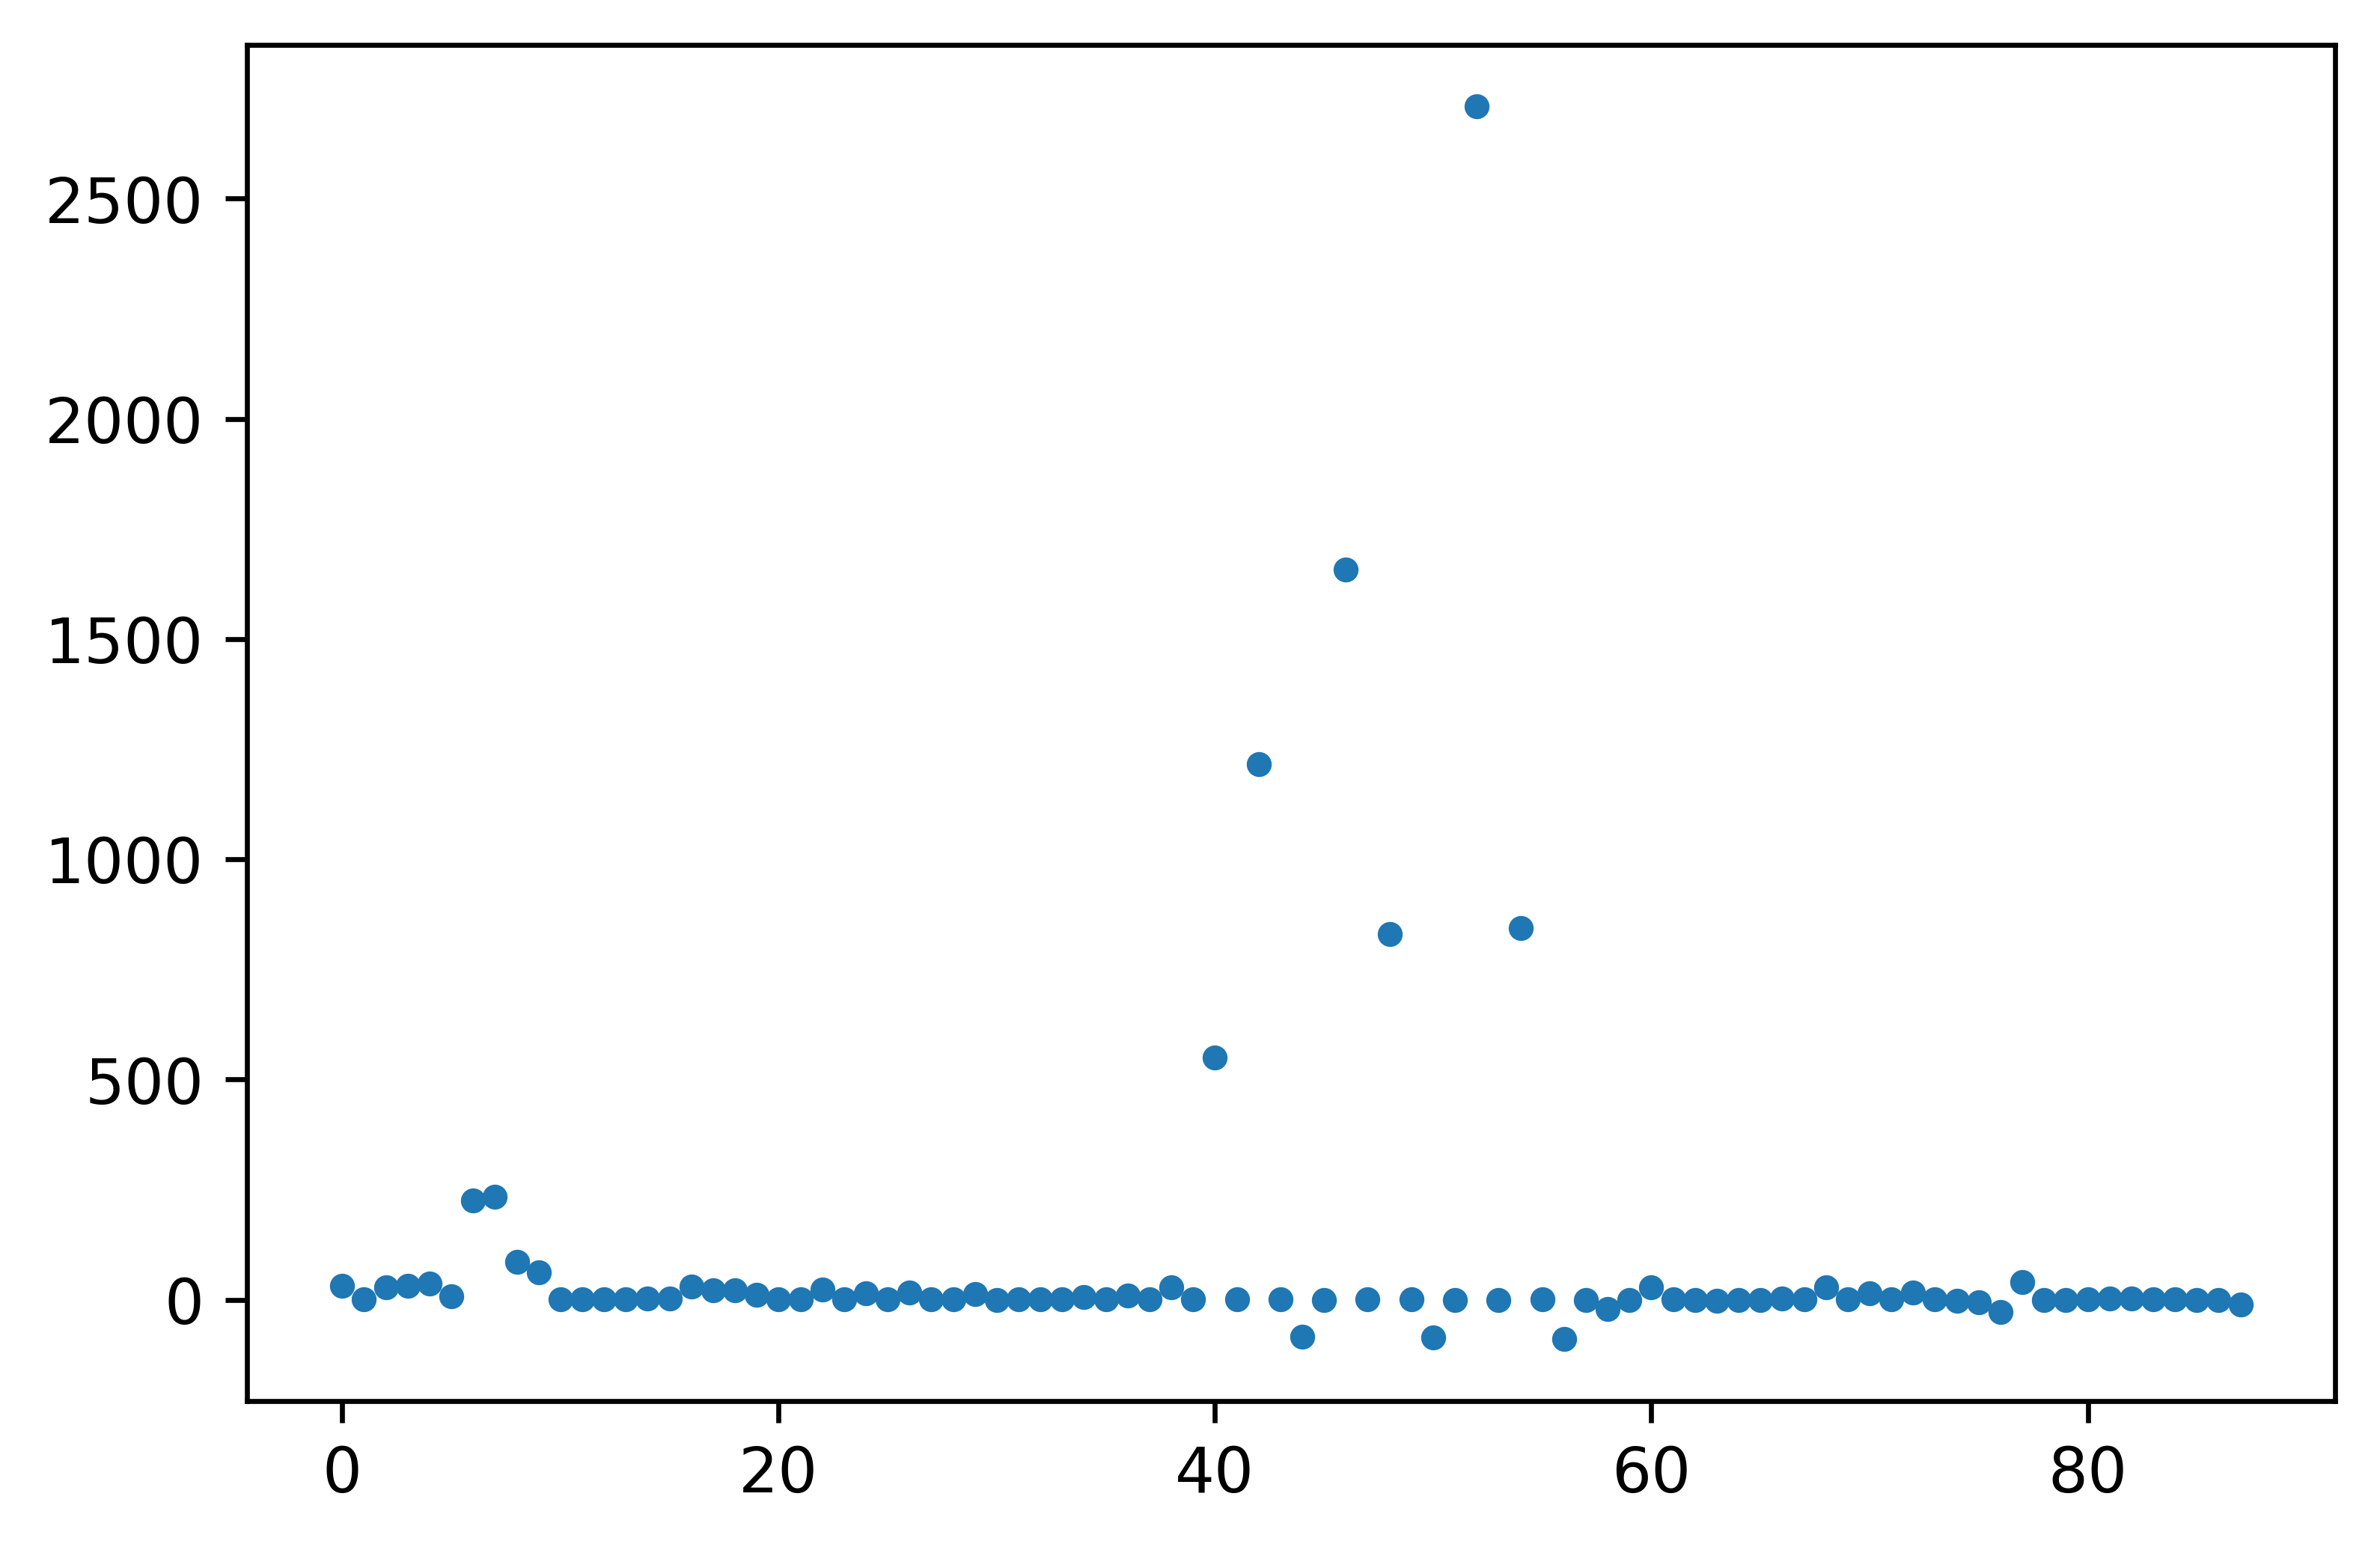

In [26]:
plt.plot(X[120], '.')

Text(0.5, 1.0, 'Histogram of the speakers in the Total data')

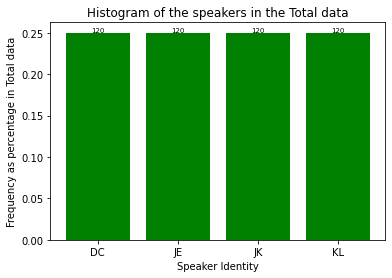

In [18]:
speaker_hist_total = dict(collections.Counter(speaker_identity))
speaker_hist_total.values()
bar = plt.bar(speaker_hist_total.keys(), np.array([i for i in speaker_hist_total.values()])/(sum(speaker_hist_total.values())), color='g')
plt.bar_label(bar, labels = speaker_hist_total.values(), fontsize = 7)
plt.xlabel("Speaker Identity")
plt.ylabel("Frequency as percentage in Total data")
plt.title("Histogram of the speakers in the Total data")

Text(0.5, 1.0, 'Histogram of the speakers in the Training data')

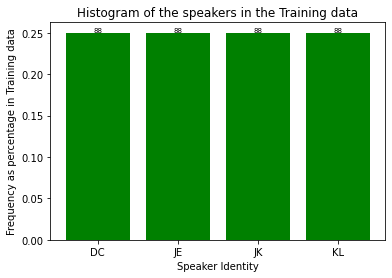

In [19]:
speaker_hist_train = dict(collections.Counter([speaker_identity[i] for i in trainIndicesForEqualSplits]))
speaker_hist_train.values()
bar = plt.bar(speaker_hist_train.keys(), np.array([i for i in speaker_hist_train.values()])/(sum(speaker_hist_train.values())), color='g')
plt.bar_label(bar, labels = speaker_hist_train.values(), fontsize = 7)
plt.xlabel("Speaker Identity")
plt.ylabel("Frequency as percentage in Training data")
plt.title("Histogram of the speakers in the Training data")

Text(0.5, 1.0, 'Histogram of the speakers in the Testing data')

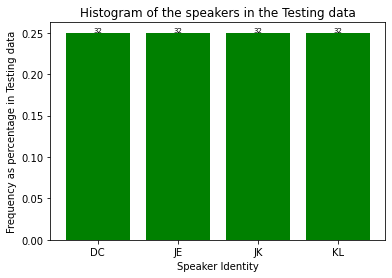

In [20]:
speaker_hist_test = dict(collections.Counter([speaker_identity[i] for i in testIndicesForEqualSplits]))
speaker_hist_test.values()
bar = plt.bar(speaker_hist_test.keys(), np.array([i for i in speaker_hist_test.values()])/(sum(speaker_hist_test.values())), color='g')
plt.bar_label(bar, labels = speaker_hist_test.values(), fontsize = 7)
plt.xlabel("Speaker Identity")
plt.ylabel("Frequency as percentage in Testing data")
plt.title("Histogram of the speakers in the Testing data")

Text(0.5, 1.0, 'Histogram of the emotion data in the total dataset')

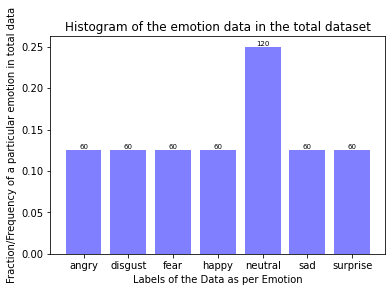

In [21]:
emo_hist_total =  dict(collections.Counter(y))
emo_hist_total.values()

bar = plt.bar(emo_hist_total.keys(), np.array([i for i in emo_hist_total.values()])/(sum(emo_hist_total.values())), color='b', alpha=0.5)
plt.bar_label(bar, labels = emo_hist_total.values(), fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion in total data")
plt.title("Histogram of the emotion data in the total dataset")

Text(0.5, 1.0, 'Histogram of the emotion data in the training dataset')

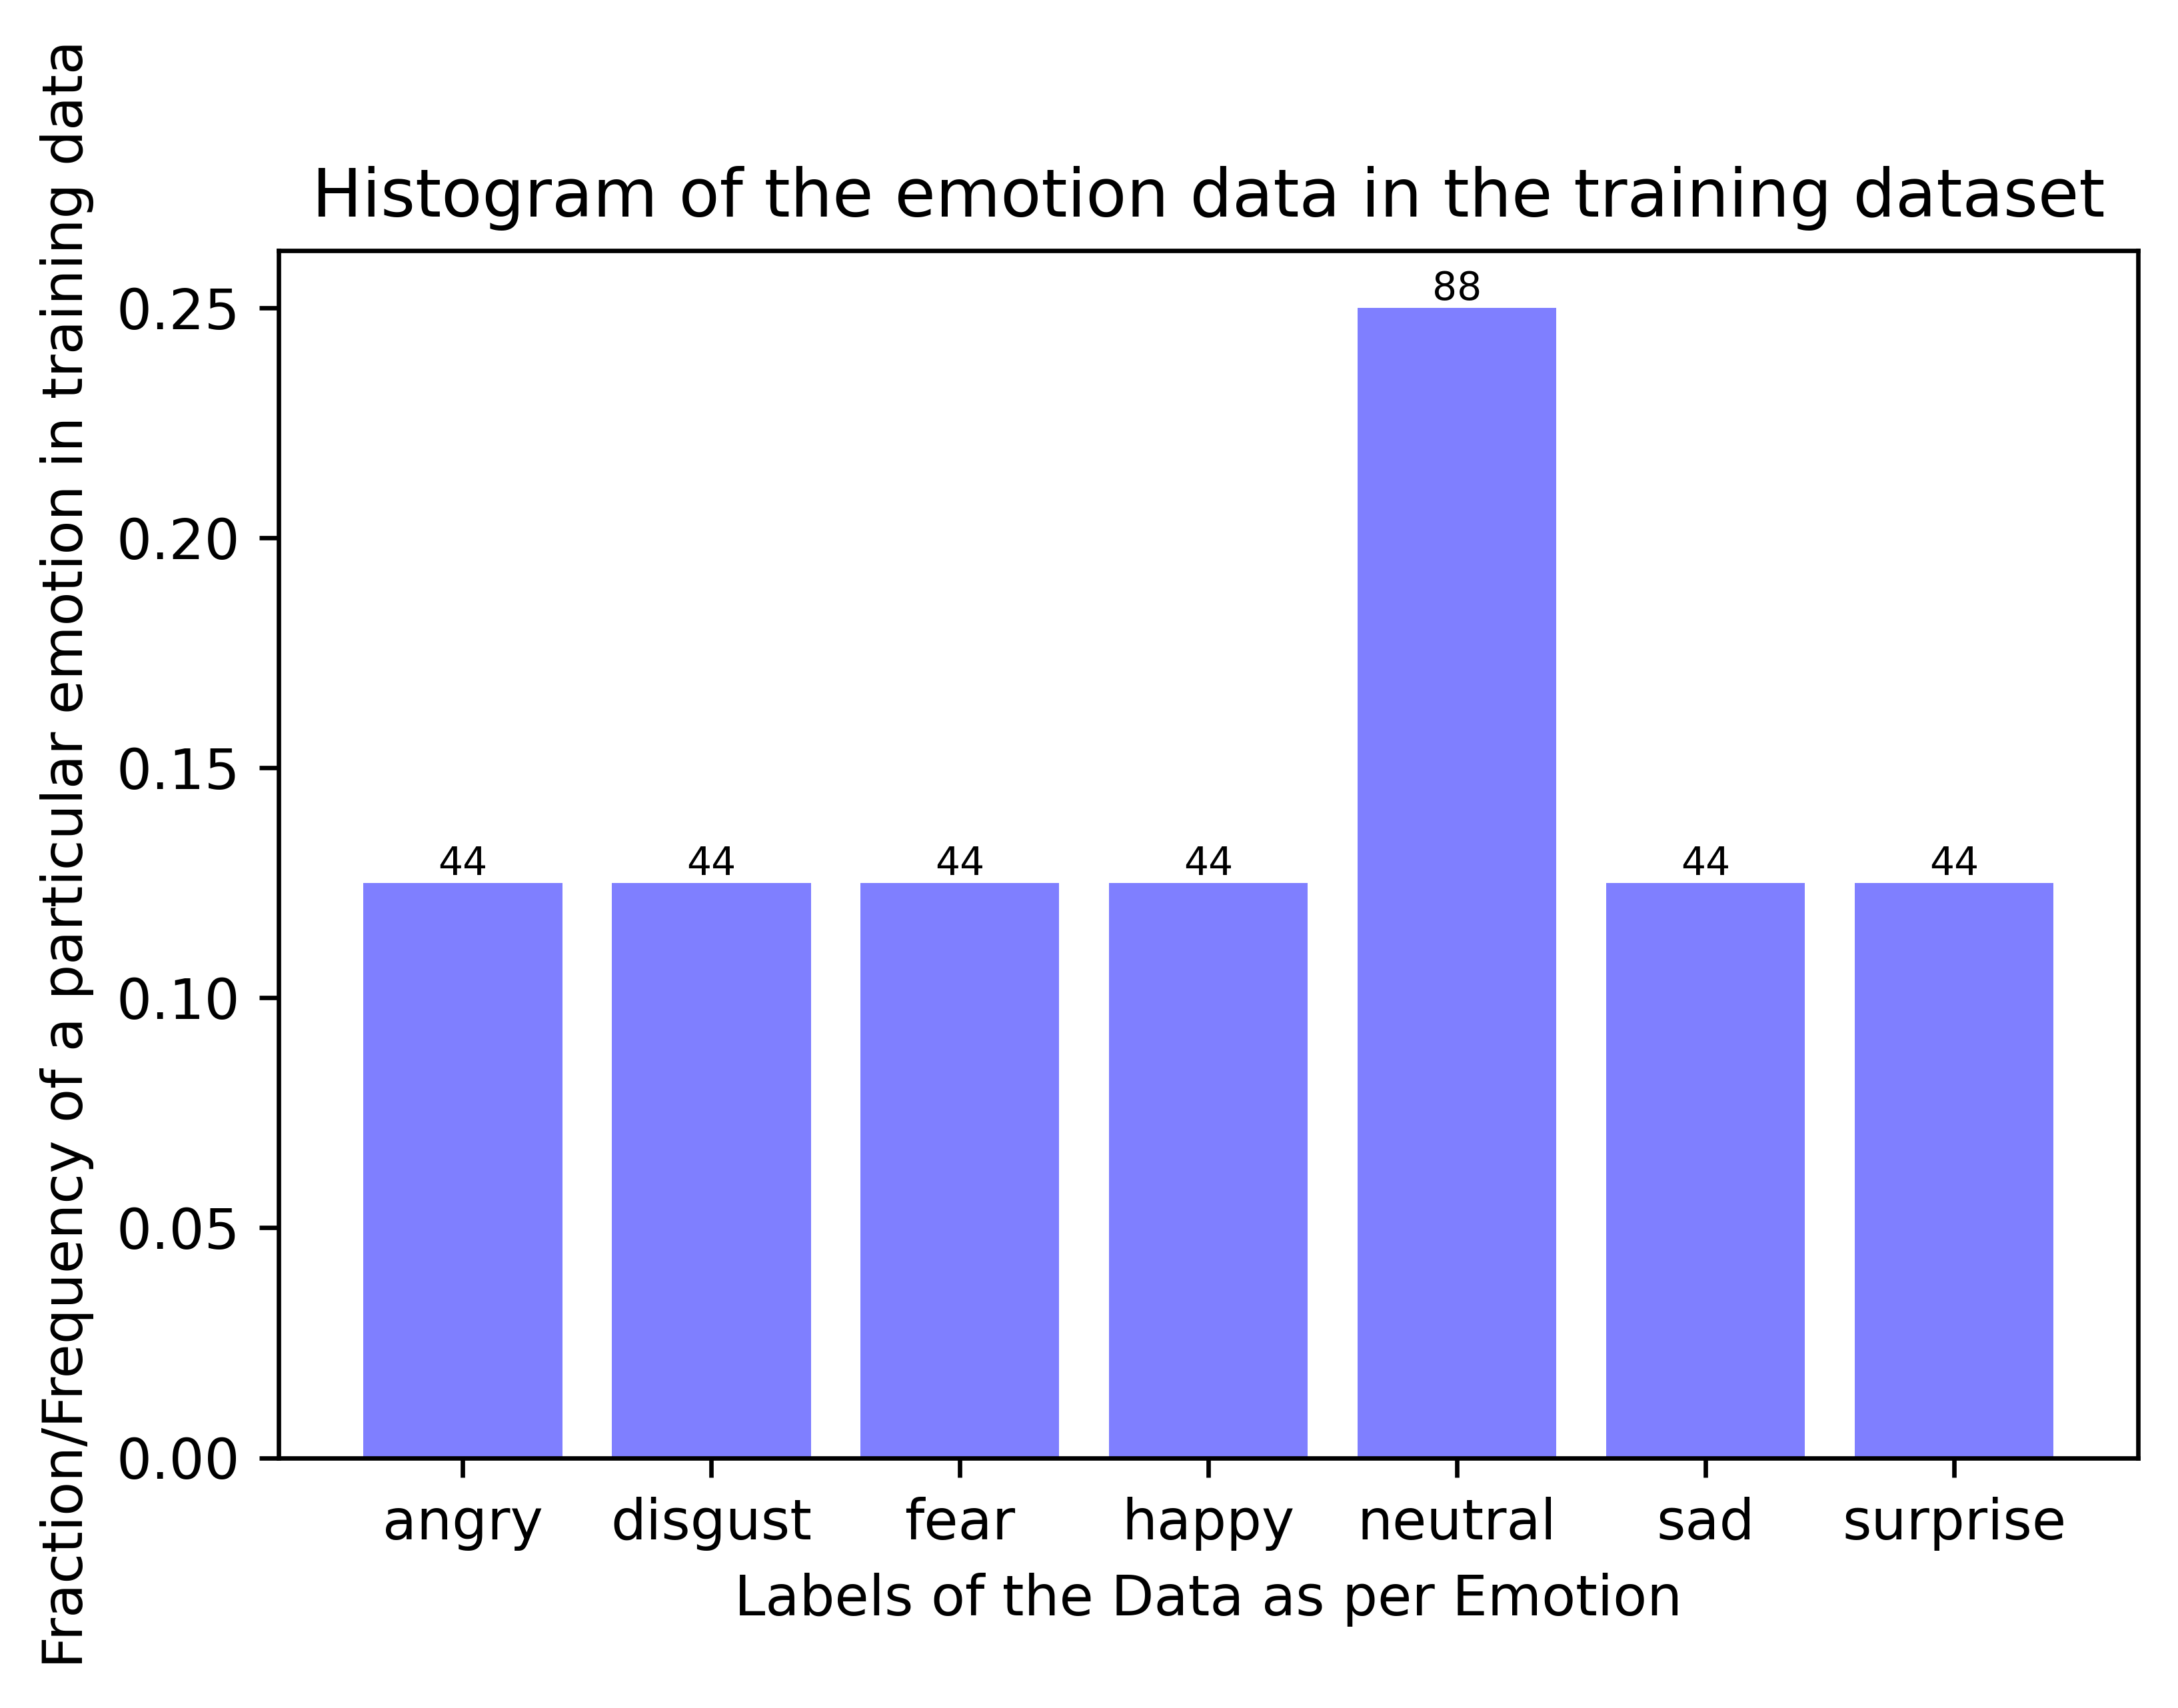

In [22]:
matplotlib.rcParams["figure.dpi"] = 600
emo_hist_train =  dict(collections.Counter([y[i] for i in trainIndicesForEqualSplits]))
emo_hist_train.values()

bar = plt.bar(emo_hist_train.keys(), np.array([i for i in emo_hist_train.values()])/(sum(emo_hist_train.values())), color='b', alpha=0.5)
plt.bar_label(bar, labels = emo_hist_train.values(), fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion in training data")
plt.title("Histogram of the emotion data in the training dataset")

Text(0.5, 1.0, 'Histogram of the emotion data in the test dataset')

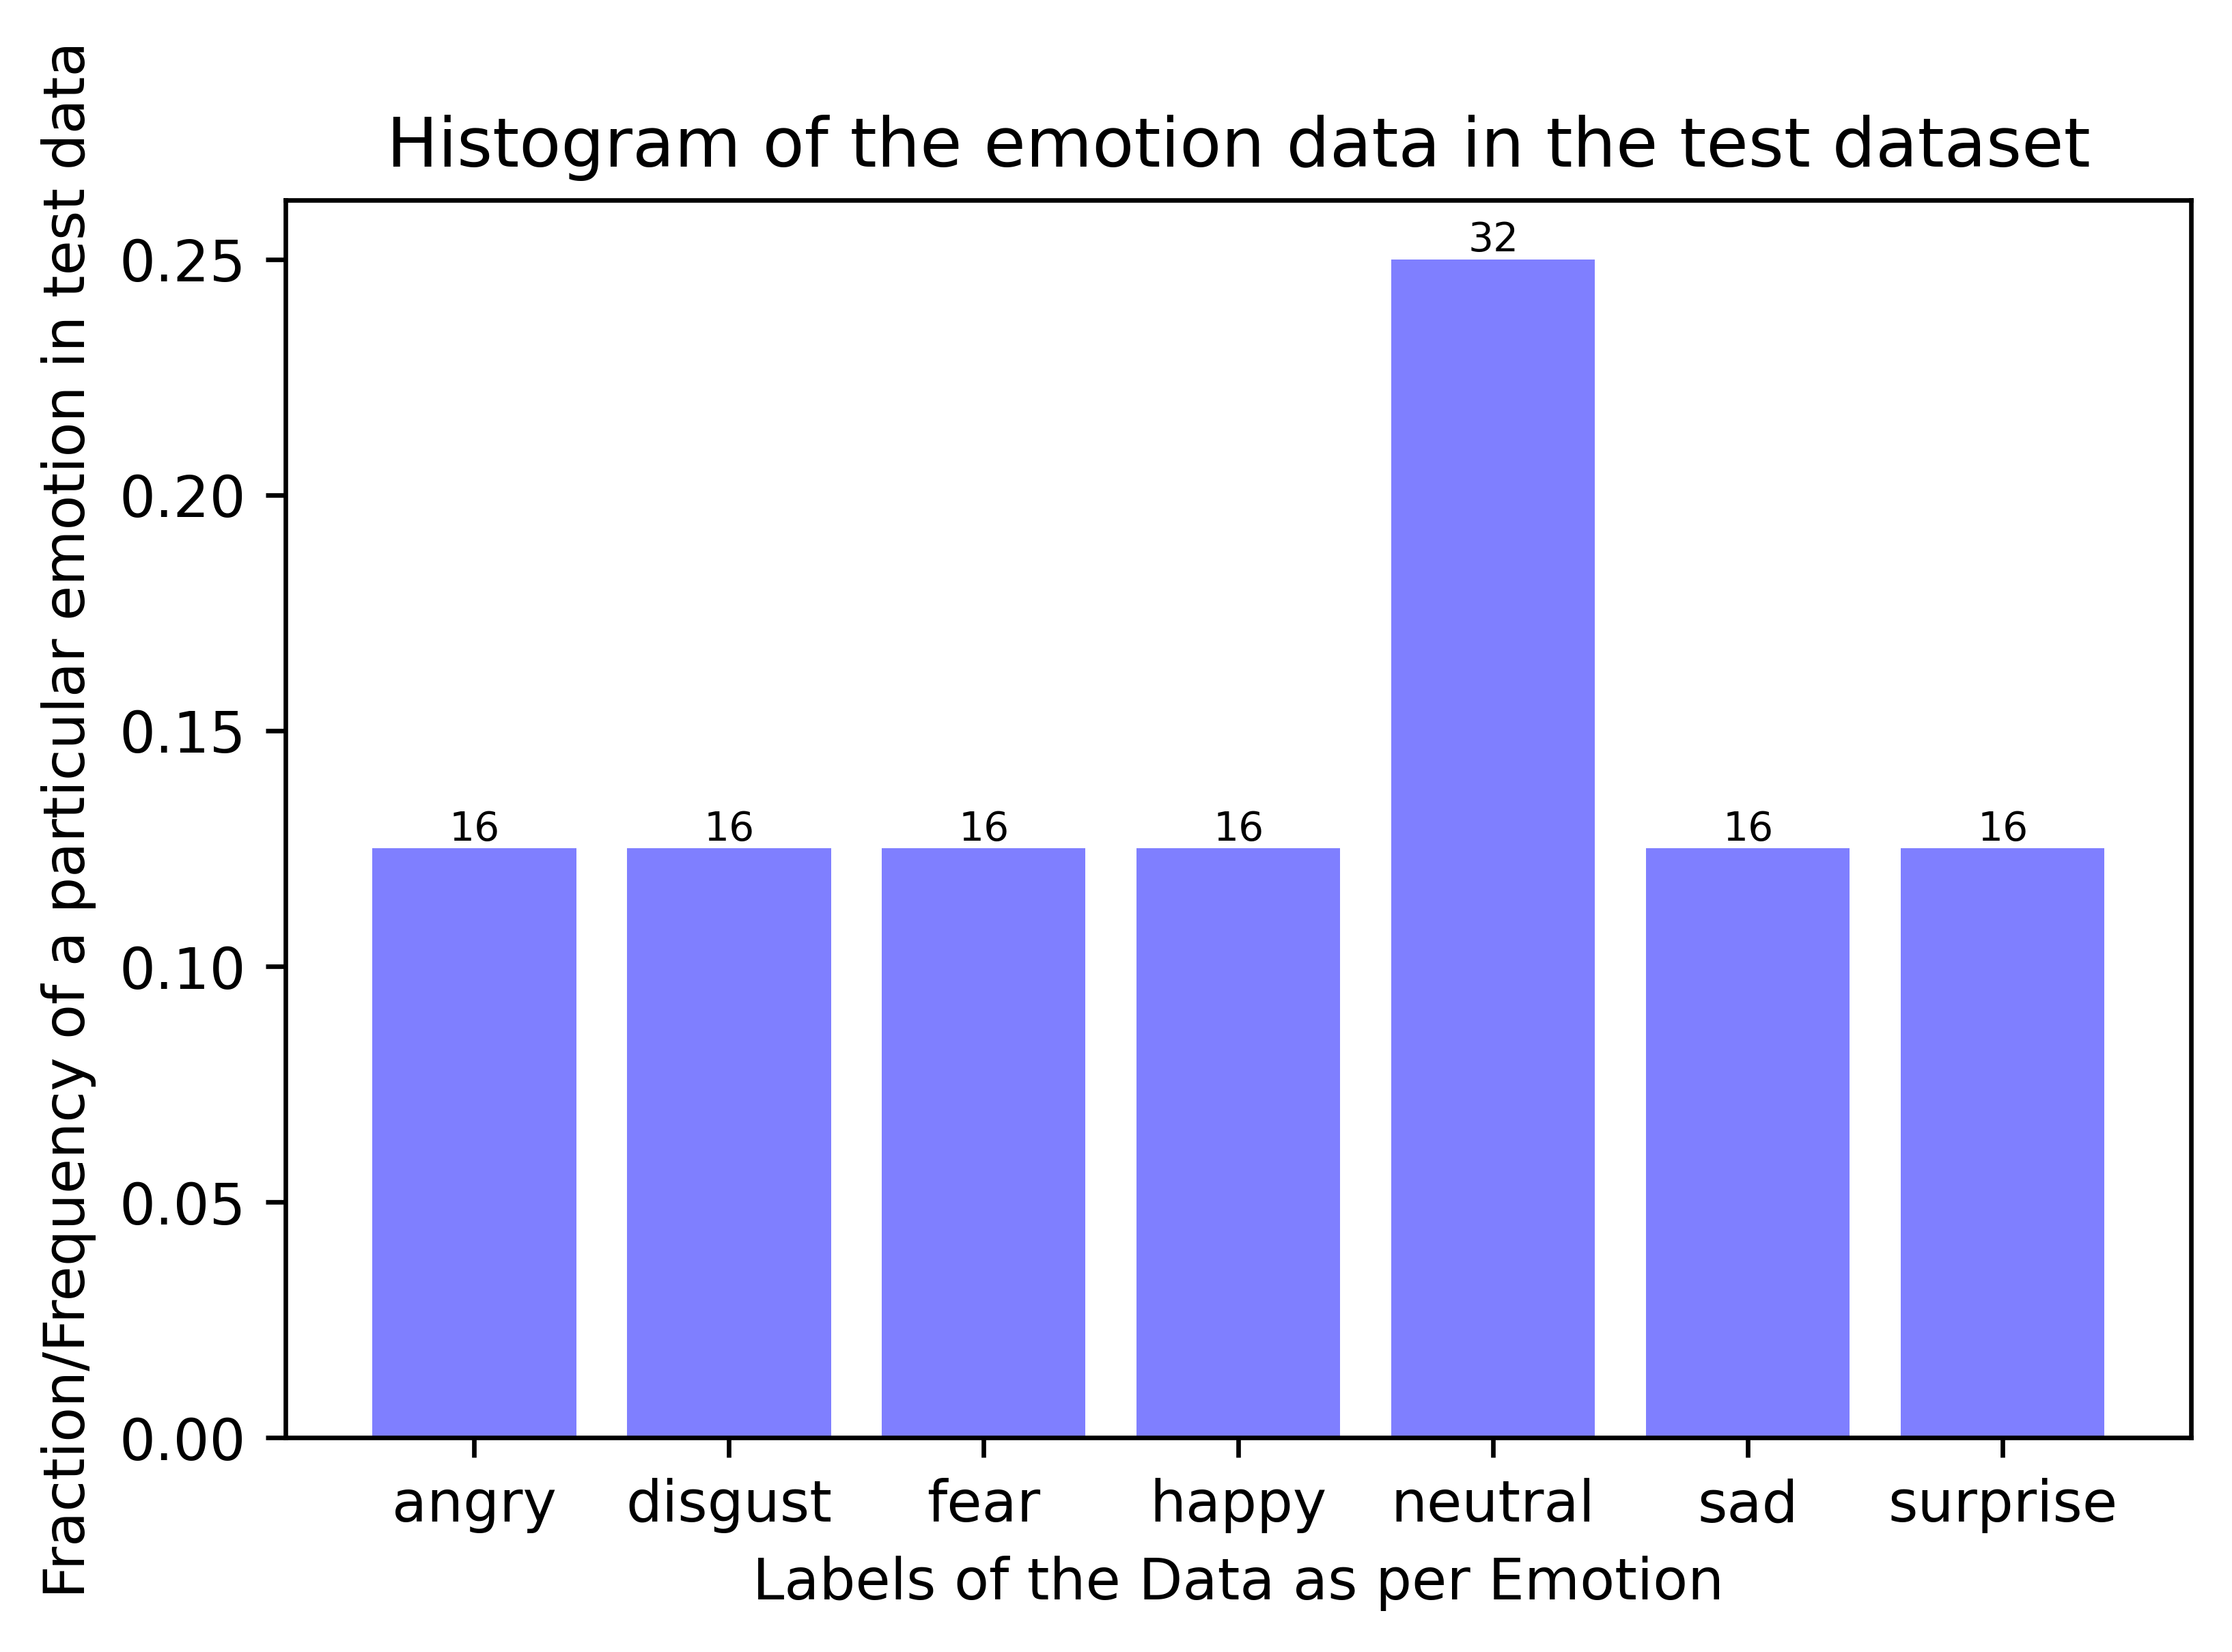

In [23]:
emo_hist_test =  dict(collections.Counter([y[i] for i in testIndicesForEqualSplits]))
emo_hist_test.values()

bar = plt.bar(emo_hist_test.keys(), np.array([i for i in emo_hist_test.values()])/(sum(emo_hist_test.values())), color='b', alpha=0.5)
plt.bar_label(bar, labels = emo_hist_test.values(), fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion in test data")
plt.title("Histogram of the emotion data in the test dataset")

Now, we want to do speaker normalization. That is normalize data along each speaker to preserve each speakers identity.

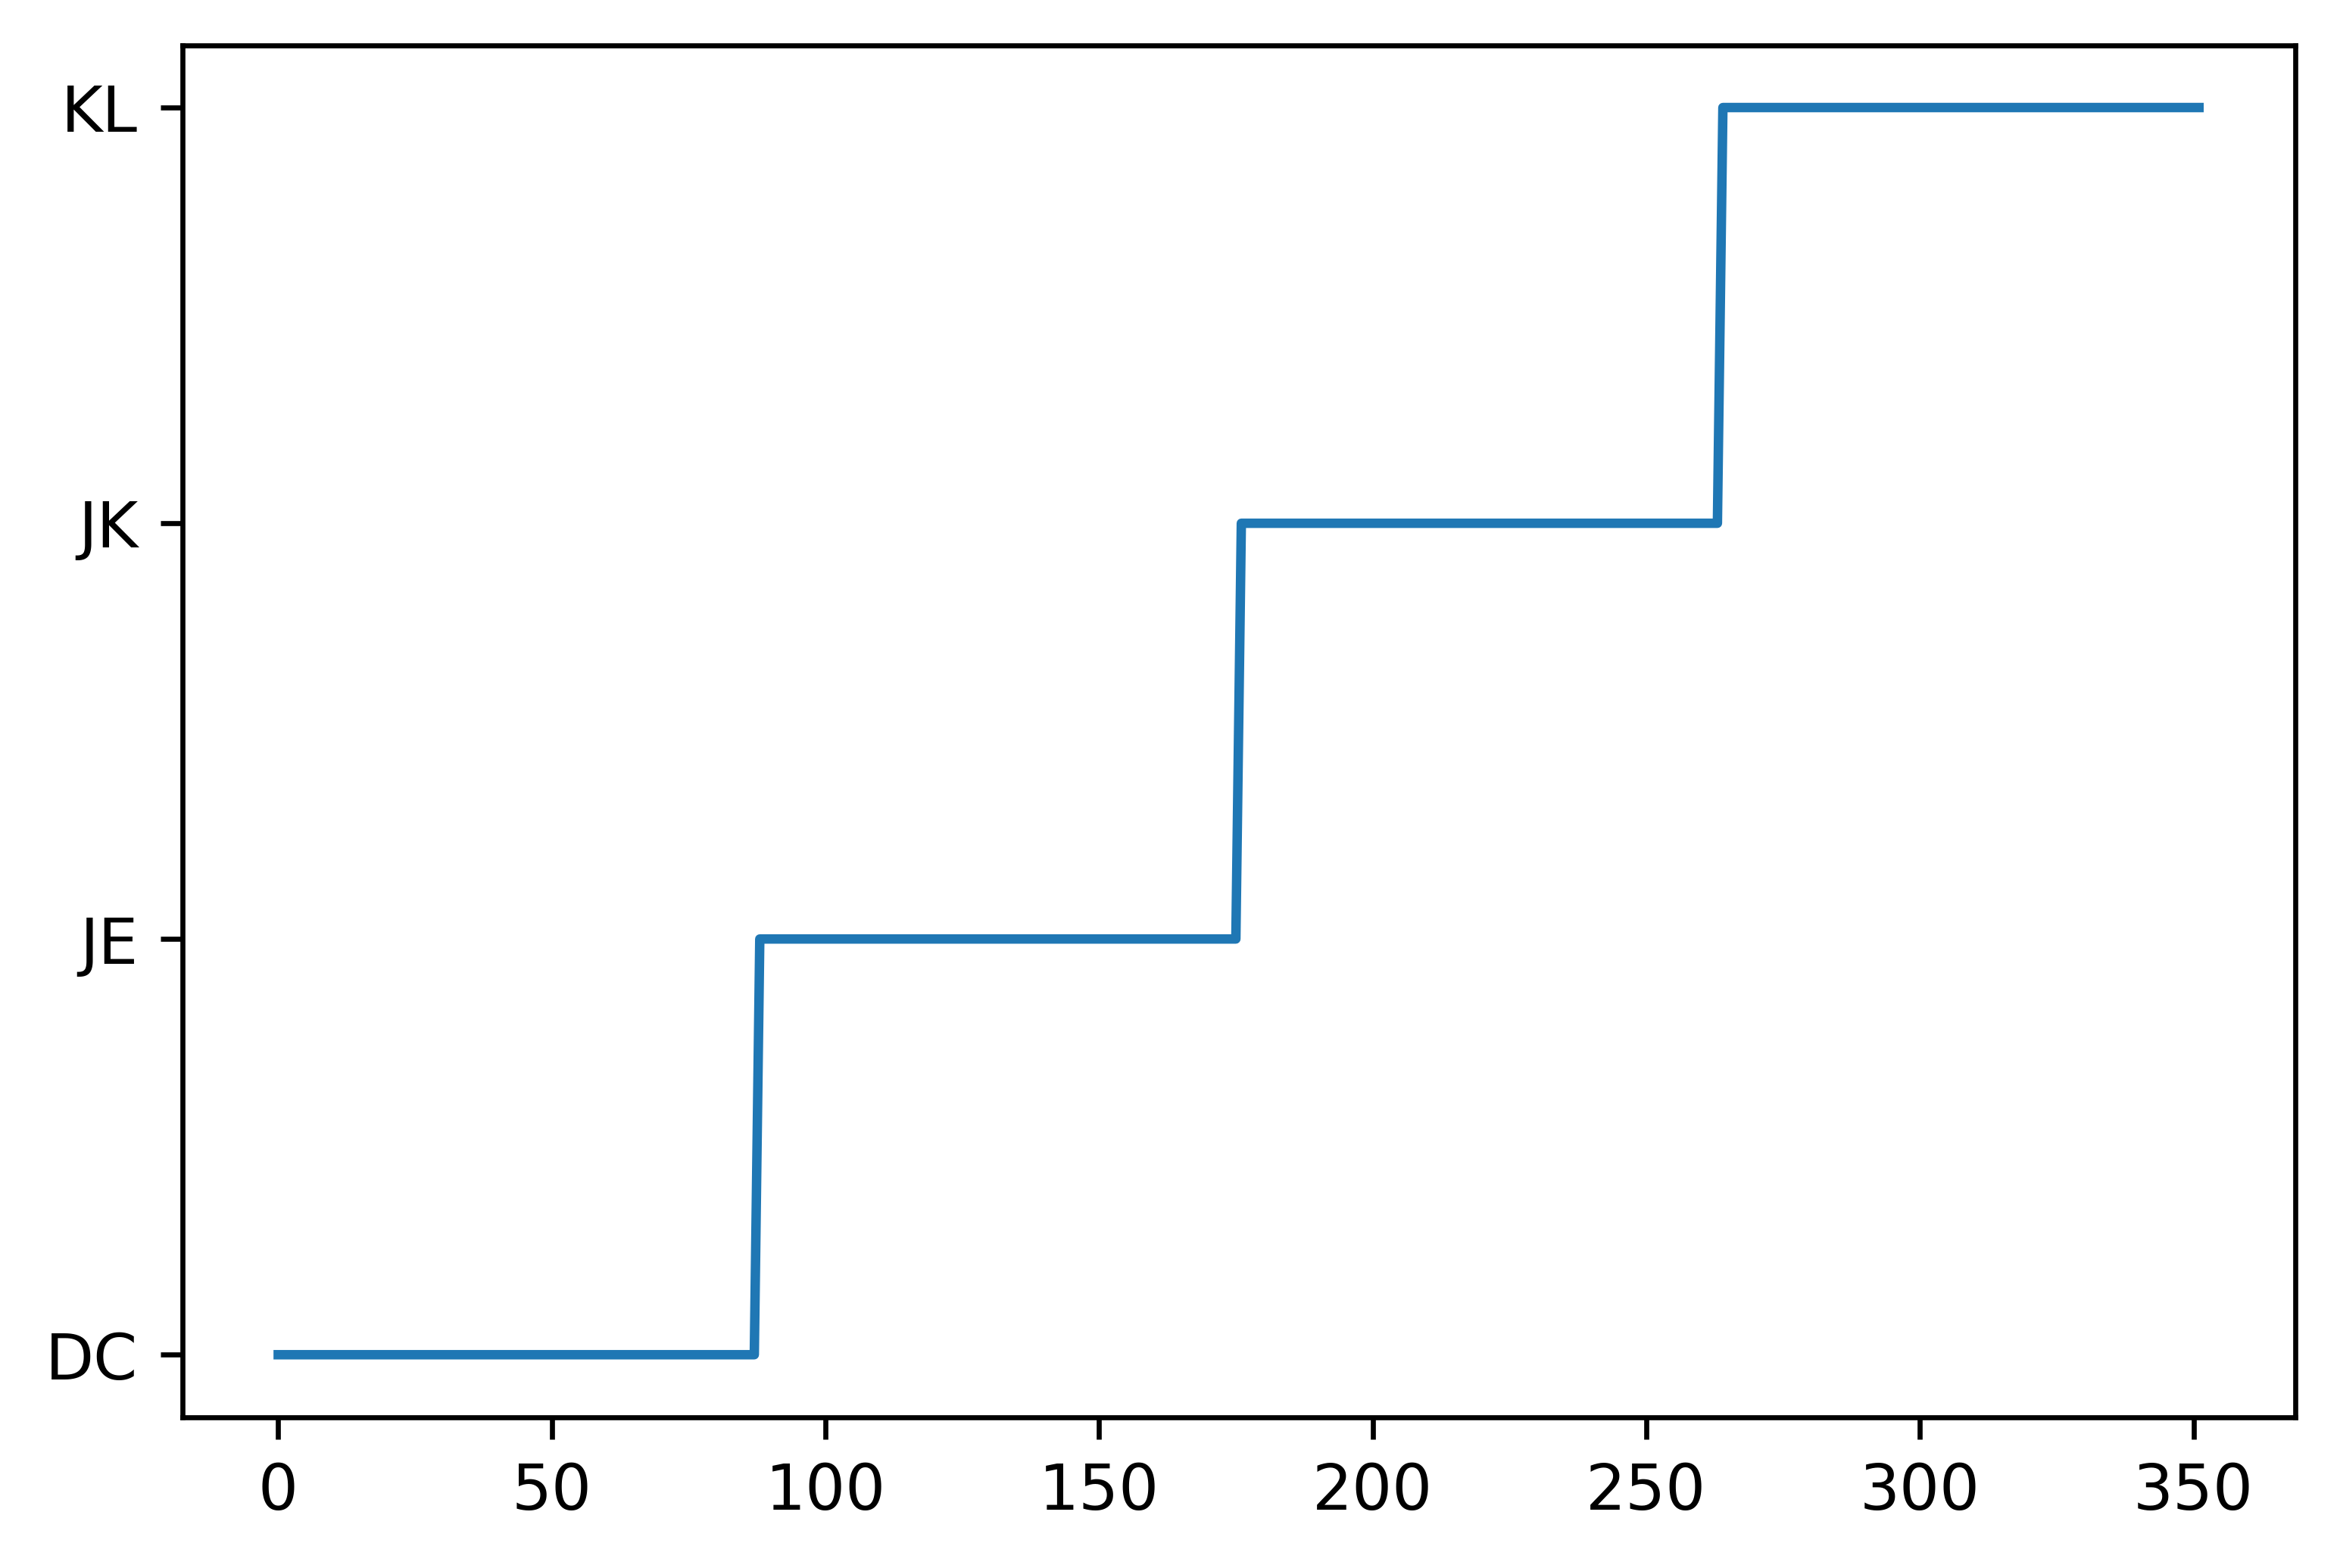

In [24]:
plt.plot([i for i in range(0,len(trainIndicesForEqualSplits))], [speaker_identity[i] for i in trainIndicesForEqualSplits])

Thus, we have different speakers along specific index regions

Text(0, 0.5, 'mfcc1_sma3_amean')

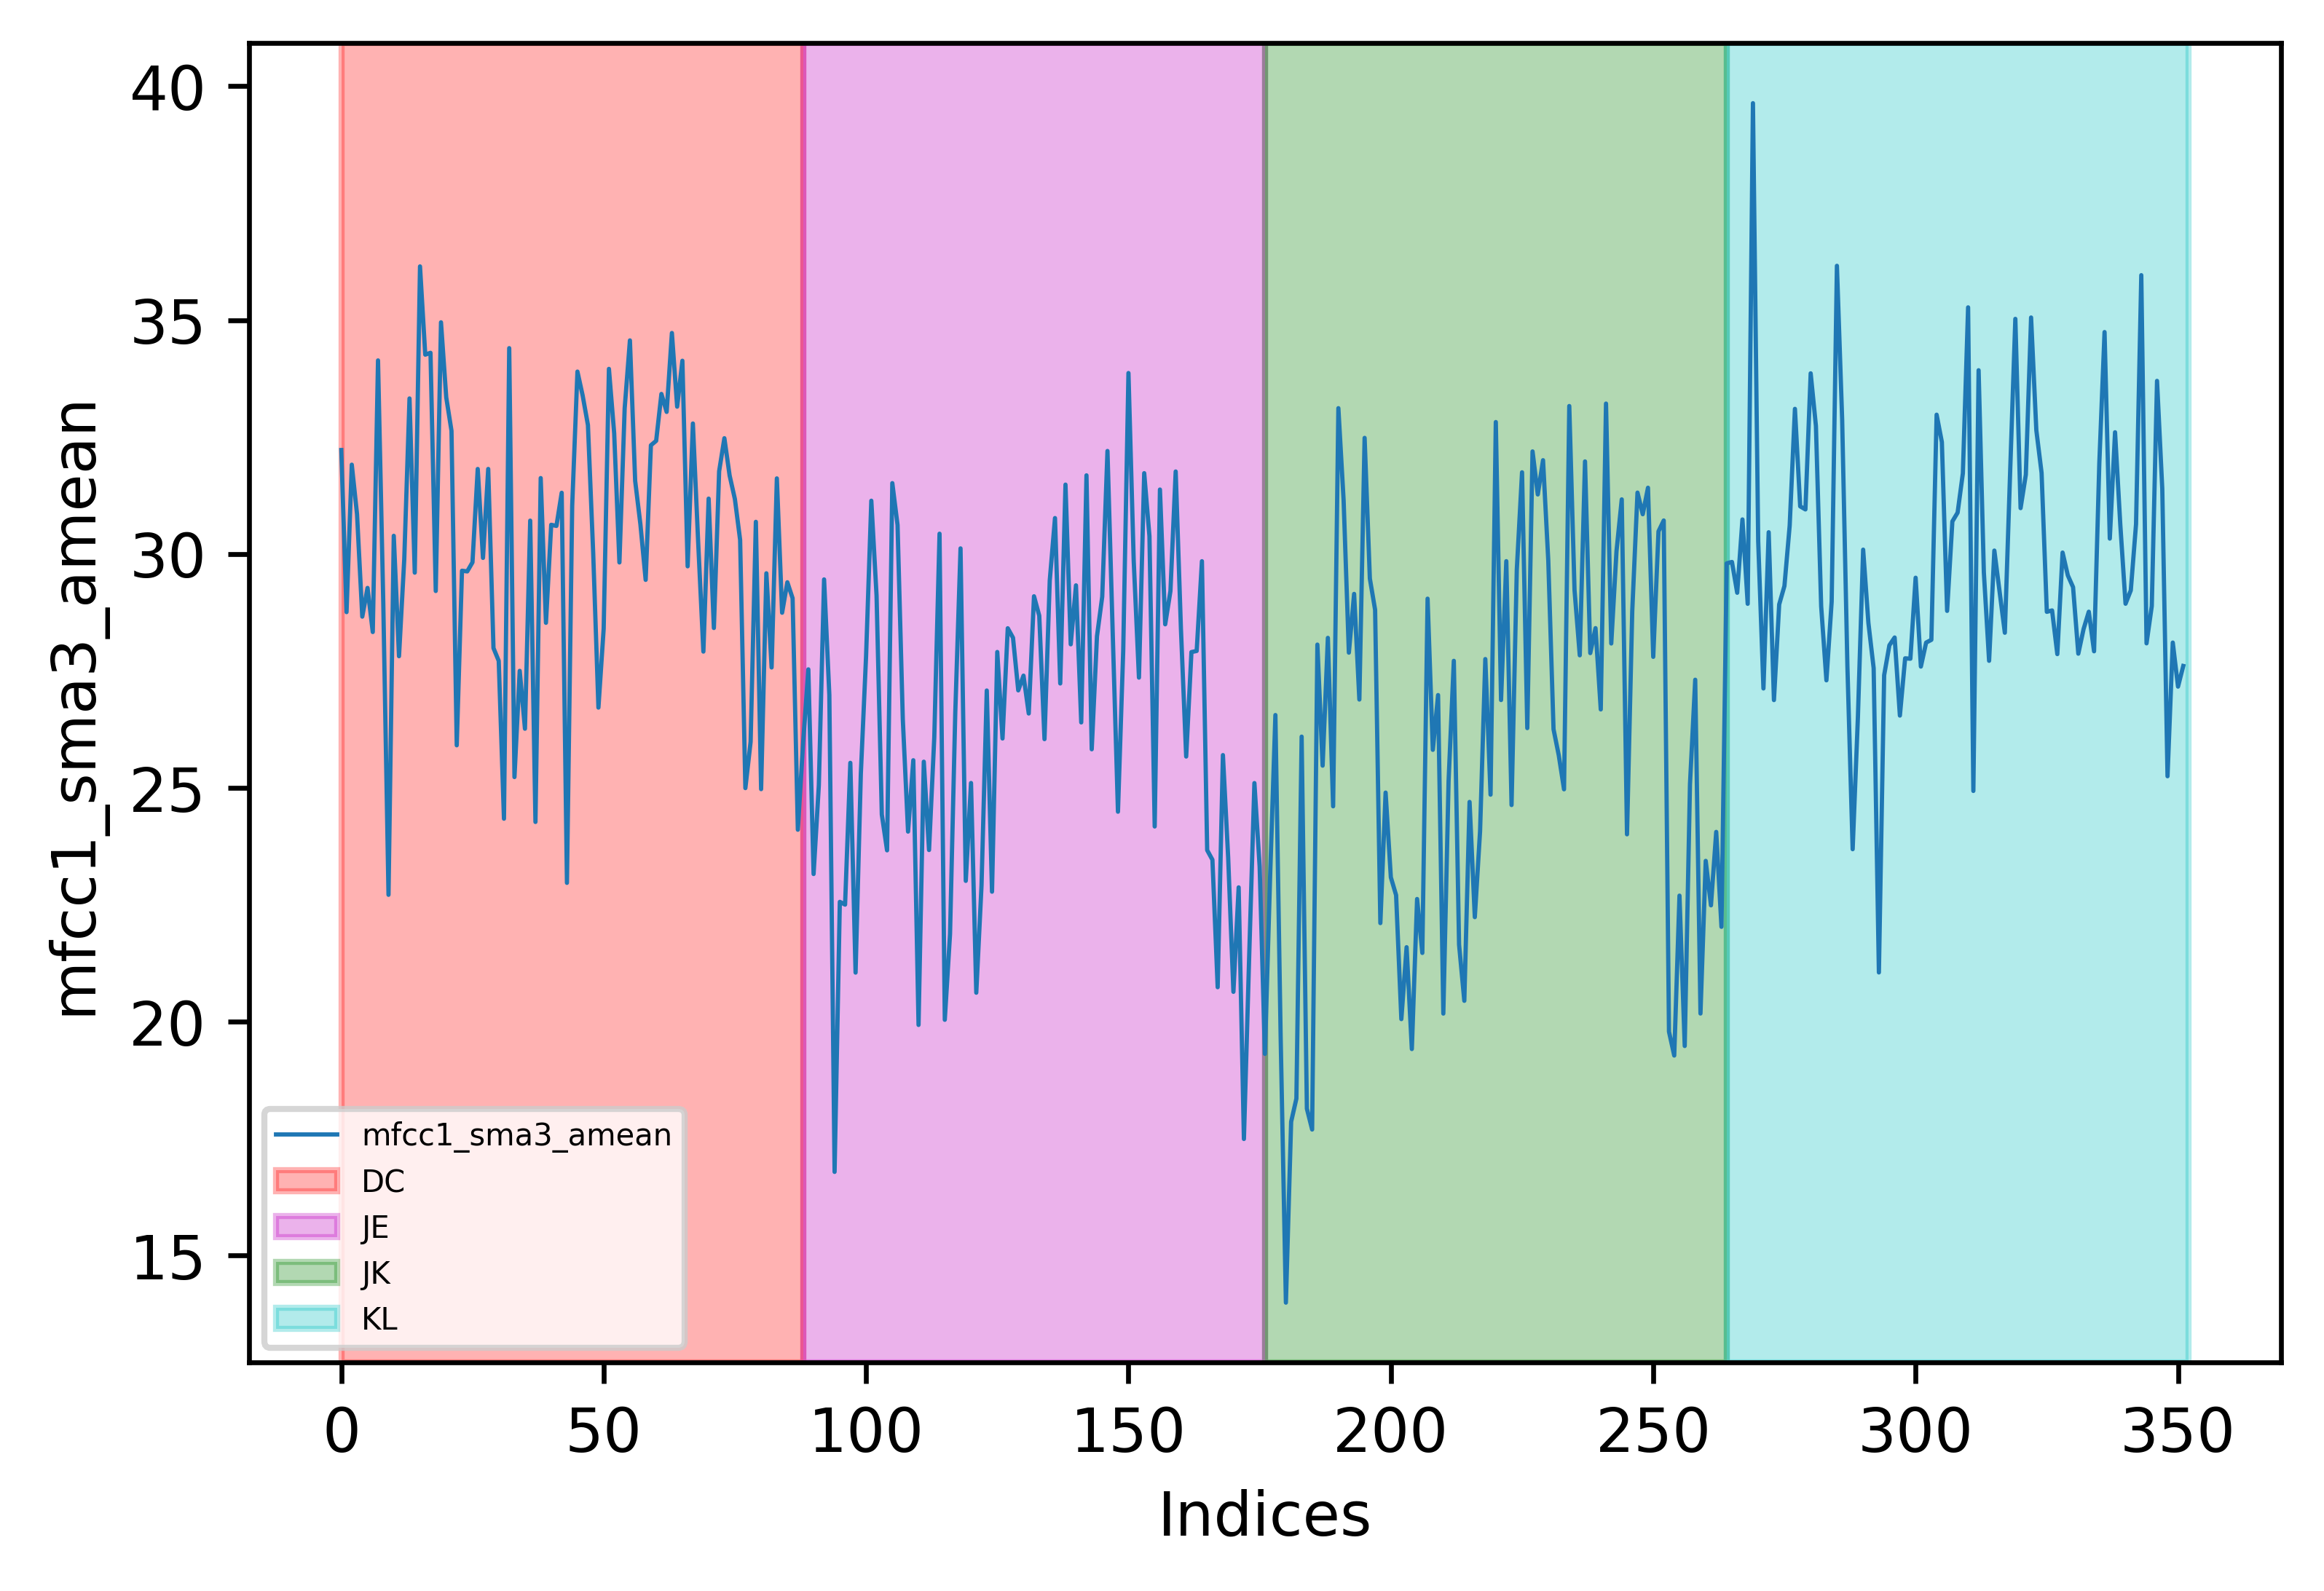

In [30]:
ind = 22
plt.plot([i for i in range(0,len(trainIndicesForEqualSplits))], X[trainIndicesForEqualSplits][:,ind], linewidth = 0.7, label = f"{smile.feature_names[ind]}")
plt.axvspan(0, len(trainIndicesForEqualSplits)//4, color='r', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][0]}')
plt.axvspan(len(trainIndicesForEqualSplits)//4, 2*(len(trainIndicesForEqualSplits))//4, color='m', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][len(trainIndicesForEqualSplits)//4]}')
plt.axvspan(2*(len(trainIndicesForEqualSplits))//4, 3*(len(trainIndicesForEqualSplits))//4, color='g', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][2*(len(trainIndicesForEqualSplits))//4]}')
plt.axvspan(3*(len(trainIndicesForEqualSplits))//4, len(trainIndicesForEqualSplits), color='c', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][3*(len(trainIndicesForEqualSplits))//4]}')
plt.legend(fontsize = 5)
plt.xlabel("Indices")
plt.ylabel(f"{smile.feature_names[ind]}")


In [31]:
X_train, y_train, X_test, y_test = X[trainIndicesForEqualSplits], [y[i] for i in trainIndicesForEqualSplits], X[testIndicesForEqualSplits], [y[i] for i in testIndicesForEqualSplits]

In [32]:
X_test.shape

(128, 88)

In [33]:
# X_train[0 : len(trainIndicesForEqualSplits)//4] = (X_train[0 : len(trainIndicesForEqualSplits)//4] - X_train[0 : len(trainIndicesForEqualSplits)//4].min(0)) / X_train[0 : len(trainIndicesForEqualSplits)//4].ptp(0)
# X_train[len(trainIndicesForEqualSplits)//4 : 2*(len(trainIndicesForEqualSplits))//4] = (X_train[len(trainIndicesForEqualSplits)//4 : 2*(len(trainIndicesForEqualSplits))//4] - X_train[len(trainIndicesForEqualSplits)//4 : 2*(len(trainIndicesForEqualSplits))//4].min(0)) / X_train[len(trainIndicesForEqualSplits)//4 : 2*(len(trainIndicesForEqualSplits))//4].ptp(0)
# X_train[2 * len(trainIndicesForEqualSplits)//4 : 3*(len(trainIndicesForEqualSplits))//4] = (X_train[2 * len(trainIndicesForEqualSplits)//4 : 3*(len(trainIndicesForEqualSplits))//4] - X_train[2 * len(trainIndicesForEqualSplits)//4 : 3*(len(trainIndicesForEqualSplits))//4].min(0)) / X_train[2 * len(trainIndicesForEqualSplits)//4 : 3*(len(trainIndicesForEqualSplits))//4].ptp(0)
# X_train[3 * len(trainIndicesForEqualSplits)//4 : len(trainIndicesForEqualSplits)] = (X_train[3 * len(trainIndicesForEqualSplits)//4 : len(trainIndicesForEqualSplits)] - X_train[3 * len(trainIndicesForEqualSplits)//4 : len(trainIndicesForEqualSplits)].min(0)) / X_train[3 * len(trainIndicesForEqualSplits)//4 : len(trainIndicesForEqualSplits)].ptp(0)

In [34]:
# X_test[0 : len(testIndicesForEqualSplits)//4] = (X_test[0 : len(testIndicesForEqualSplits)//4] - X_test[0 : len(testIndicesForEqualSplits)//4].min(0)) / X_test[0 : len(testIndicesForEqualSplits)//4].ptp(0)
# X_test[len(testIndicesForEqualSplits)//4 : 2*(len(testIndicesForEqualSplits))//4] = (X_test[len(testIndicesForEqualSplits)//4 : 2*(len(testIndicesForEqualSplits))//4] - X_test[len(testIndicesForEqualSplits)//4 : 2*(len(testIndicesForEqualSplits))//4].min(0)) / X_test[len(testIndicesForEqualSplits)//4 : 2*(len(testIndicesForEqualSplits))//4].ptp(0)
# X_test[2 * len(testIndicesForEqualSplits)//4 : 3*(len(testIndicesForEqualSplits))//4] = (X_test[2 * len(testIndicesForEqualSplits)//4 : 3*(len(testIndicesForEqualSplits))//4] - X_test[2 * len(testIndicesForEqualSplits)//4 : 3*(len(testIndicesForEqualSplits))//4].min(0)) / X_test[2 * len(testIndicesForEqualSplits)//4 : 3*(len(testIndicesForEqualSplits))//4].ptp(0)
# X_test[3 * len(testIndicesForEqualSplits)//4 : len(testIndicesForEqualSplits)] = (X_test[3 * len(testIndicesForEqualSplits)//4 : len(testIndicesForEqualSplits)] - X_test[3 * len(testIndicesForEqualSplits)//4 : len(testIndicesForEqualSplits)].min(0)) / X_test[3 * len(testIndicesForEqualSplits)//4 : len(testIndicesForEqualSplits)].ptp(0)

In [35]:
# ind = 22
# plt.plot([i for i in range(0,len(trainIndicesForEqualSplits))], X_train[:,ind], linewidth = 0.7, label = f"{smile.feature_names[ind]}")
# plt.axvspan(0, len(trainIndicesForEqualSplits)//4, color='r', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][0]}')
# plt.axvspan(len(trainIndicesForEqualSplits)//4, 2*(len(trainIndicesForEqualSplits))//4, color='m', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][len(trainIndicesForEqualSplits)//4]}')
# plt.axvspan(2*(len(trainIndicesForEqualSplits))//4, 3*(len(trainIndicesForEqualSplits))//4, color='g', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][2*(len(trainIndicesForEqualSplits))//4]}')
# plt.axvspan(3*(len(trainIndicesForEqualSplits))//4, len(trainIndicesForEqualSplits), color='c', alpha = 0.3, label = f'{[speaker_identity[i] for i in trainIndicesForEqualSplits][3*(len(trainIndicesForEqualSplits))//4]}')
# plt.legend(fontsize = 5)
# plt.xlabel("Indices")
# plt.ylabel(f"{smile.feature_names[ind]}")
# plt.title("After speaker to speaker normalization")

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 

#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'poly', 'linear']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10, n_jobs=-1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


In [60]:
print(grid_search.best_params_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [61]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 63.56%


In [62]:
X_test = scaler.transform(X_test)
y_test_hat=grid.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 67.97%


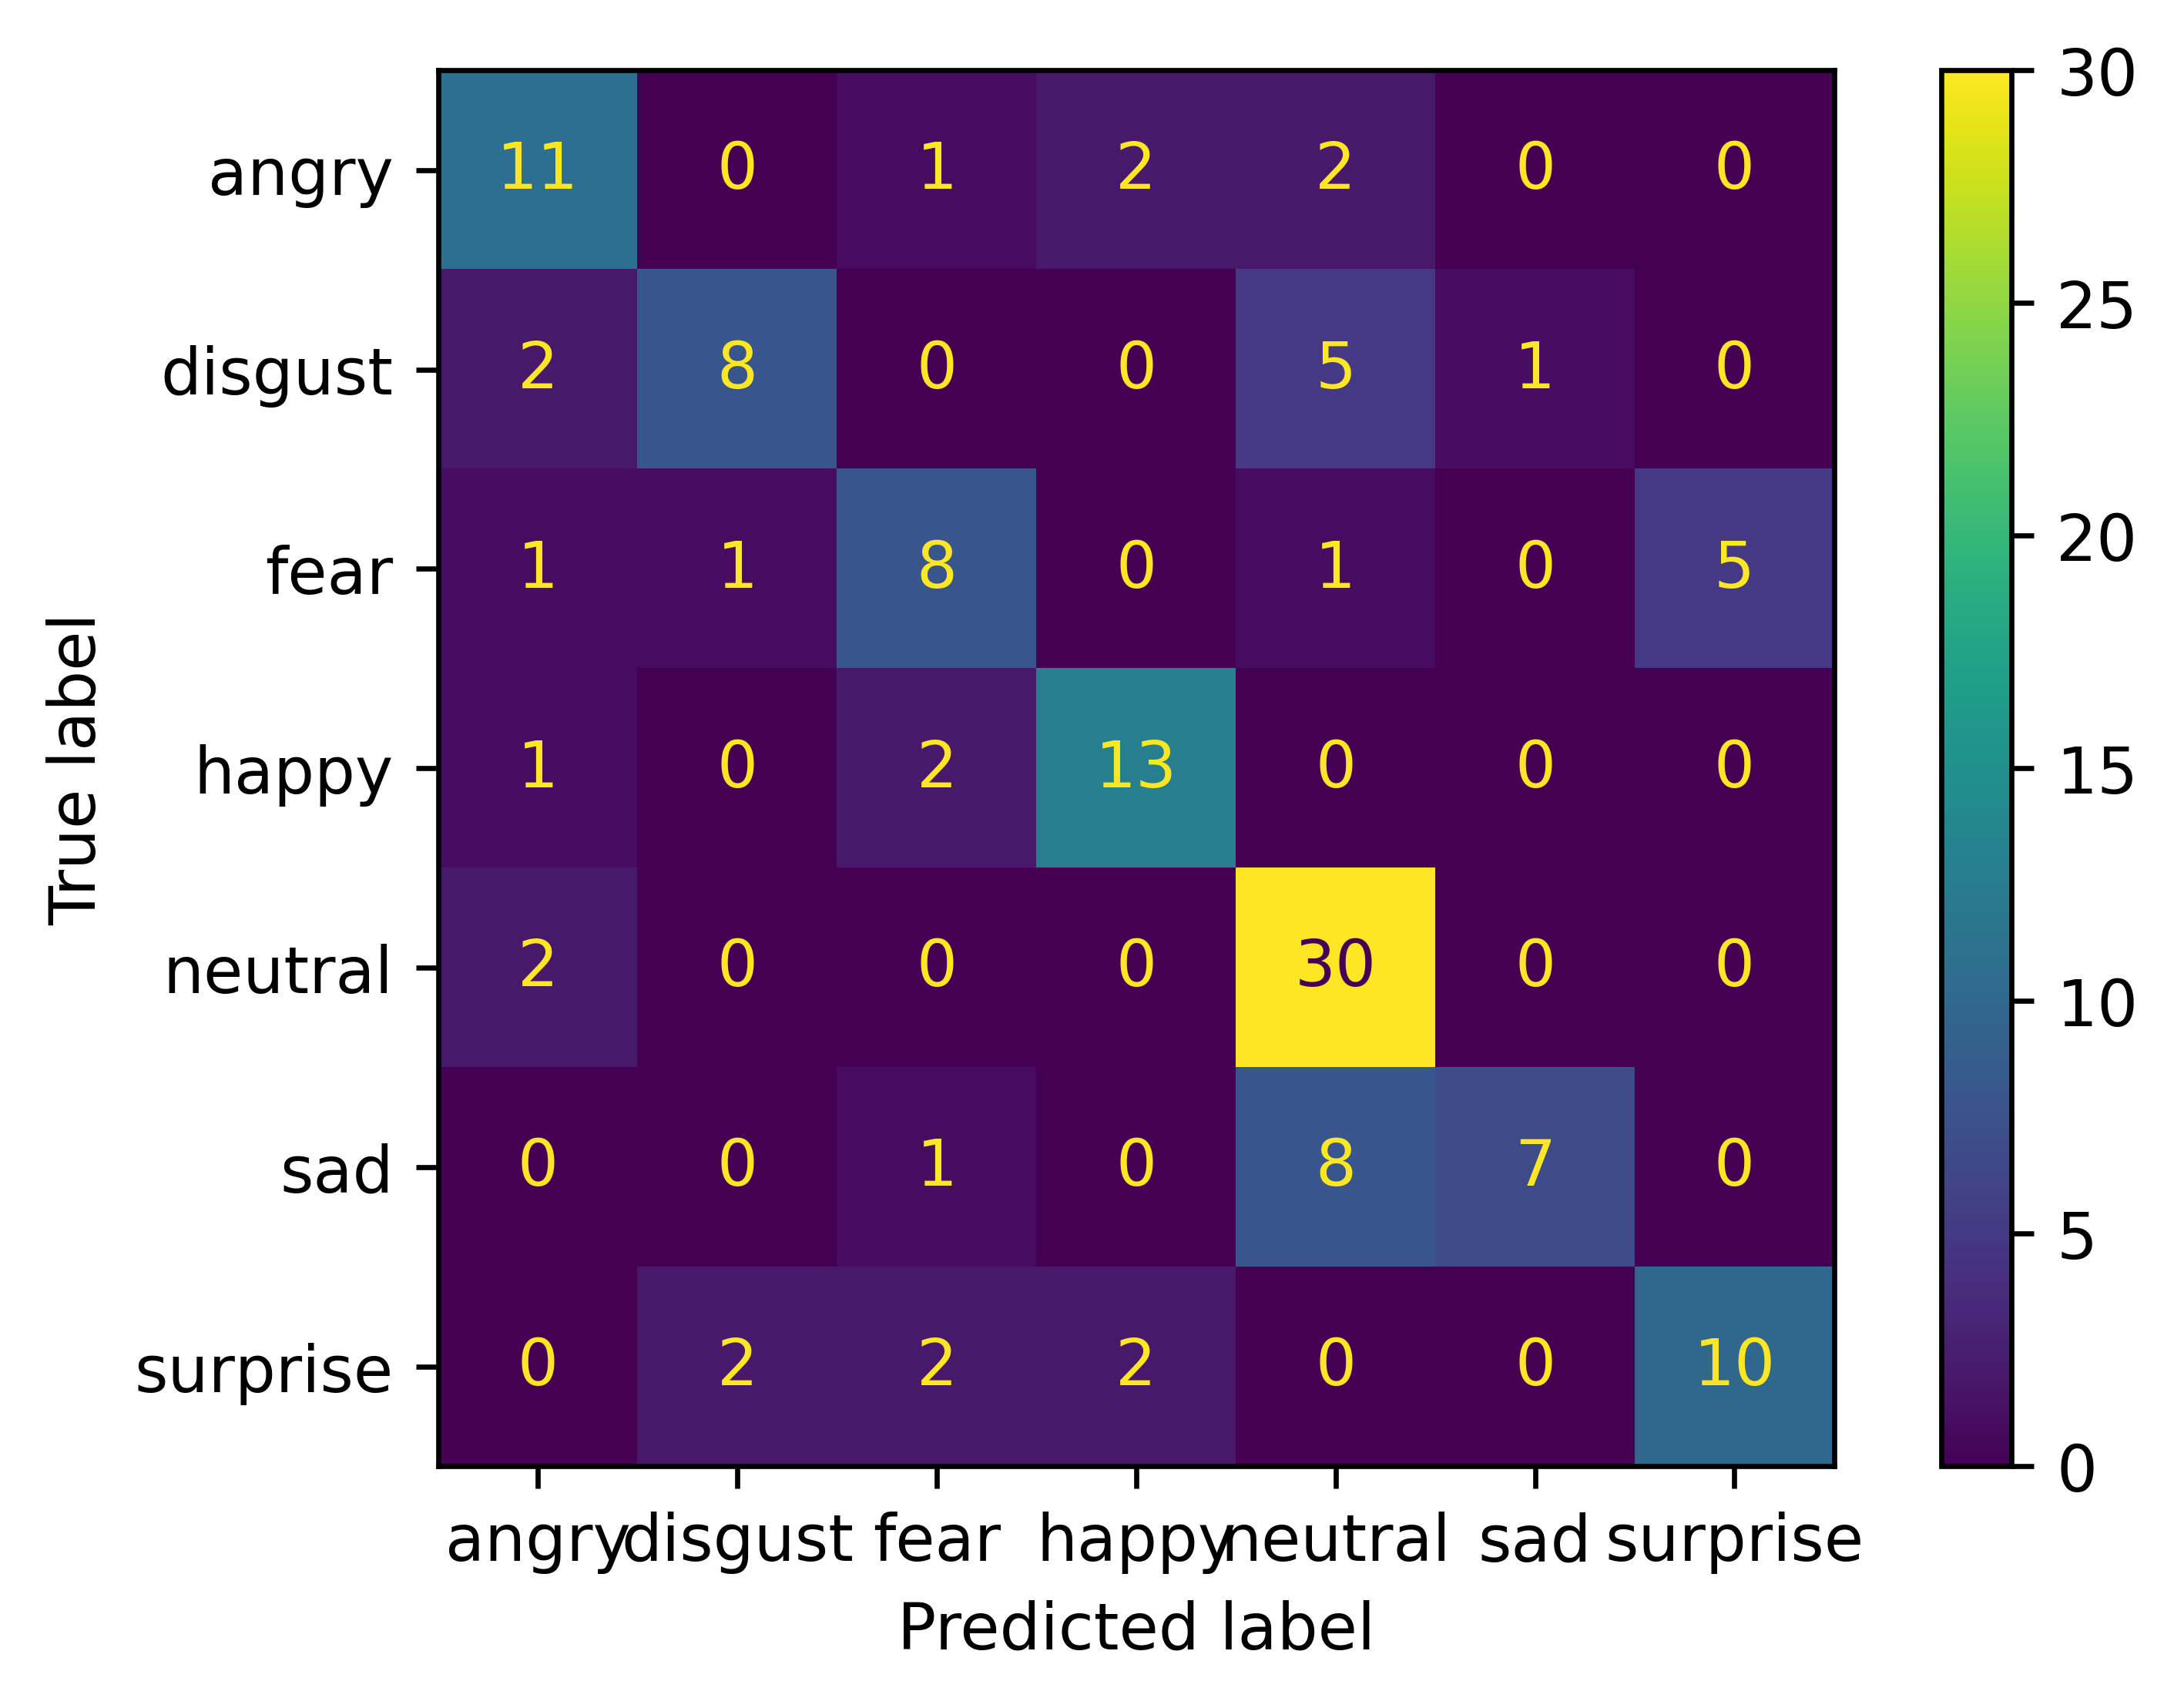

In [54]:
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot()
plt.show()

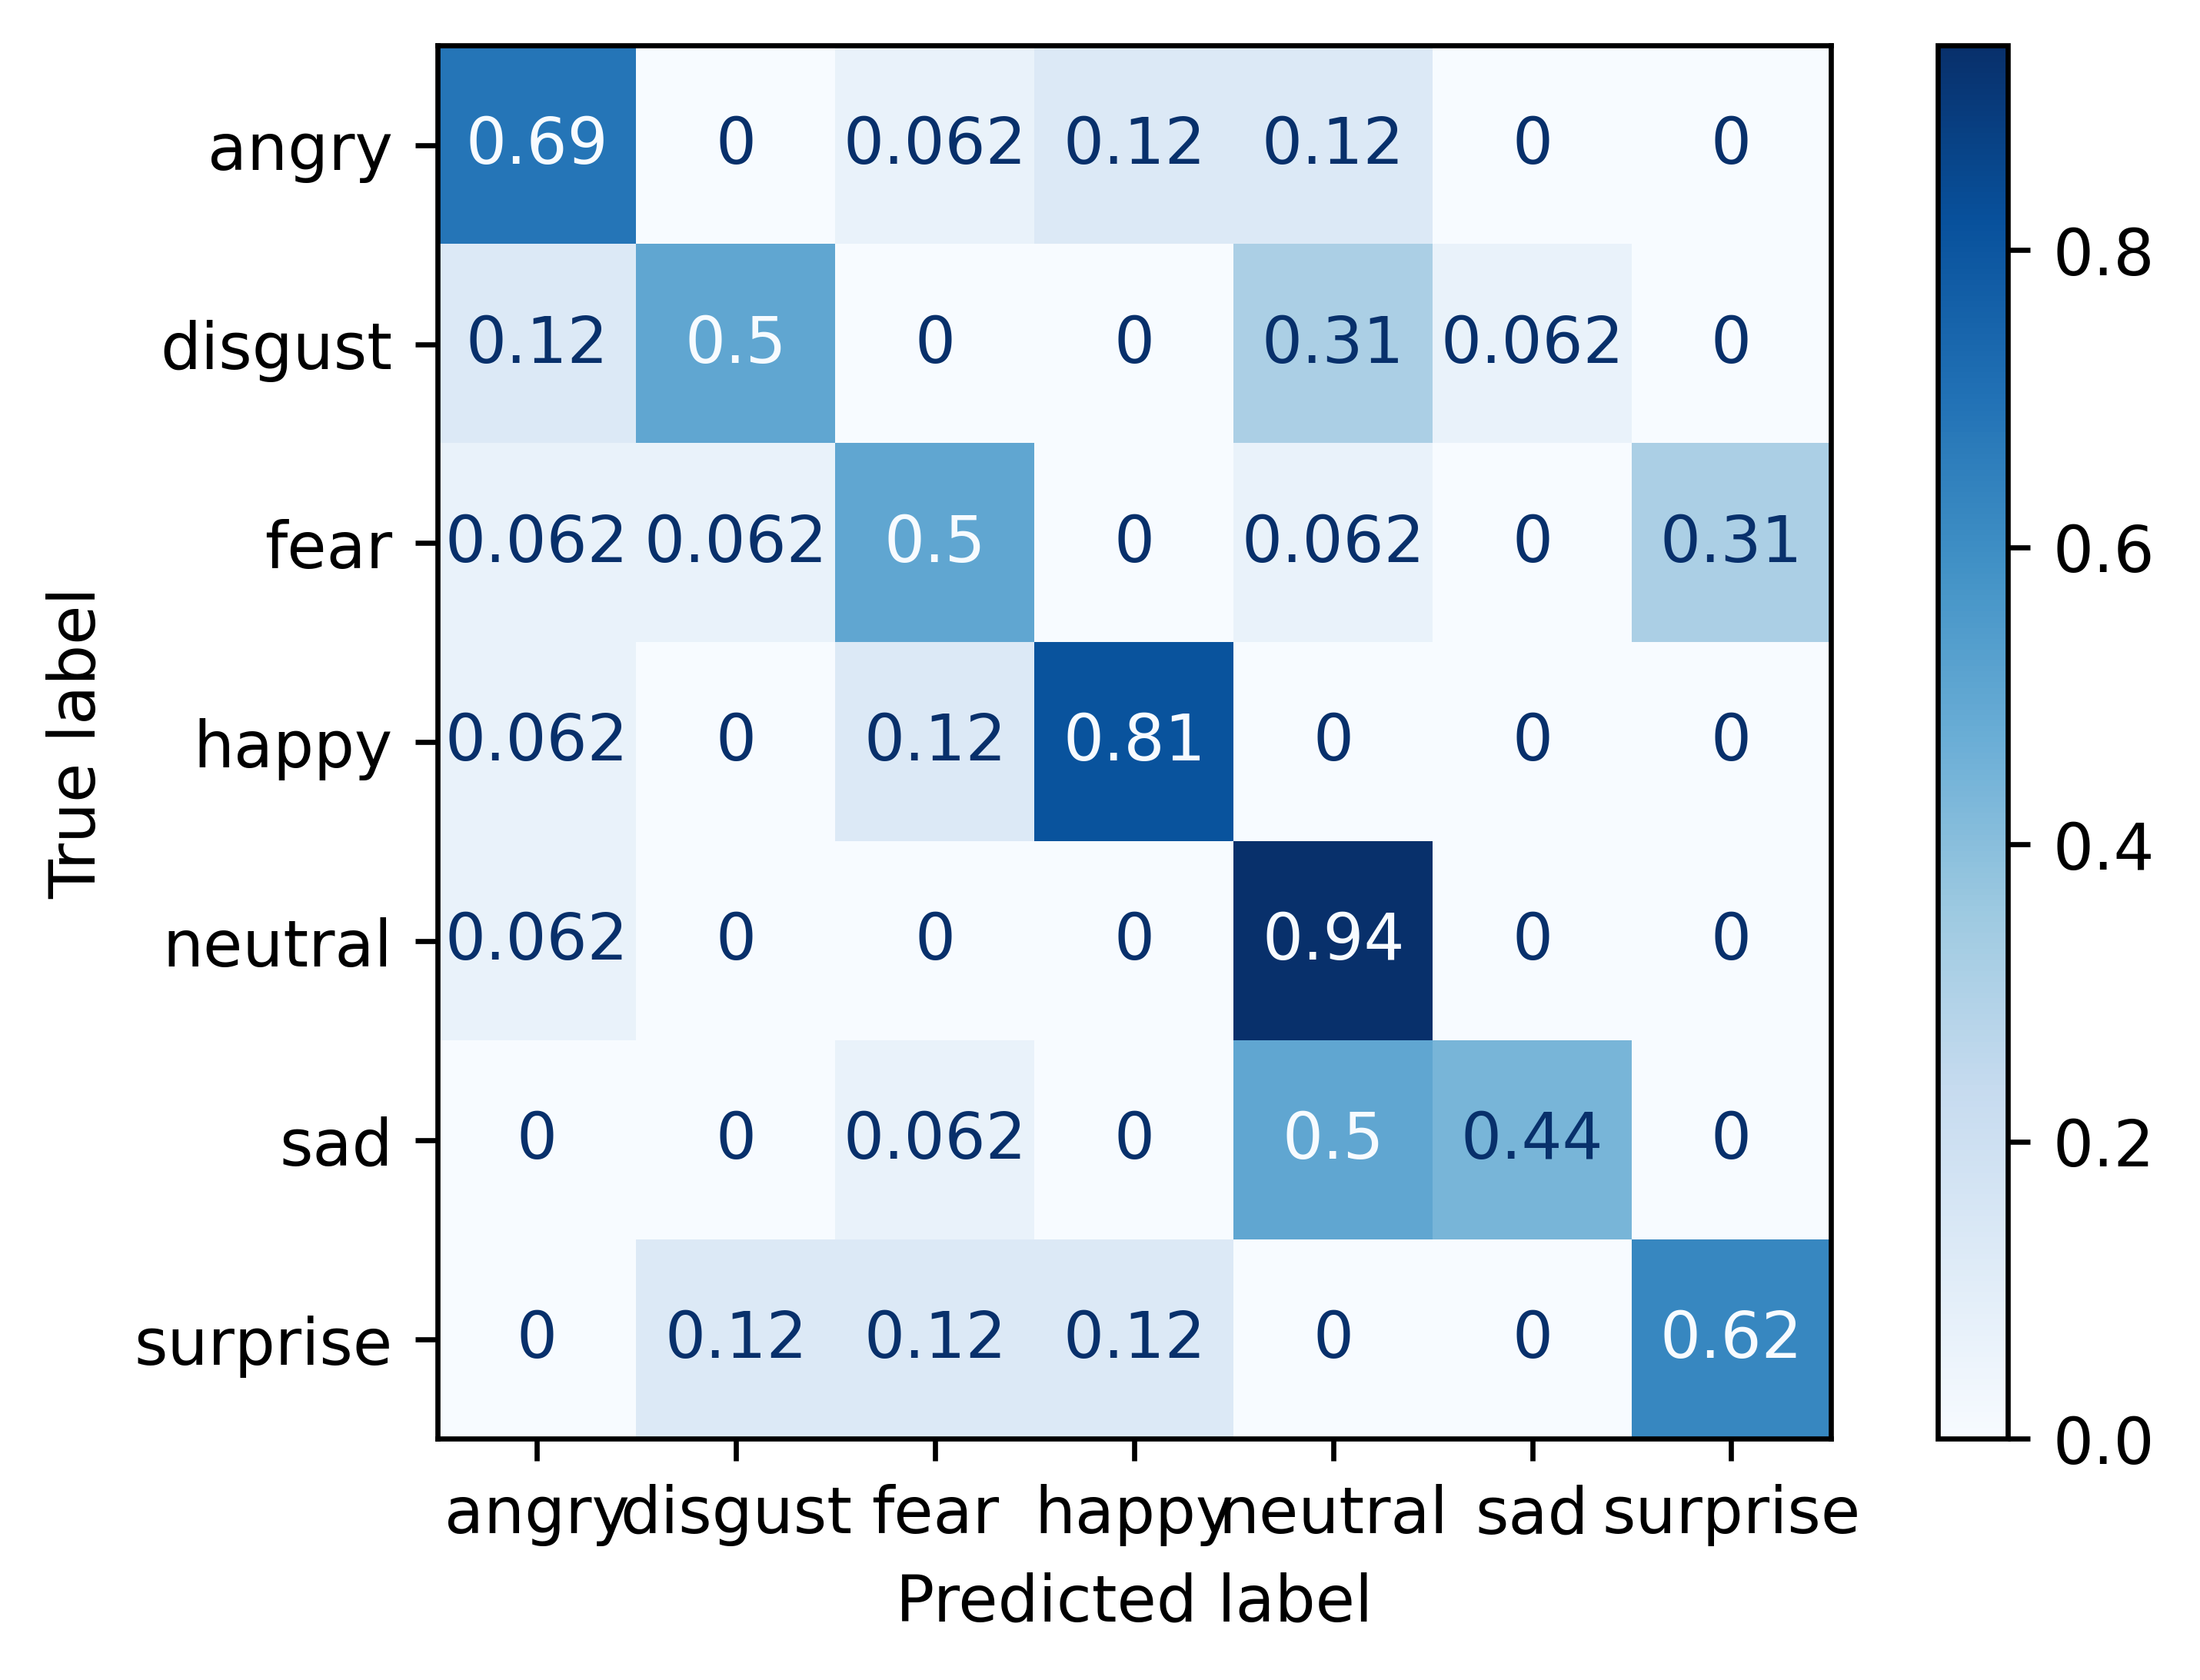

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    grid,
    X_test,
    y_test,
    display_labels=grid.classes_,
    cmap=plt.cm.Blues,
    normalize="true",
)


plt.show()

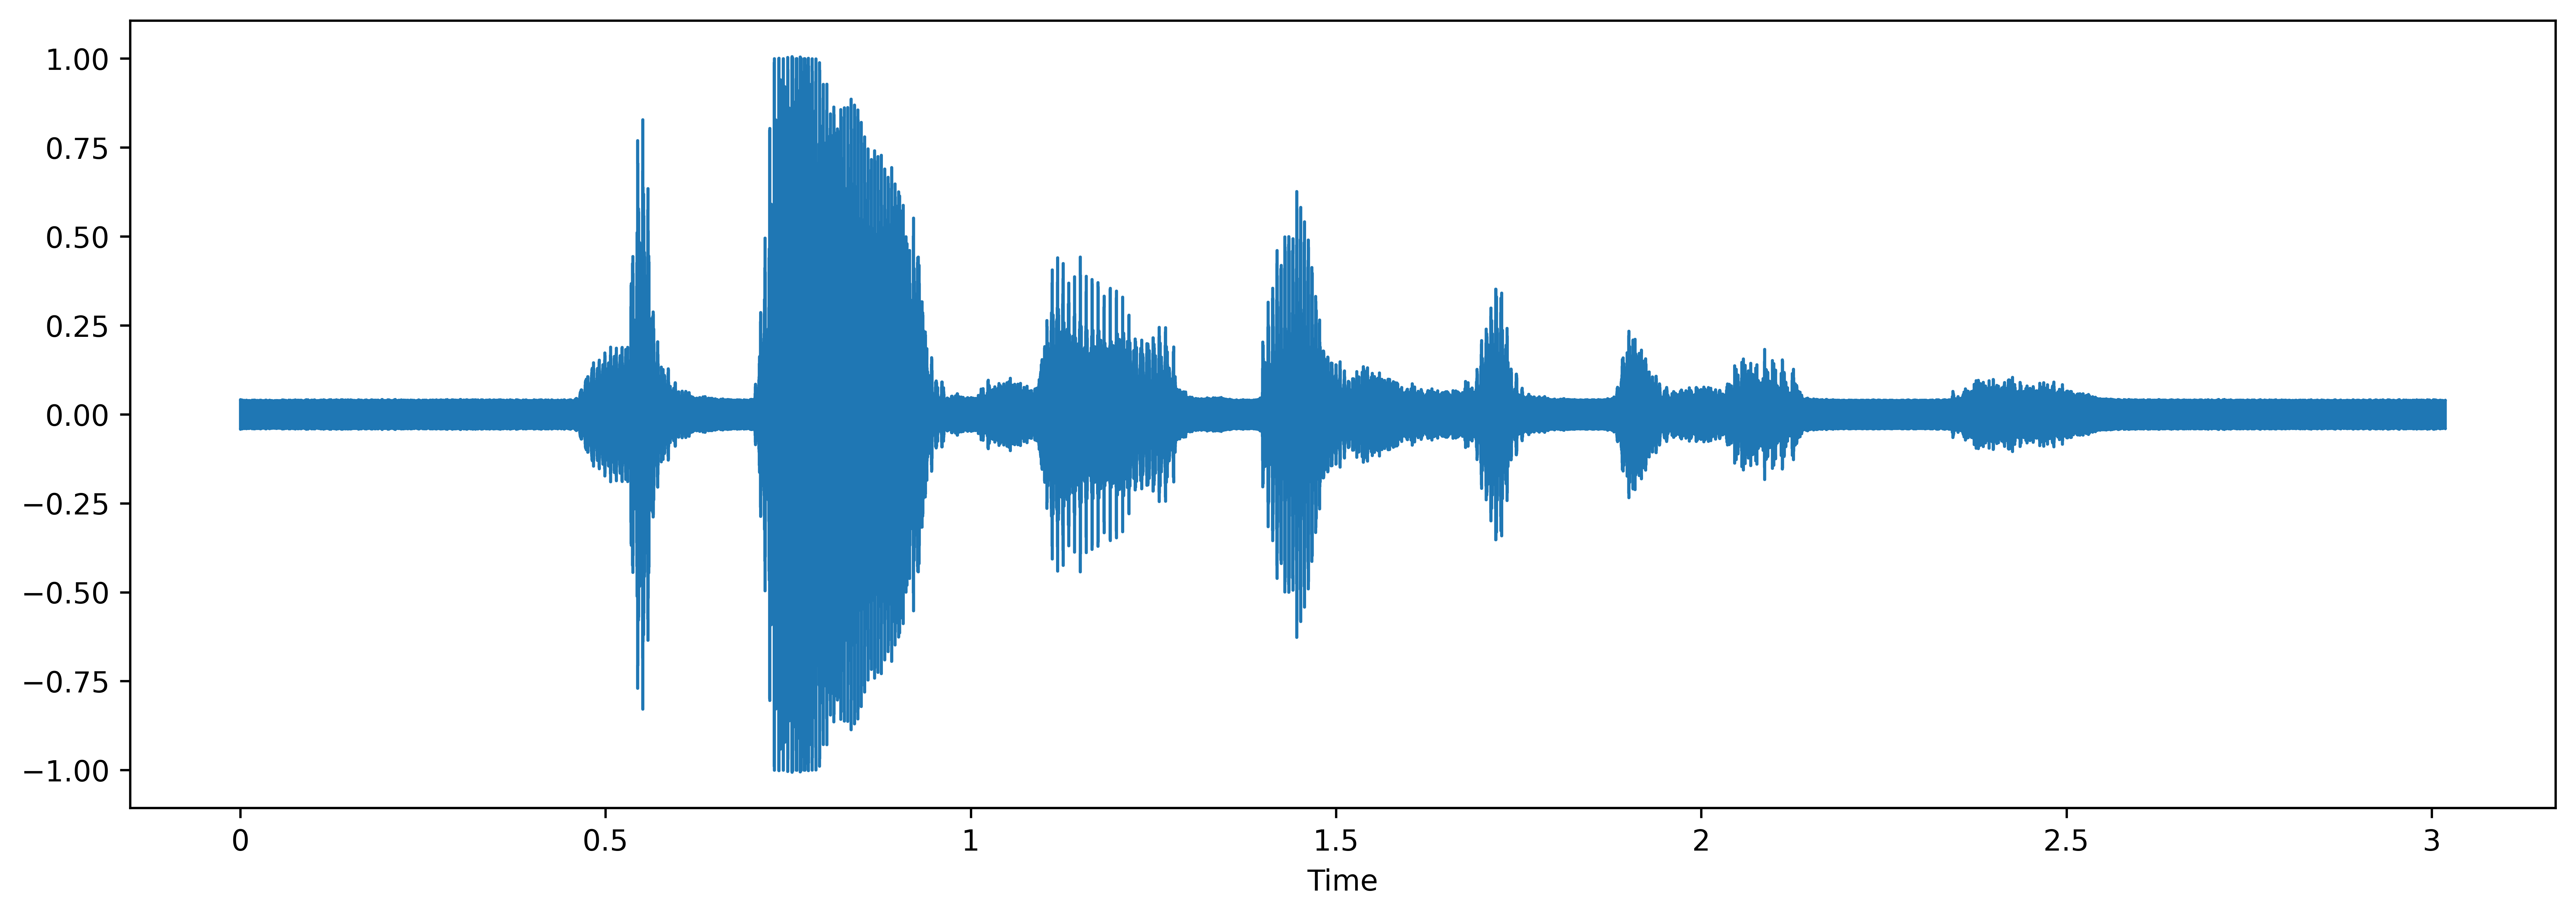

In [29]:
fname = pathToData + 'JK/d12.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

from IPython.display import Audio
Audio(fname)

# Extracting eGEMAPS features

In [59]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_

In [60]:
data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

In [12]:
max_length

157409

In [13]:
df

F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:03.647800454                          31.690620   
       0 days 00:00:03.438140590                          28.772612   
       0 days 00:00:02.075510204                          33.040432   
       0 days 00:00:02.725351474                          30.487244   
       0 days 00:00:02.997913832                          33.291603   
...                                                             ...   
       0 days 00:00:02.014058957                          27.562346   
       0 days 00:00:03.904263039                          30.002455   
       0 days 00:00:03.532380952                          29.030531   
       0 days 00:00:05.267619048                          30.206738   
       0 days 00:00:05.856326531                          28.763615   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:03.647800454                                0.193158   
       0 days 00:00:03.438140590                                0.080883   
       0 days 00:00:02.075510204                                0.066329   
       0 days 00:00:02.725351474                                0.132970   
       0 days 00:00:02.997913832                                0.259795   
...                                                                  ...   
       0 days 00:00:02.014058957                                0.191114   
       0 days 00:00:03.904263039                                0.252137   
       0 days 00:00:03.532380952                                0.132115   
       0 days 00:00:05.267619048                                0.171846   
       0 days 00:00:05.856326531                                0.138199   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:03.647800454                                   28.107164   
       0 days 00:00:03.438140590                                   27.163895   
       0 days 00:00:02.075510204                                   30.816153   
       0 days 00:00:02.725351474                                   28.136459   
       0 days 00:00:02.997913832                                   28.409826   
...                                                                      ...   
       0 days 00:00:02.014058957                                   22.882248   
       0 days 00:00:03.904263039                                   24.706116   
       0 days 00:00:03.532380952                                   26.259939   
       0 days 00:00:05.267619048                                   26.295231   
       0 days 00:00:05.856326531                                   25.909344   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:03.647800454                                   30.903860   
       0 days 00:00:03.438140590                                   28.446823   
       0 days 00:00:02.075510204                                   33.548027   
       0 days 00:00:02.725351474                                   31.113623   
       0 days 00:00:02.997913832                                   31.066219   
...                                                                      ...   
       0 days 00:00:02.014058957                                   27.465769   
       0 days 00:00:03.904263039                                   28.158140   
       0 days 00:00:03.532380952                                   29.930410   
       0 days 00:00:05.267619048                                   29.513065   
       0 days 00:00:05.856326531                                   29.273426   

                                  F0sem

We have extracted all the functionals for all the signal. Now, we need to split the data into training and validation.

In [61]:
X = df.to_numpy() #no_of_samples x 88

In [62]:
y = file_emotion

In [15]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y, speaker_identity, test_size=0.33, random_state=42)

In [16]:
#dict(collections.Counter(y_train))
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([67, 90, 75, 89])

Text(0.5, 1.0, 'Histogram of the speakers in the Training data')

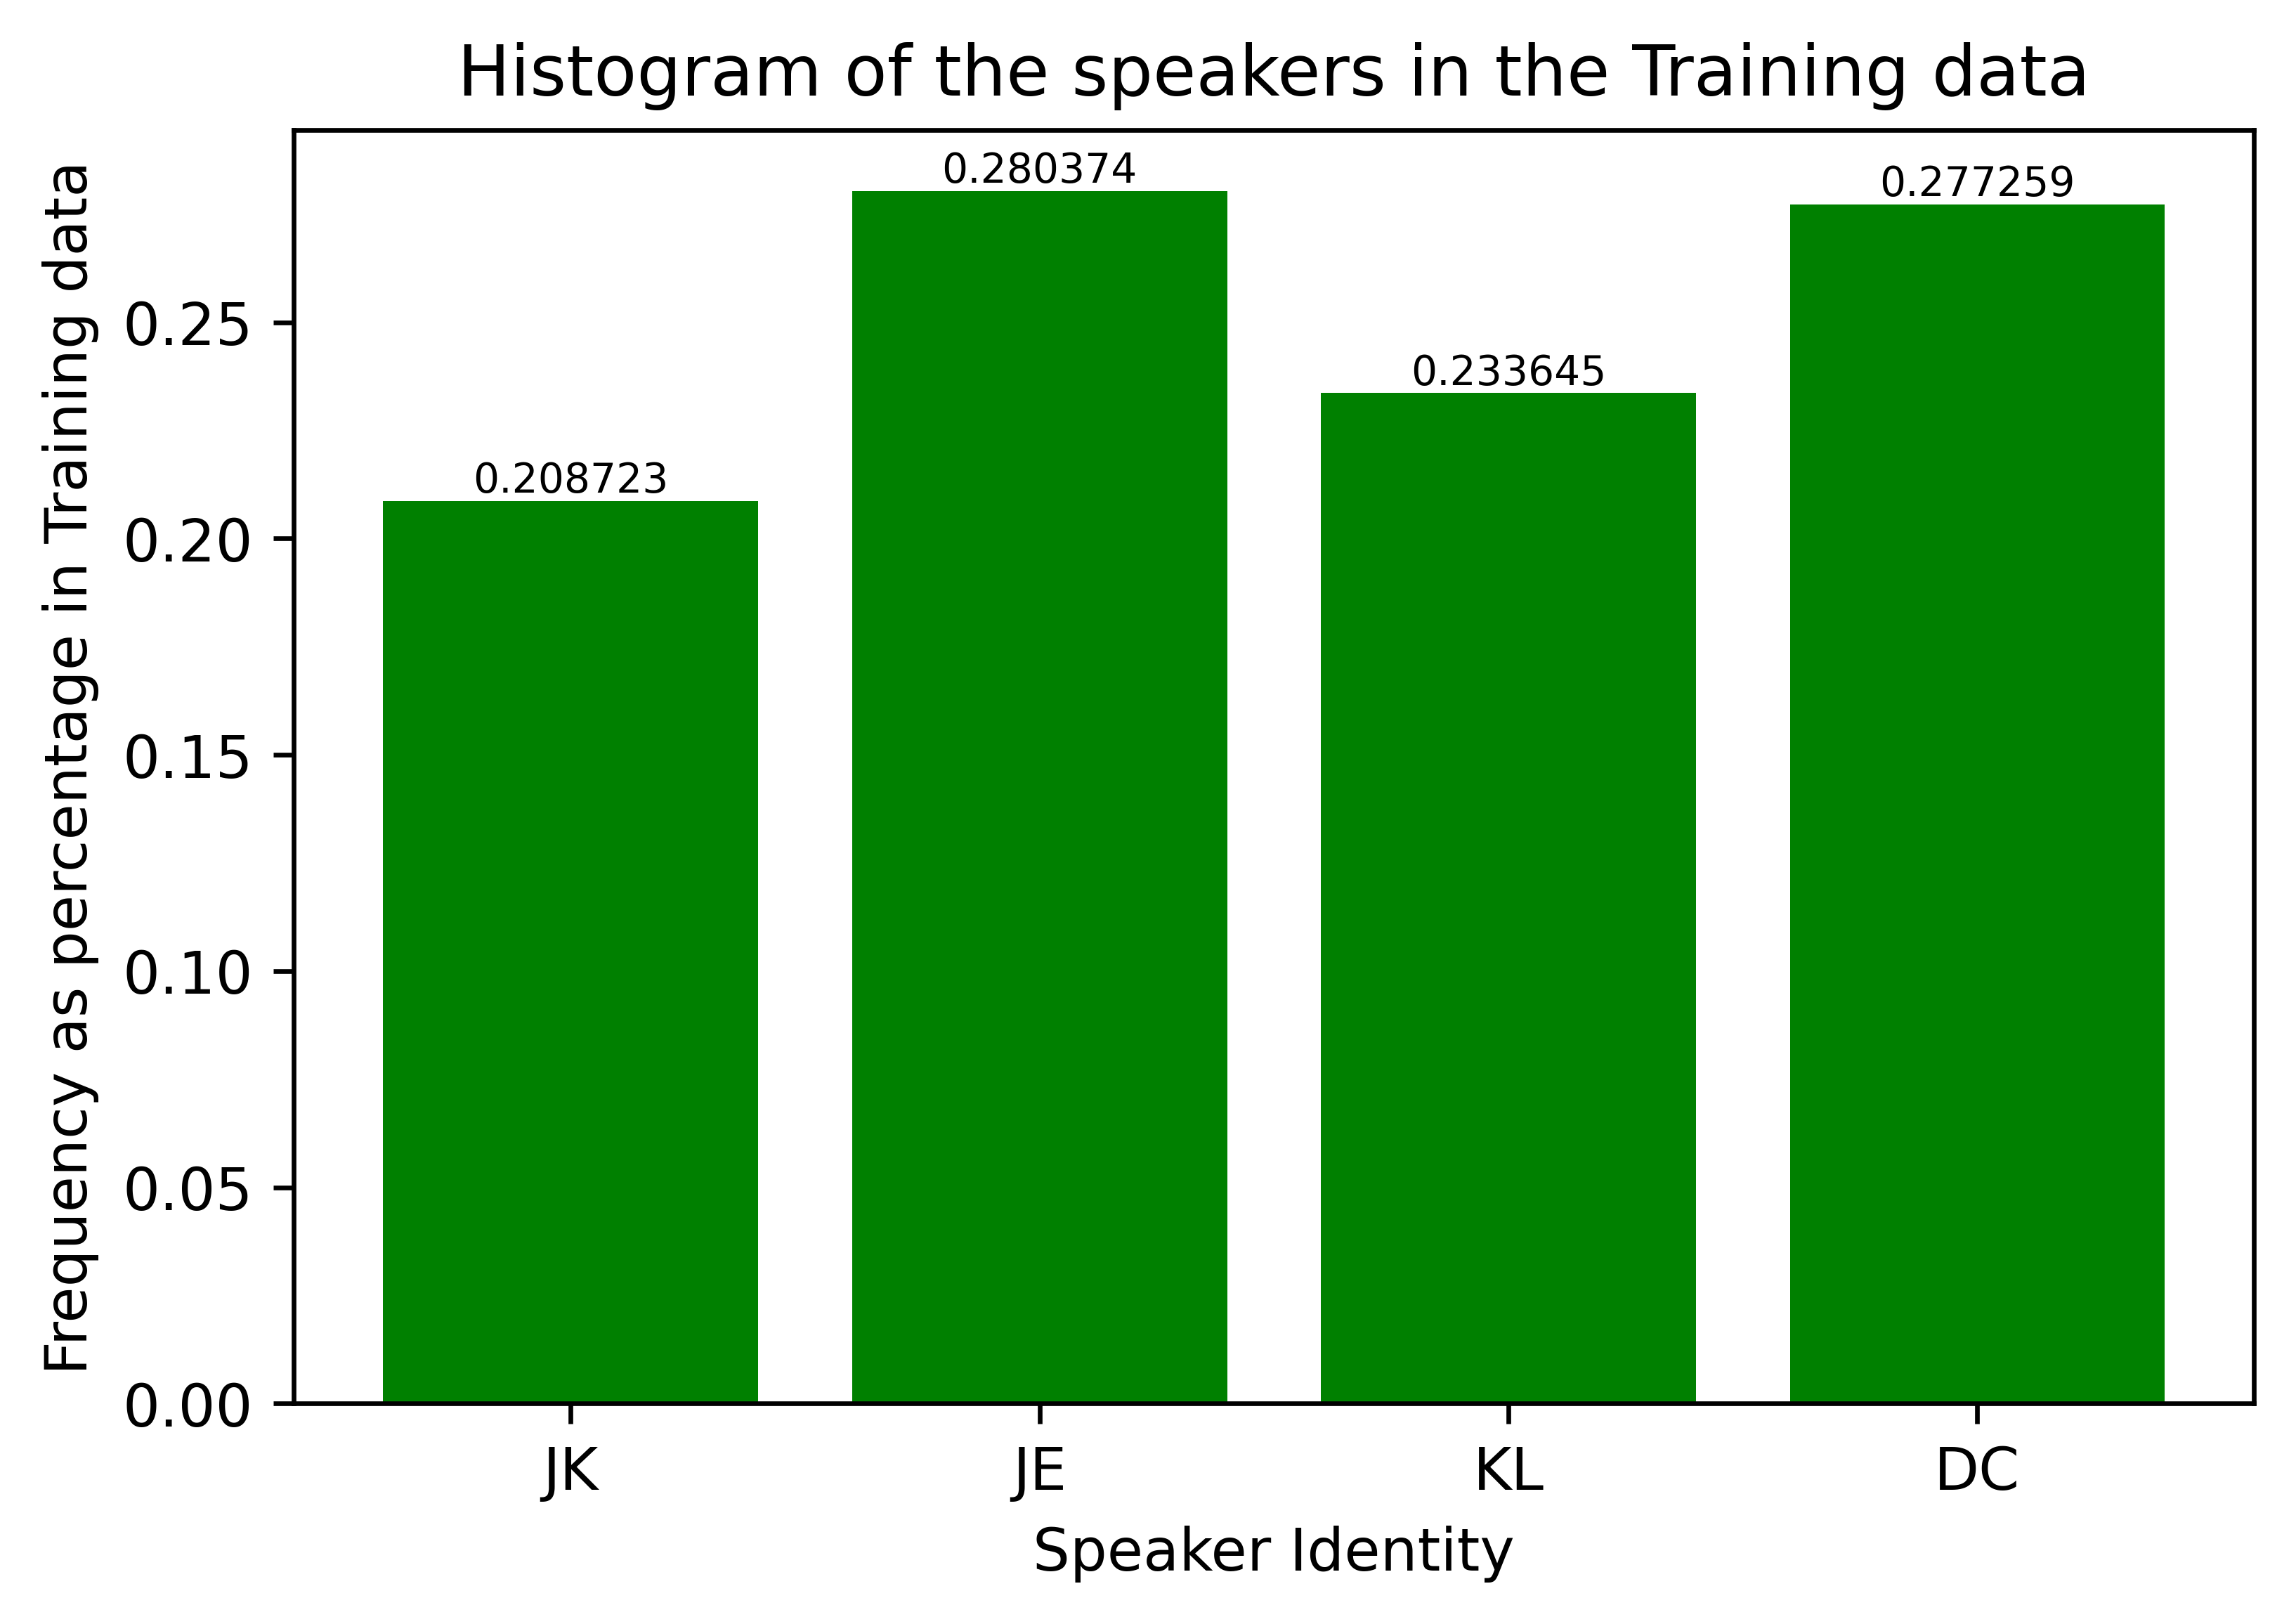

In [ ]:
matplotlib.rcParams["figure.dpi"] = 600
bar = plt.bar(speaker_hist_train.keys(), np.array([i for i in speaker_hist_train.values()])/(sum(speaker_hist_train.values())), color='g')
plt.bar_label(bar, fontsize = 7)
plt.xlabel("Speaker Identity")
plt.ylabel("Frequency as percentage in Training data")
plt.title("Histogram of the speakers in the Training data")

In [ ]:
speaker_hist_test = dict(collections.Counter(speaker_identity_test))
speaker_hist_test.values()

dict_values([53, 45, 30, 31])

Text(0.5, 1.0, 'Histogram of the speakers in the Testing data')

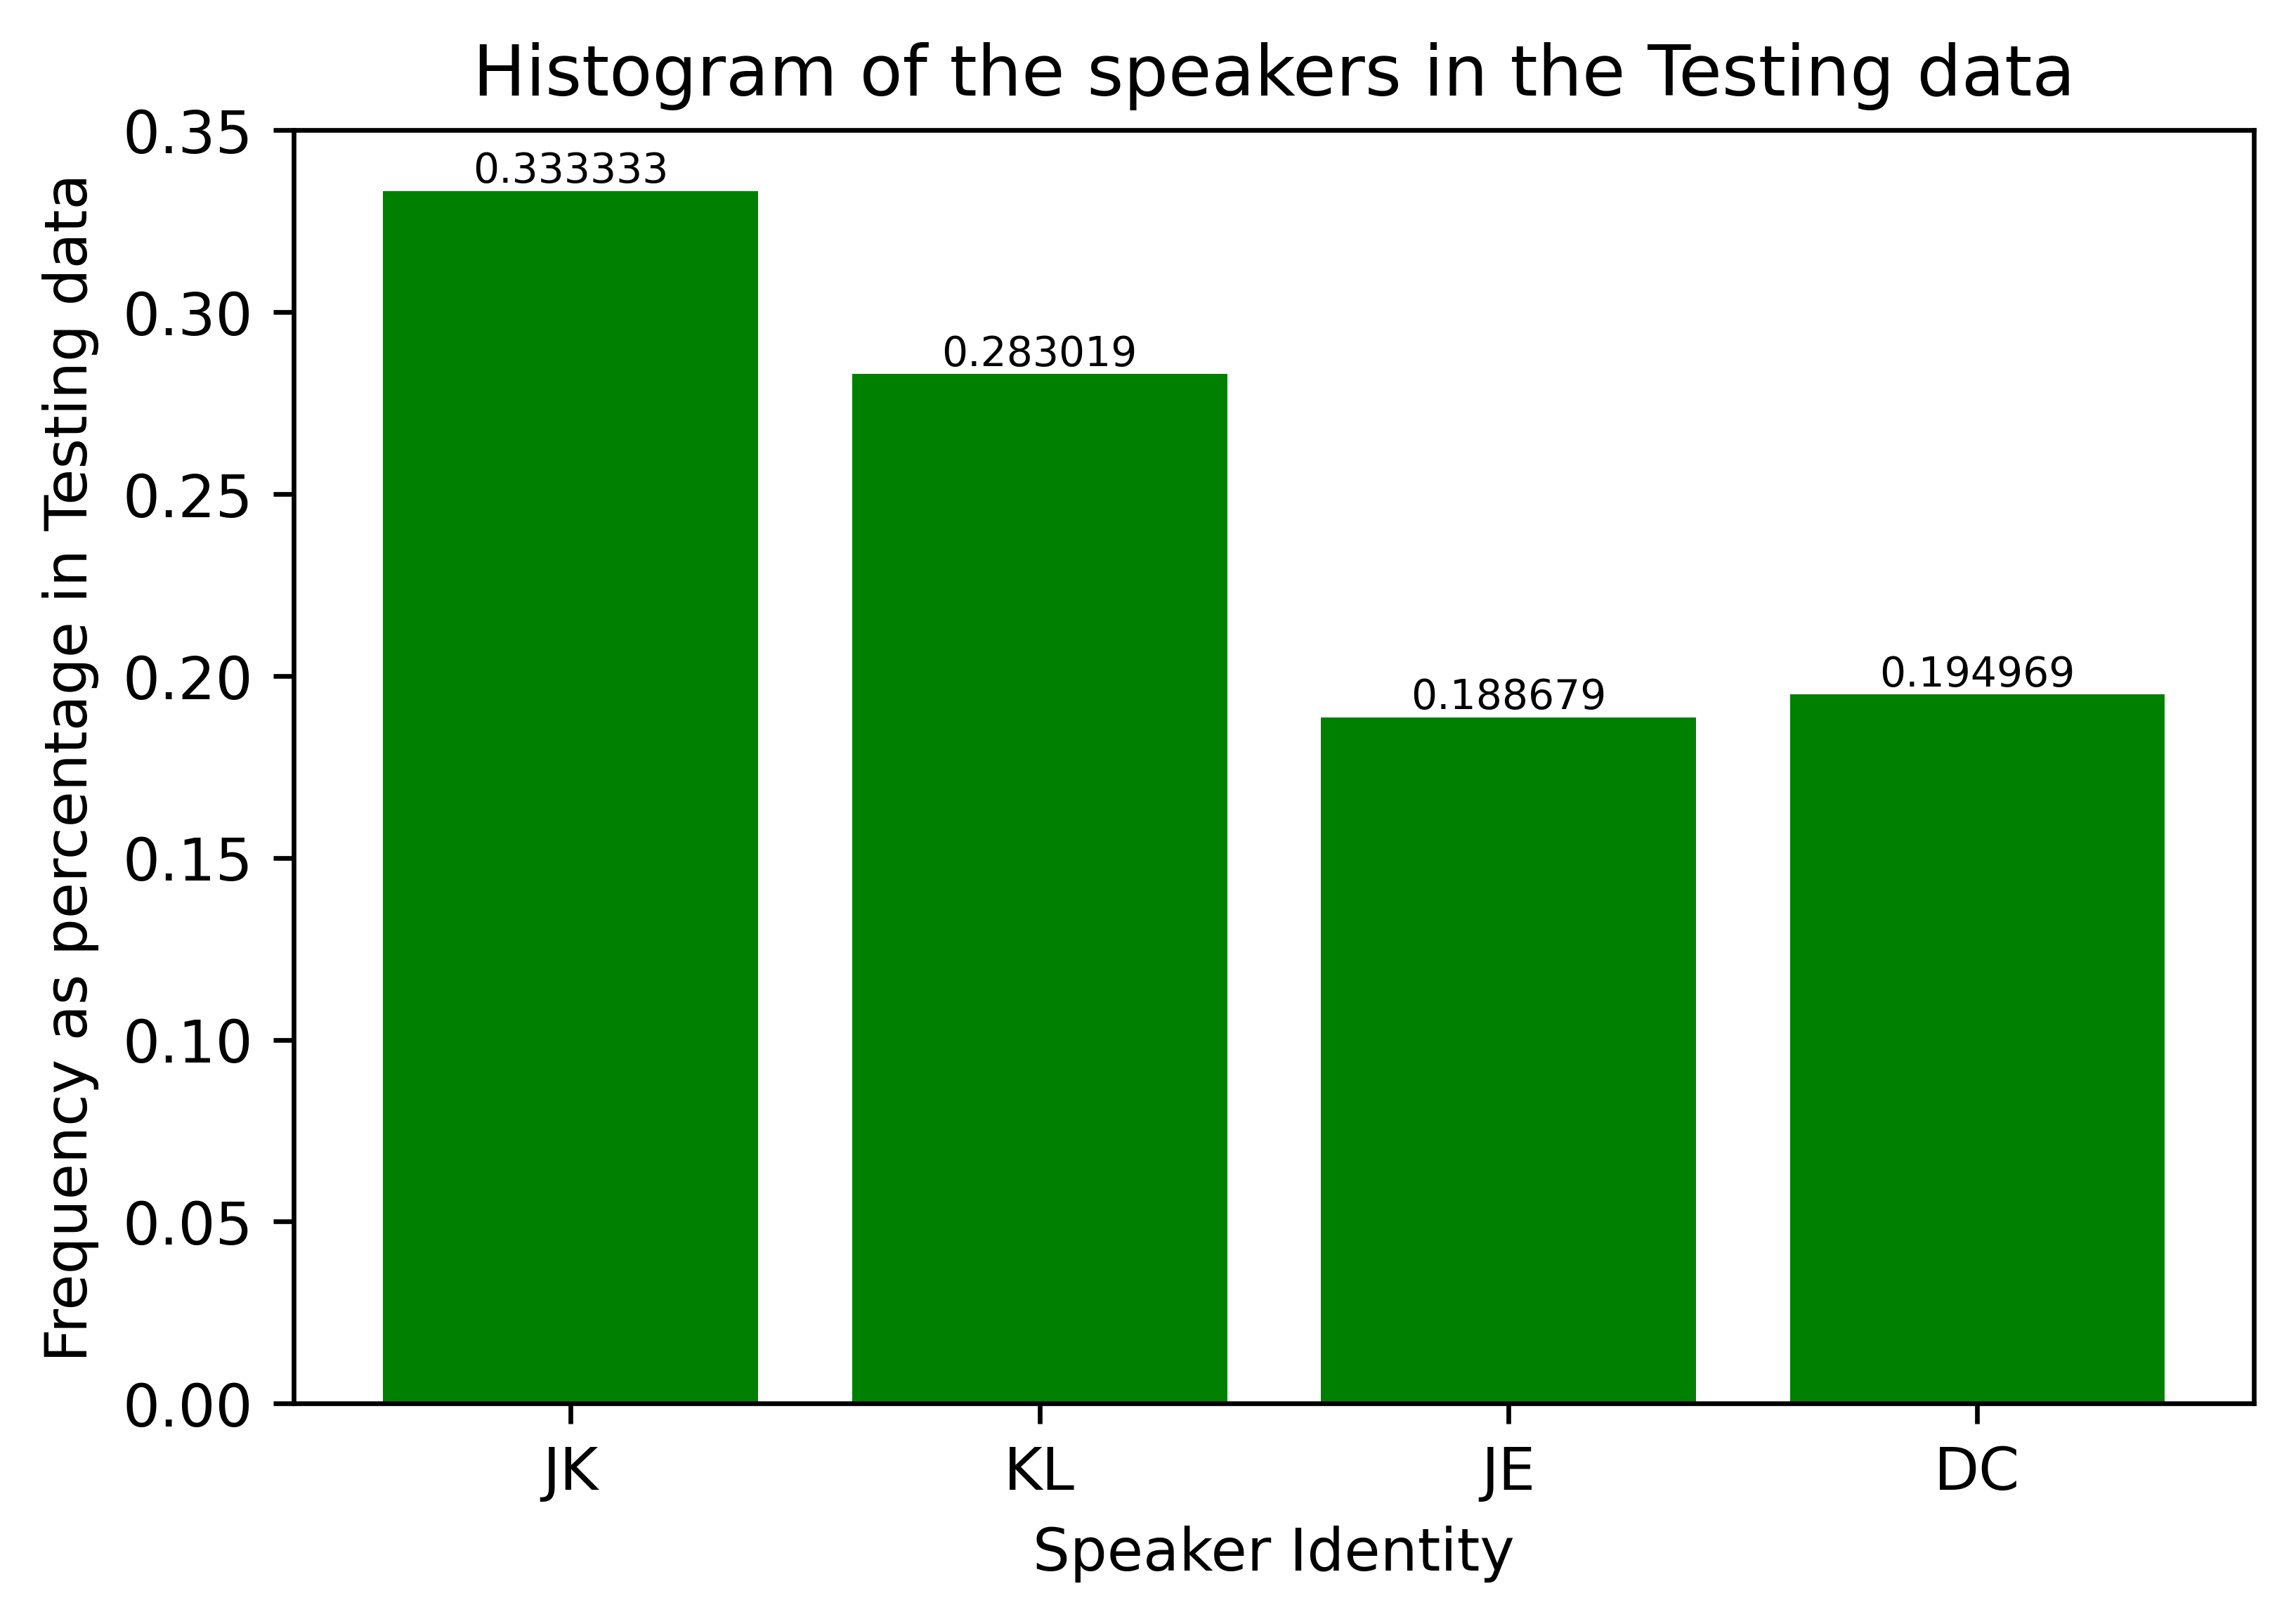

In [ ]:
matplotlib.rcParams["figure.dpi"] = 600
bar = plt.bar(speaker_hist_test.keys(), np.array([i for i in speaker_hist_test.values()])/(sum(speaker_hist_test.values())), color='g')
plt.bar_label(bar, fontsize = 7)
plt.xlabel("Speaker Identity")
plt.ylabel("Frequency as percentage in Testing data")
plt.title("Histogram of the speakers in the Testing data")

In [ ]:
emo_hist_total =  dict(collections.Counter(y))
emo_hist_total.values()

dict_values([60, 60, 60, 60, 60, 60, 120])

Text(0.5, 1.0, 'Histogram of the emotion data in the entire dataset \n (before splitting dataset)')

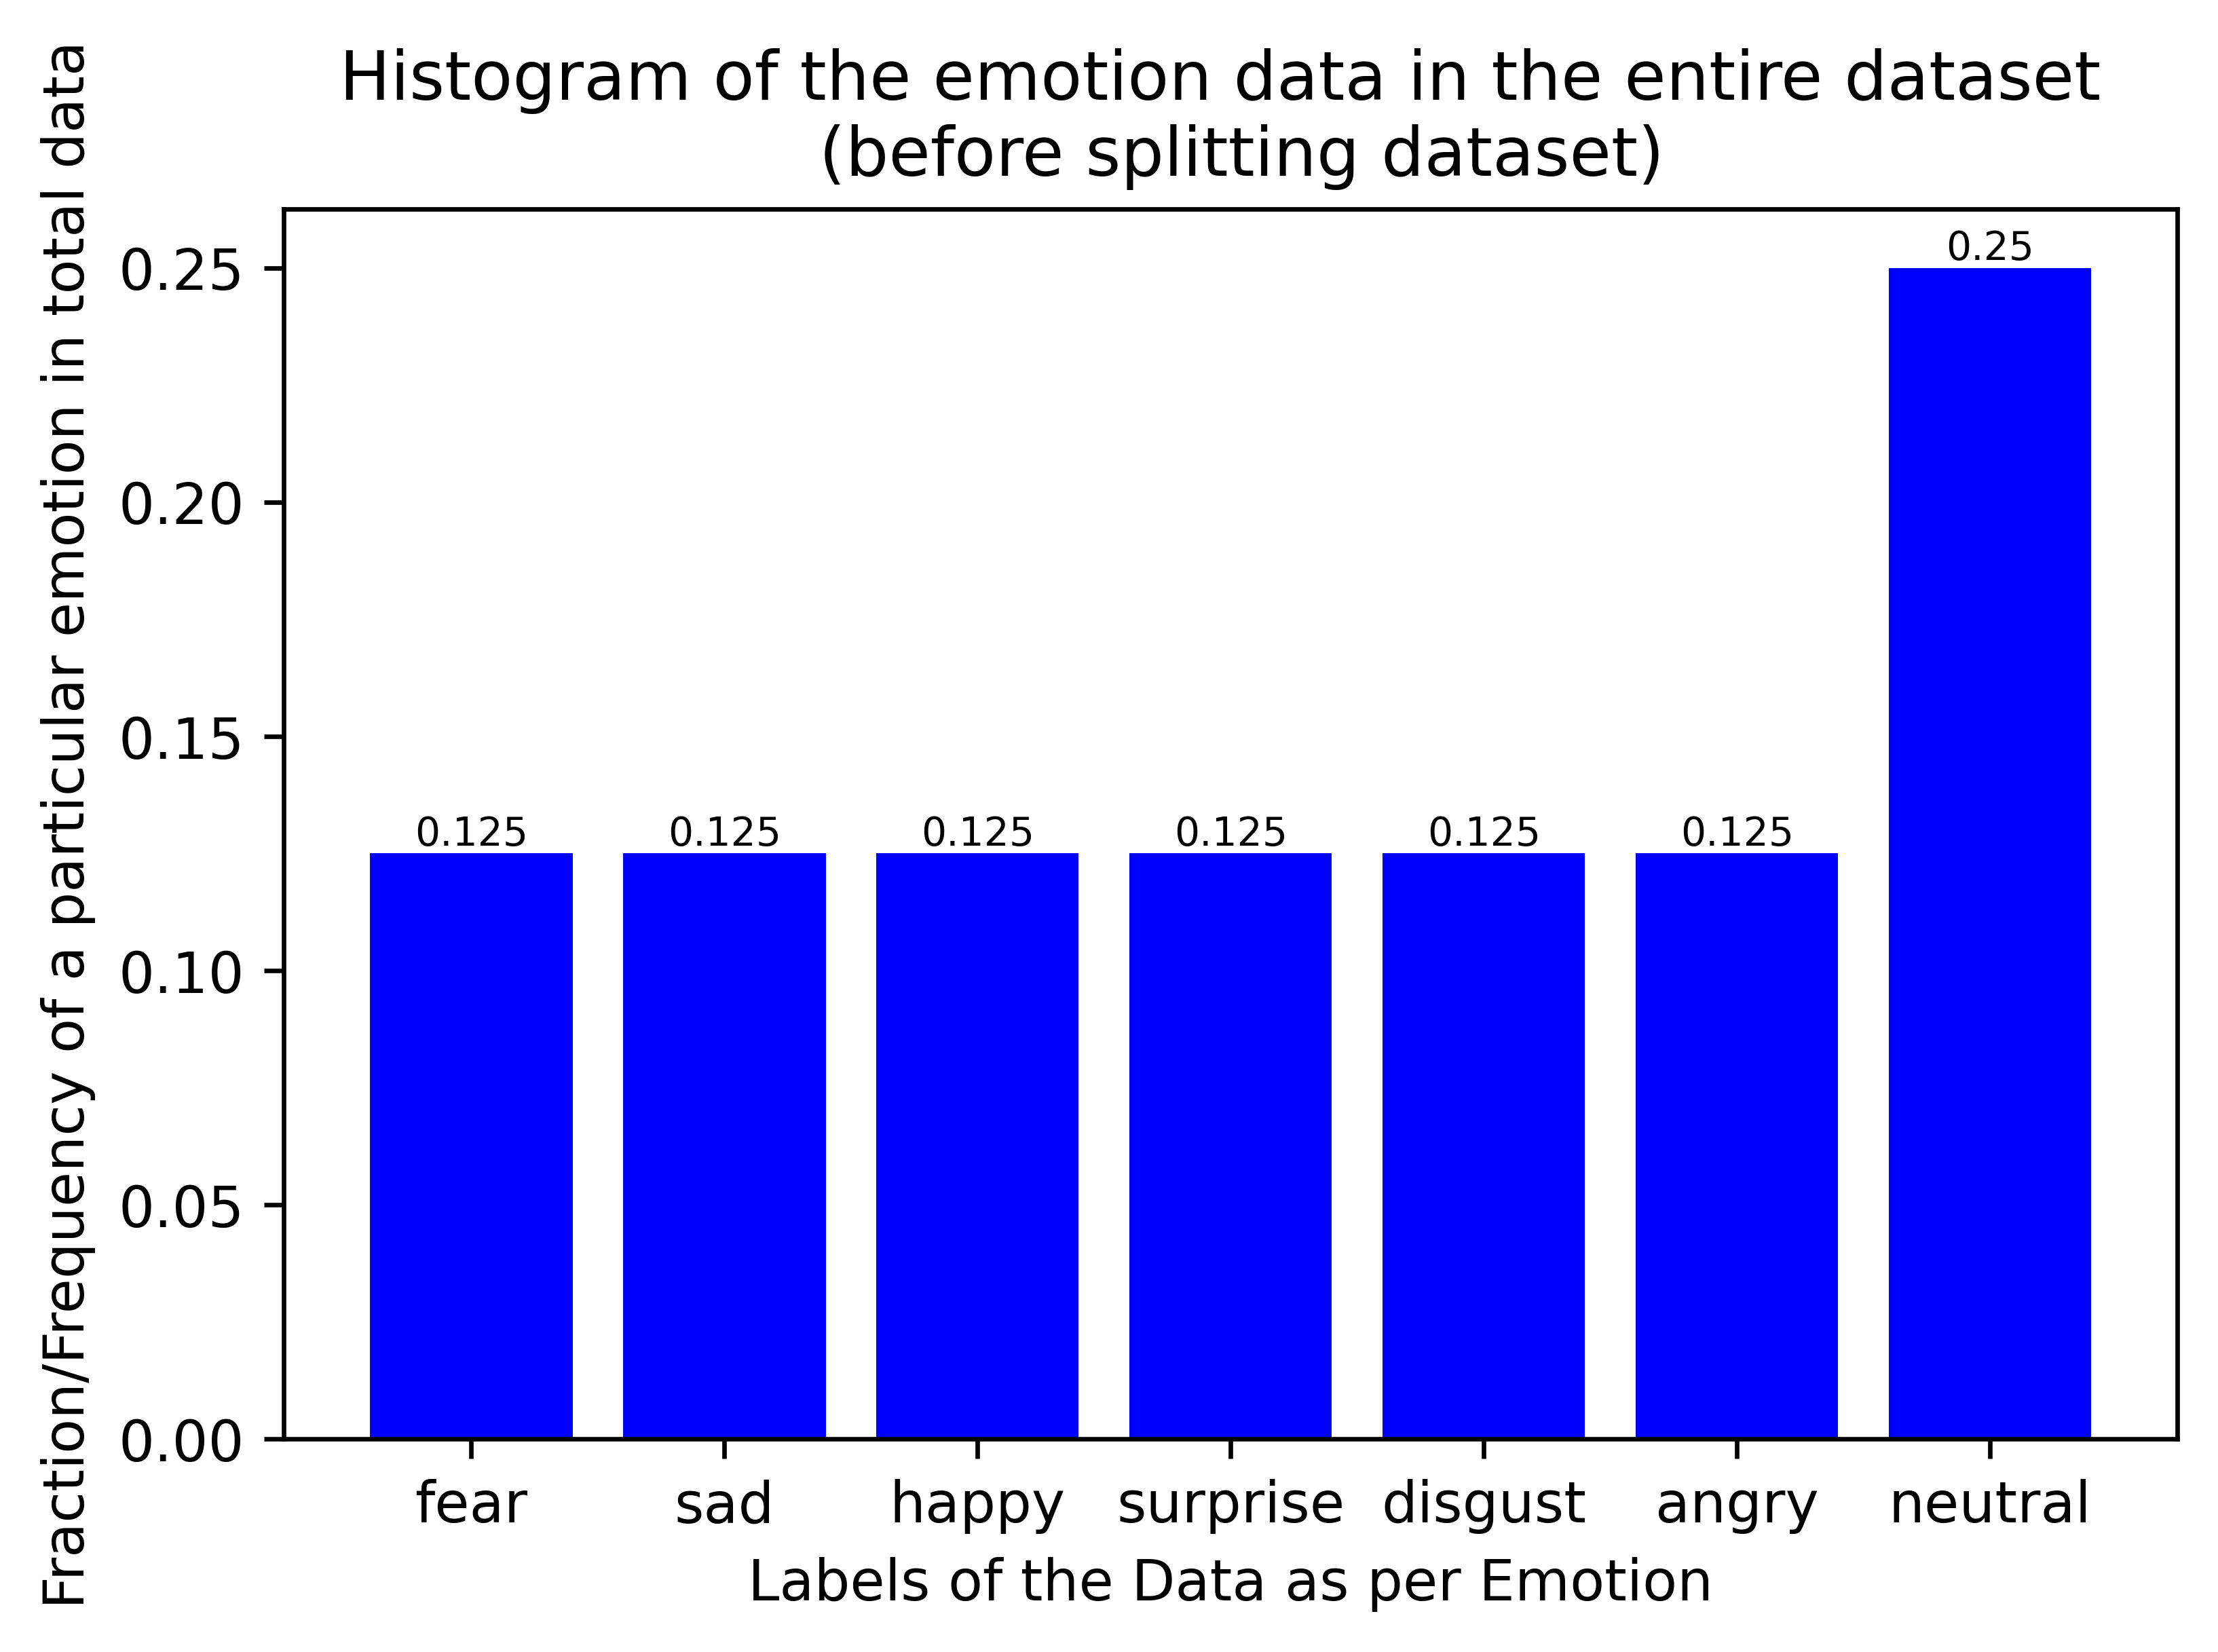

In [ ]:
bar = plt.bar(emo_hist_total.keys(), np.array([i for i in emo_hist_total.values()])/(sum(emo_hist_total.values())), color='b')
plt.bar_label(bar, fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion in total data")
plt.title("Histogram of the emotion data in the entire dataset \n (before splitting dataset)")

In [ ]:
emo_hist_train = dict(collections.Counter(y_train))
emo_hist_train.values()

dict_values([35, 35, 43, 49, 44, 73, 42])

Text(0.5, 1.0, 'Histogram of the emotion data in the training data')

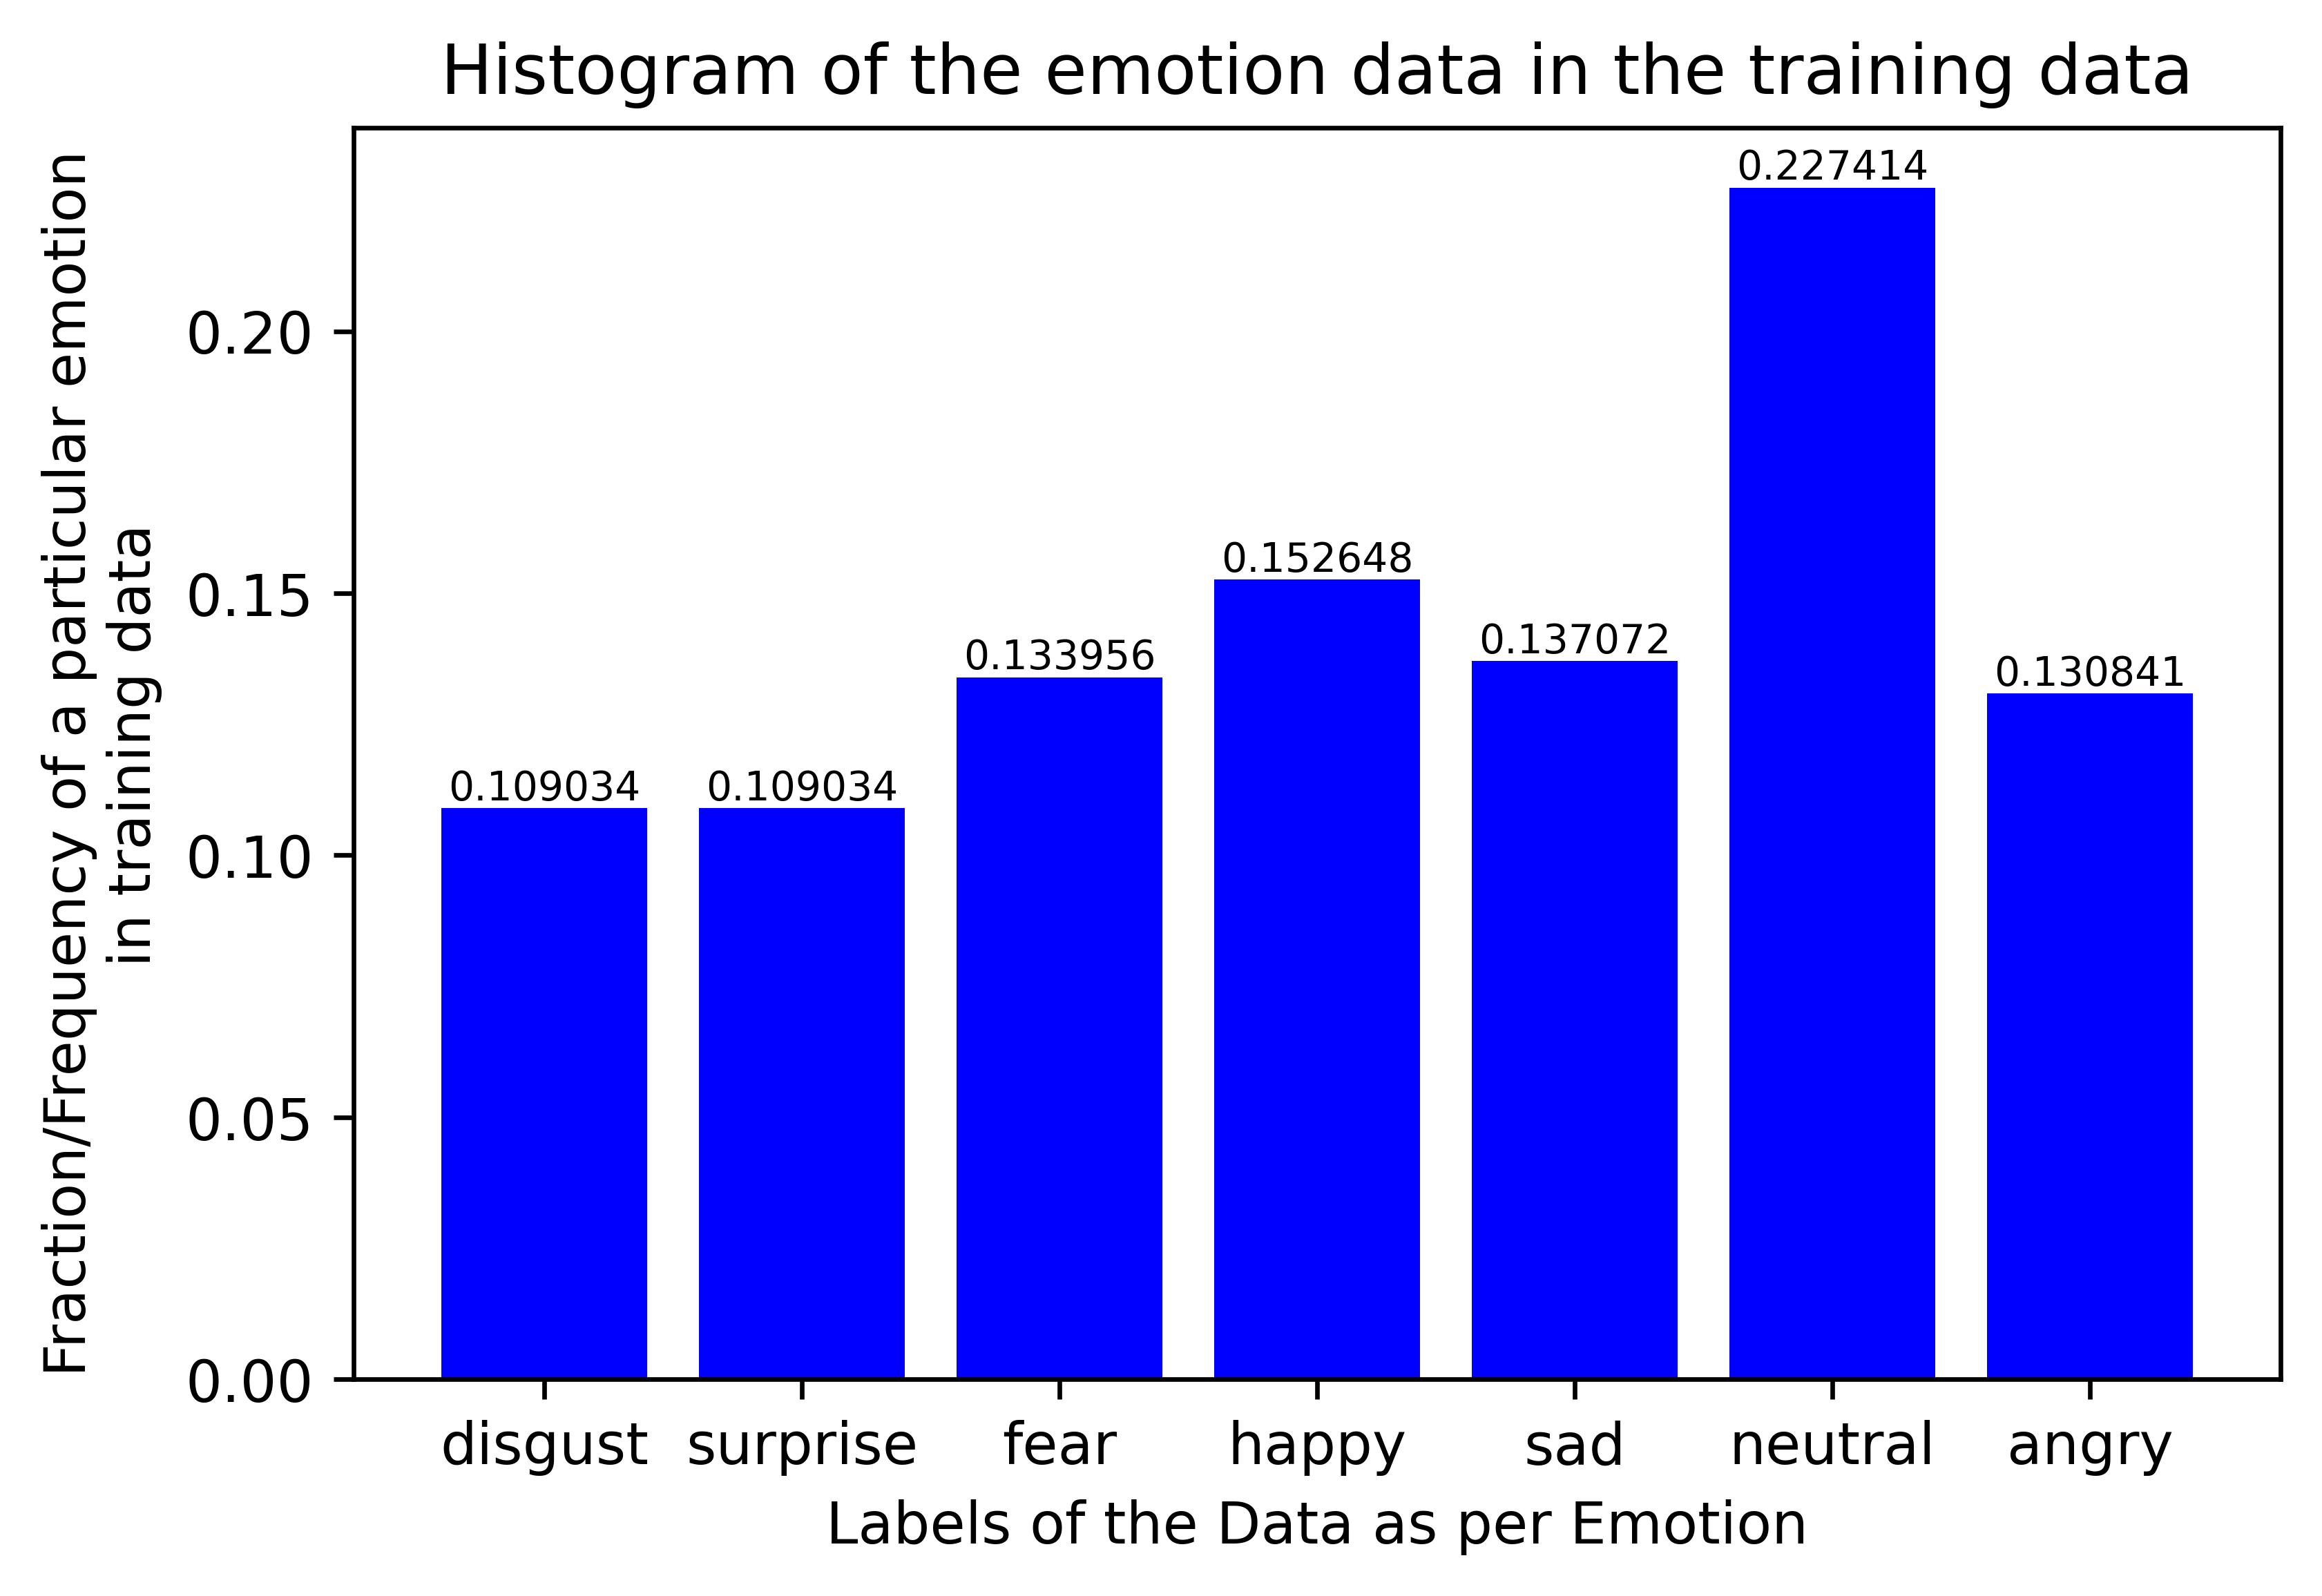

In [ ]:
bar = plt.bar(emo_hist_train.keys(), np.array([i for i in emo_hist_train.values()])/(sum(emo_hist_train.values())), color='b')
plt.bar_label(bar, fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion \n in training data")
plt.title("Histogram of the emotion data in the training data")

In [ ]:
emo_hist_test = dict(collections.Counter(y_test))
emo_hist_test.values()

dict_values([25, 11, 25, 47, 18, 16, 17])

Text(0.5, 1.0, 'Histogram of the emotion data in the Testing data')

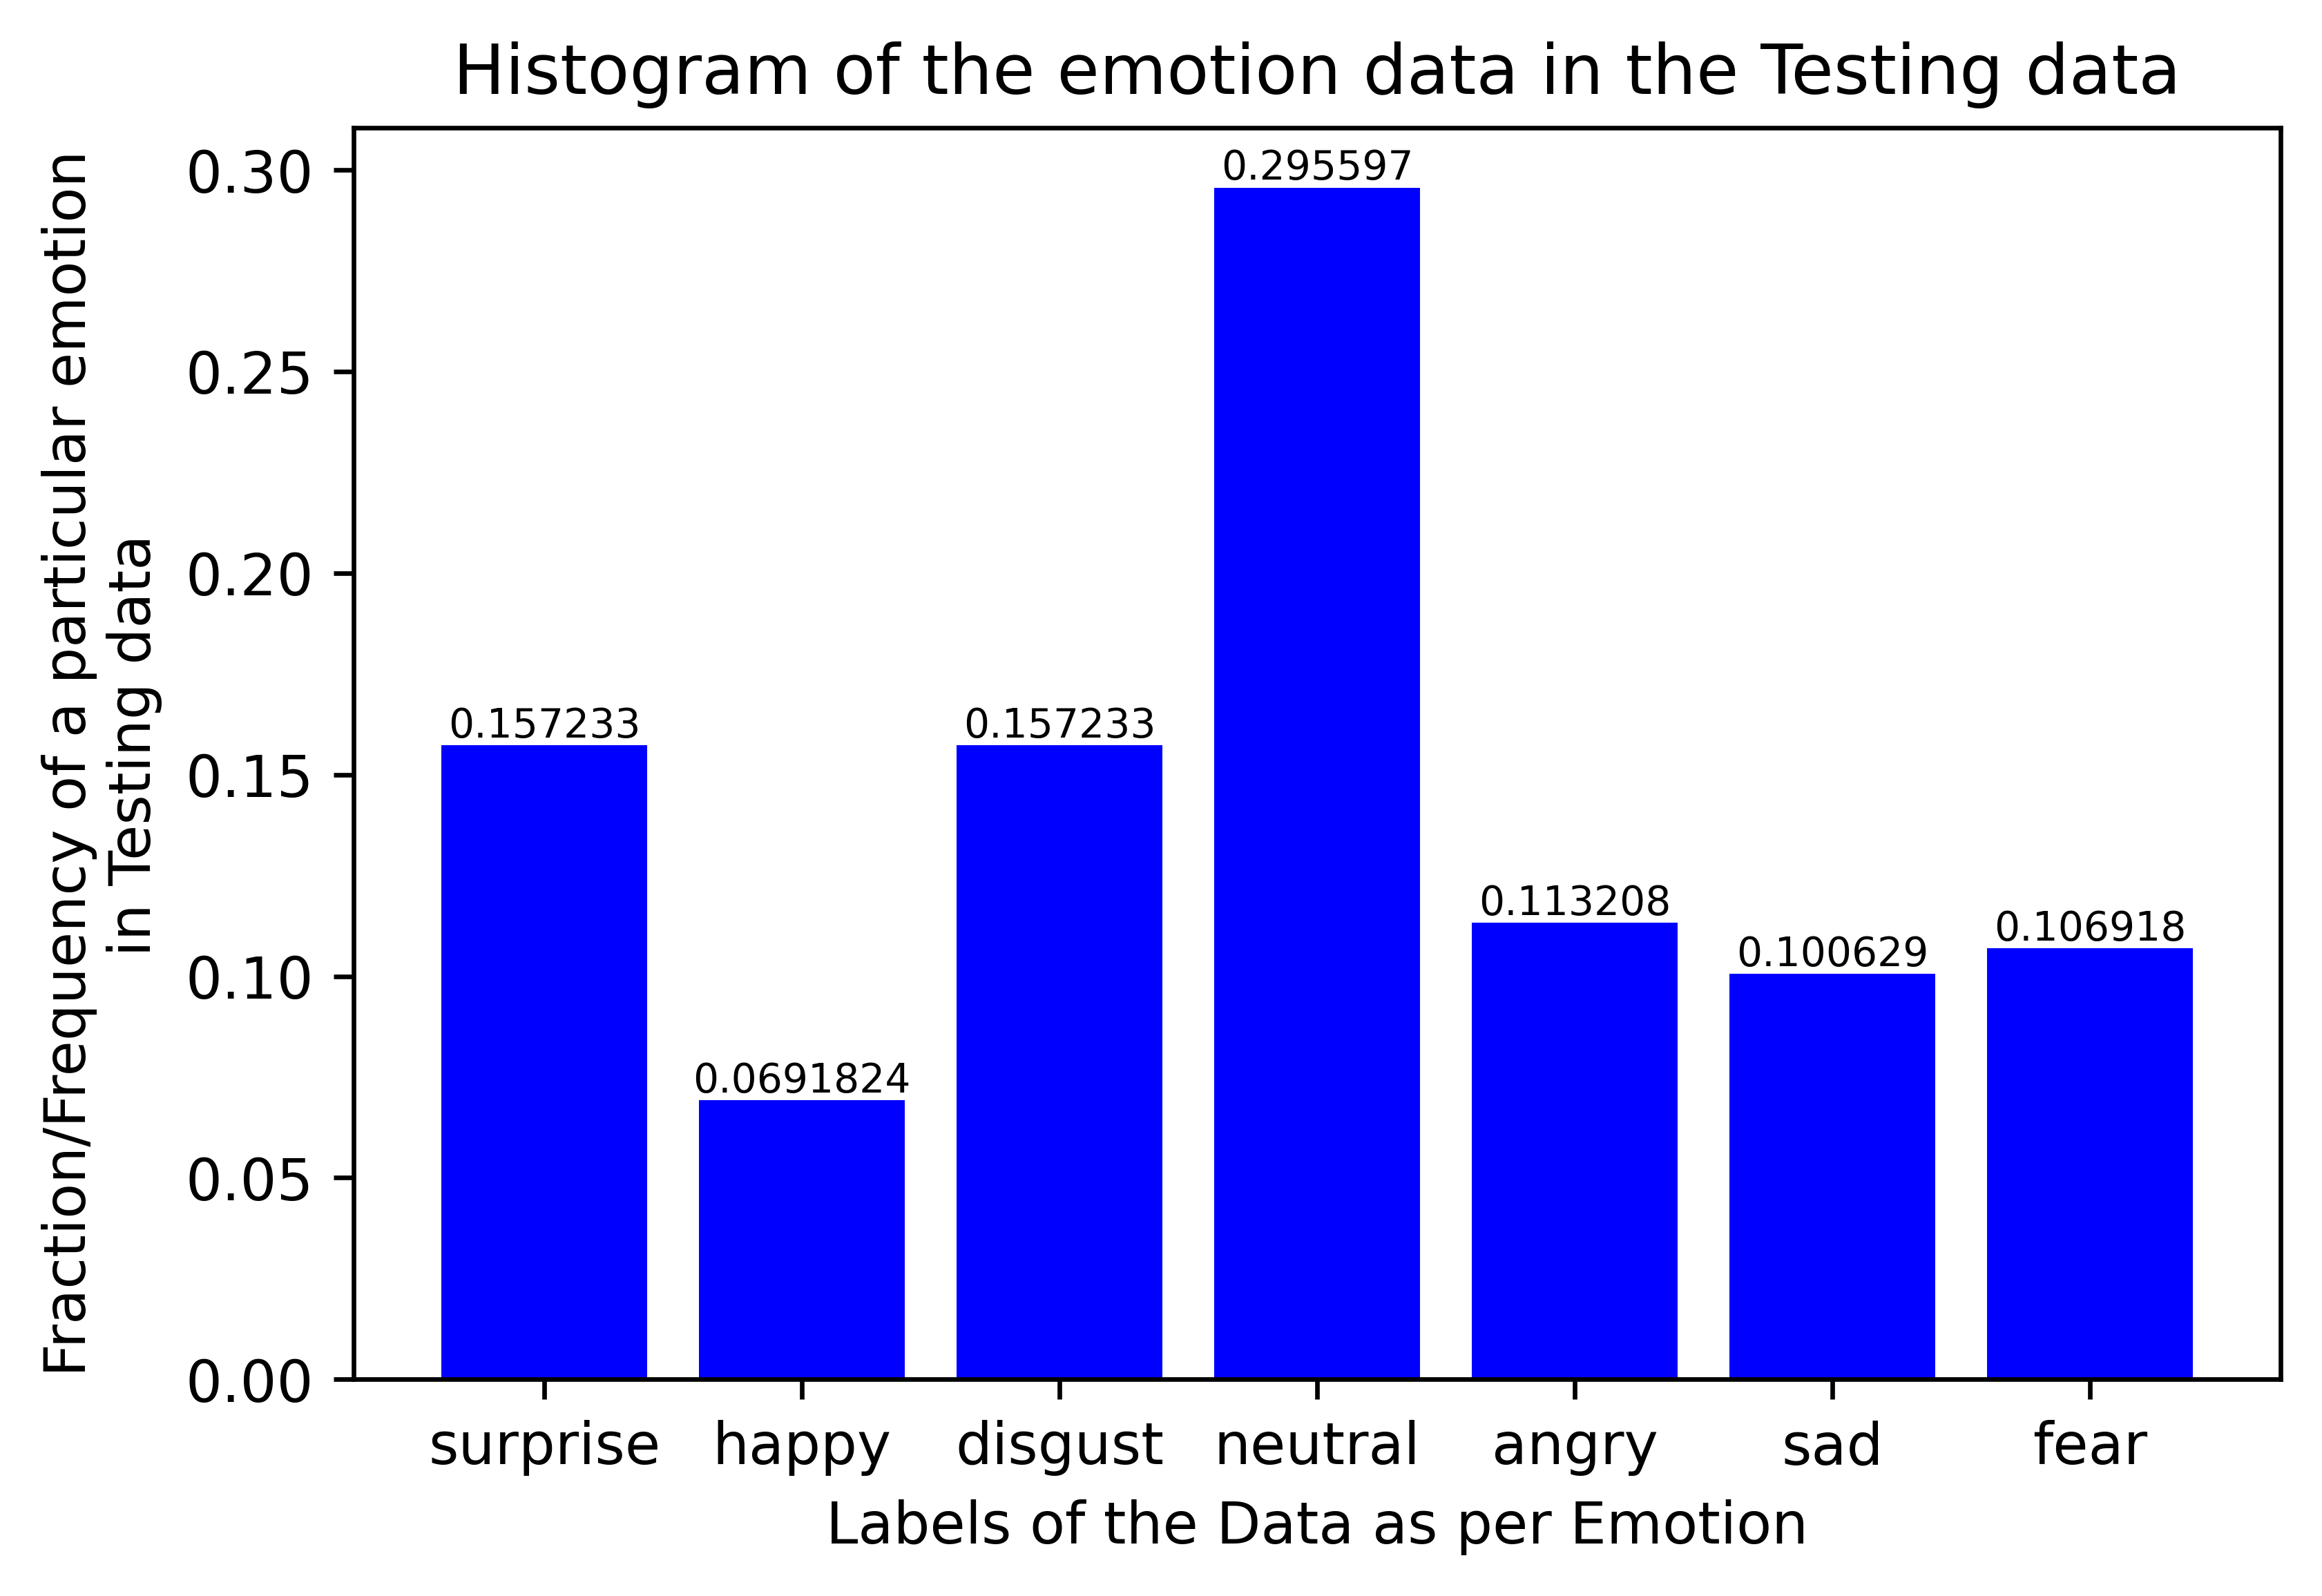

In [ ]:
bar = plt.bar(emo_hist_test.keys(), np.array([i for i in emo_hist_test.values()])/(sum(emo_hist_test.values())), color='b')
plt.bar_label(bar, fontsize = 7)
plt.xlabel("Labels of the Data as per Emotion")
plt.ylabel("Fraction/Frequency of a particular emotion \n in Testing data")
plt.title("Histogram of the emotion data in the Testing data")

We now normalize the train and test data
must be done separately

In [ ]:
X_train

array([[ 28.142948  ,   0.18213977,  24.744211  , ...,   0.16125   ,
          0.14806566, -16.4802    ],
       [ 35.92525   ,   0.22834006,  28.643967  , ...,   0.12249999,
          0.15180168, -10.232996  ],
       [ 38.27981   ,   0.05647712,  36.856247  , ...,   0.695     ,
          0.055     , -14.620409  ],
       ...,
       [ 27.771189  ,   0.12481616,  26.097002  , ...,   0.20799999,
          0.23090257, -14.493828  ],
       [ 25.376892  ,   0.15298285,  22.597603  , ...,   0.16857143,
          0.12755151, -41.92342   ],
       [ 36.364246  ,   0.1544272 ,  33.203552  , ...,   0.18249999,
          0.16261533, -13.851057  ]], dtype=float32)

In [ ]:
X_train = (X_train - X_train.min(0)) / X_train.ptp(0)

In [ ]:
X_test = (X_test - X_test.min(0)) / X_test.ptp(0)

In [ ]:
X_train

array([[0.23316686, 0.5695031 , 0.21612296, ..., 0.13632686, 0.34620276,
        0.7878017 ],
       [0.6605492 , 0.73530555, 0.44627944, ..., 0.07362459, 0.3549382 ,
        0.953502  ],
       [0.7898551 , 0.11852819, 0.9309533 , ..., 1.        , 0.12859939,
        0.8371306 ],
       ...,
       [0.21275087, 0.3637816 , 0.2959622 , ..., 0.21197408, 0.5398896 ,
        0.840488  ],
       [0.08126278, 0.4648655 , 0.08943402, ..., 0.14817384, 0.2982372 ,
        0.11294791],
       [0.68465763, 0.47004896, 0.7153779 , ..., 0.17071196, 0.38022238,
        0.8575368 ]], dtype=float32)

In [ ]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel=kernel, C=C, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=10)
scores

NameError: ignored

In [ ]:
# https://machinelearningknowledge.ai/python-sklearn-support-vector-machine-svm-tutorial-with-example-gridsearchcv/
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [ ]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 69.48%


In [ ]:
y_test_hat=grid.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 67.92%


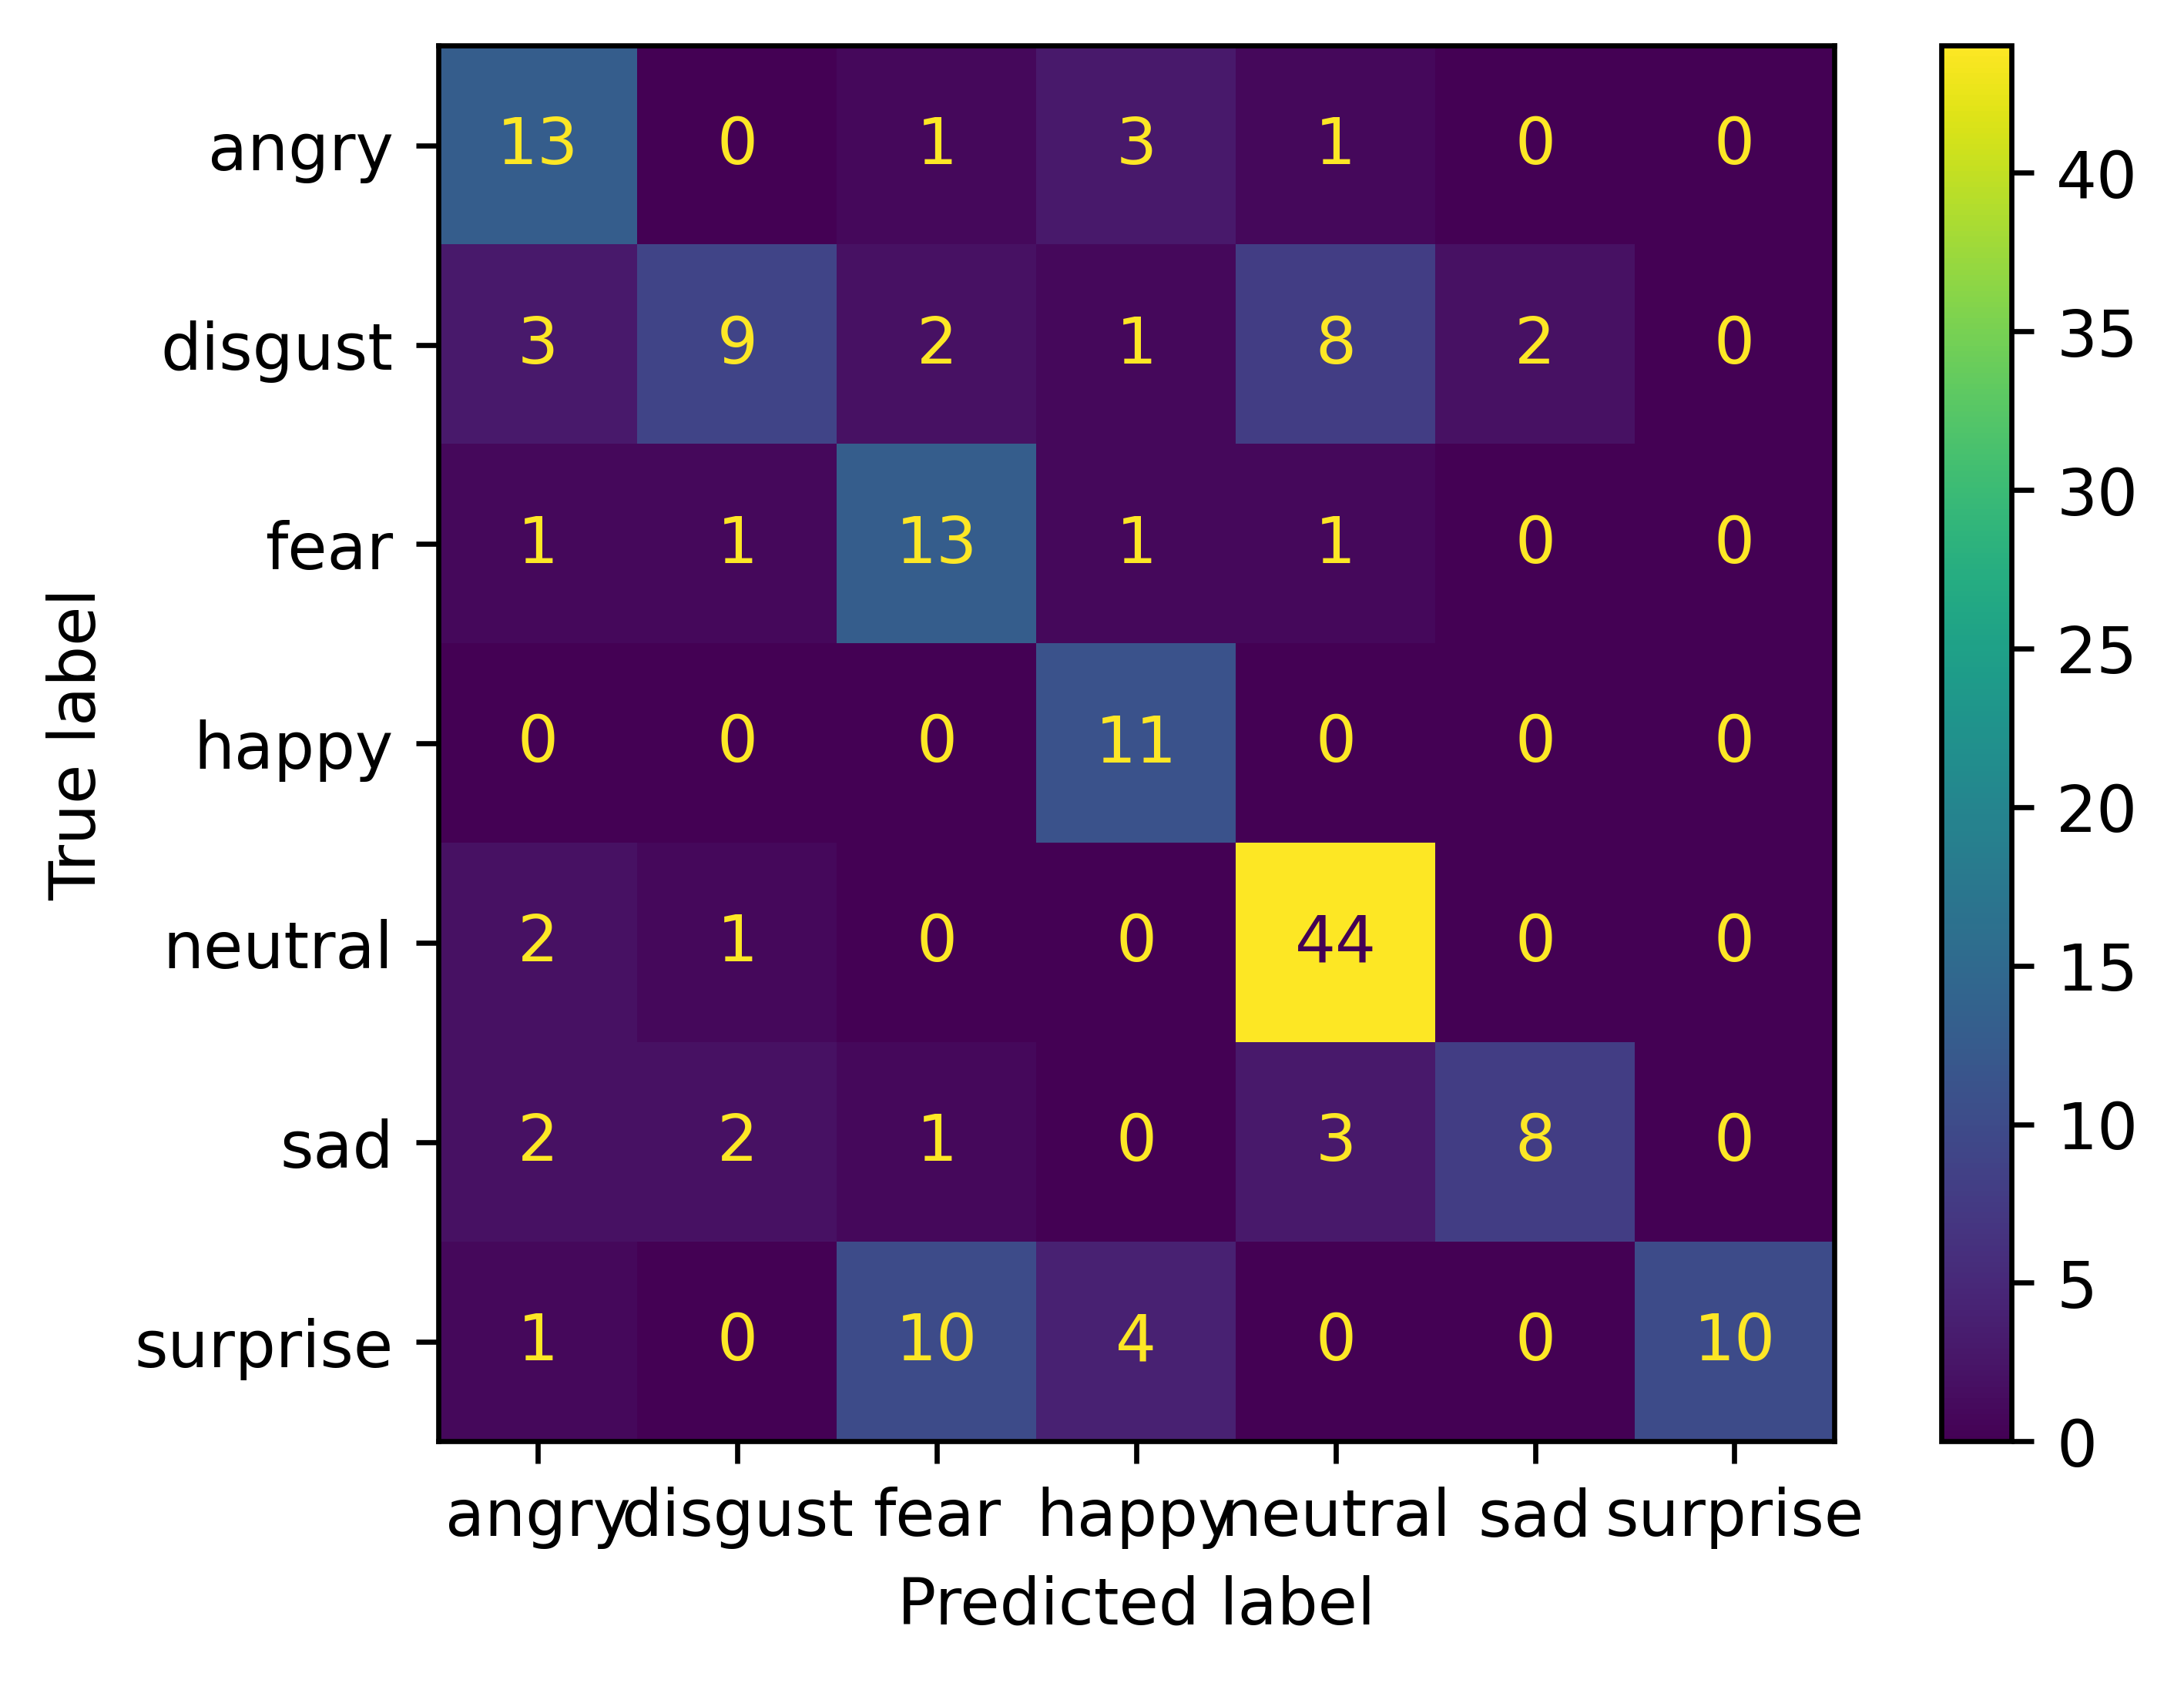

In [ ]:
#plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot()
plt.show()

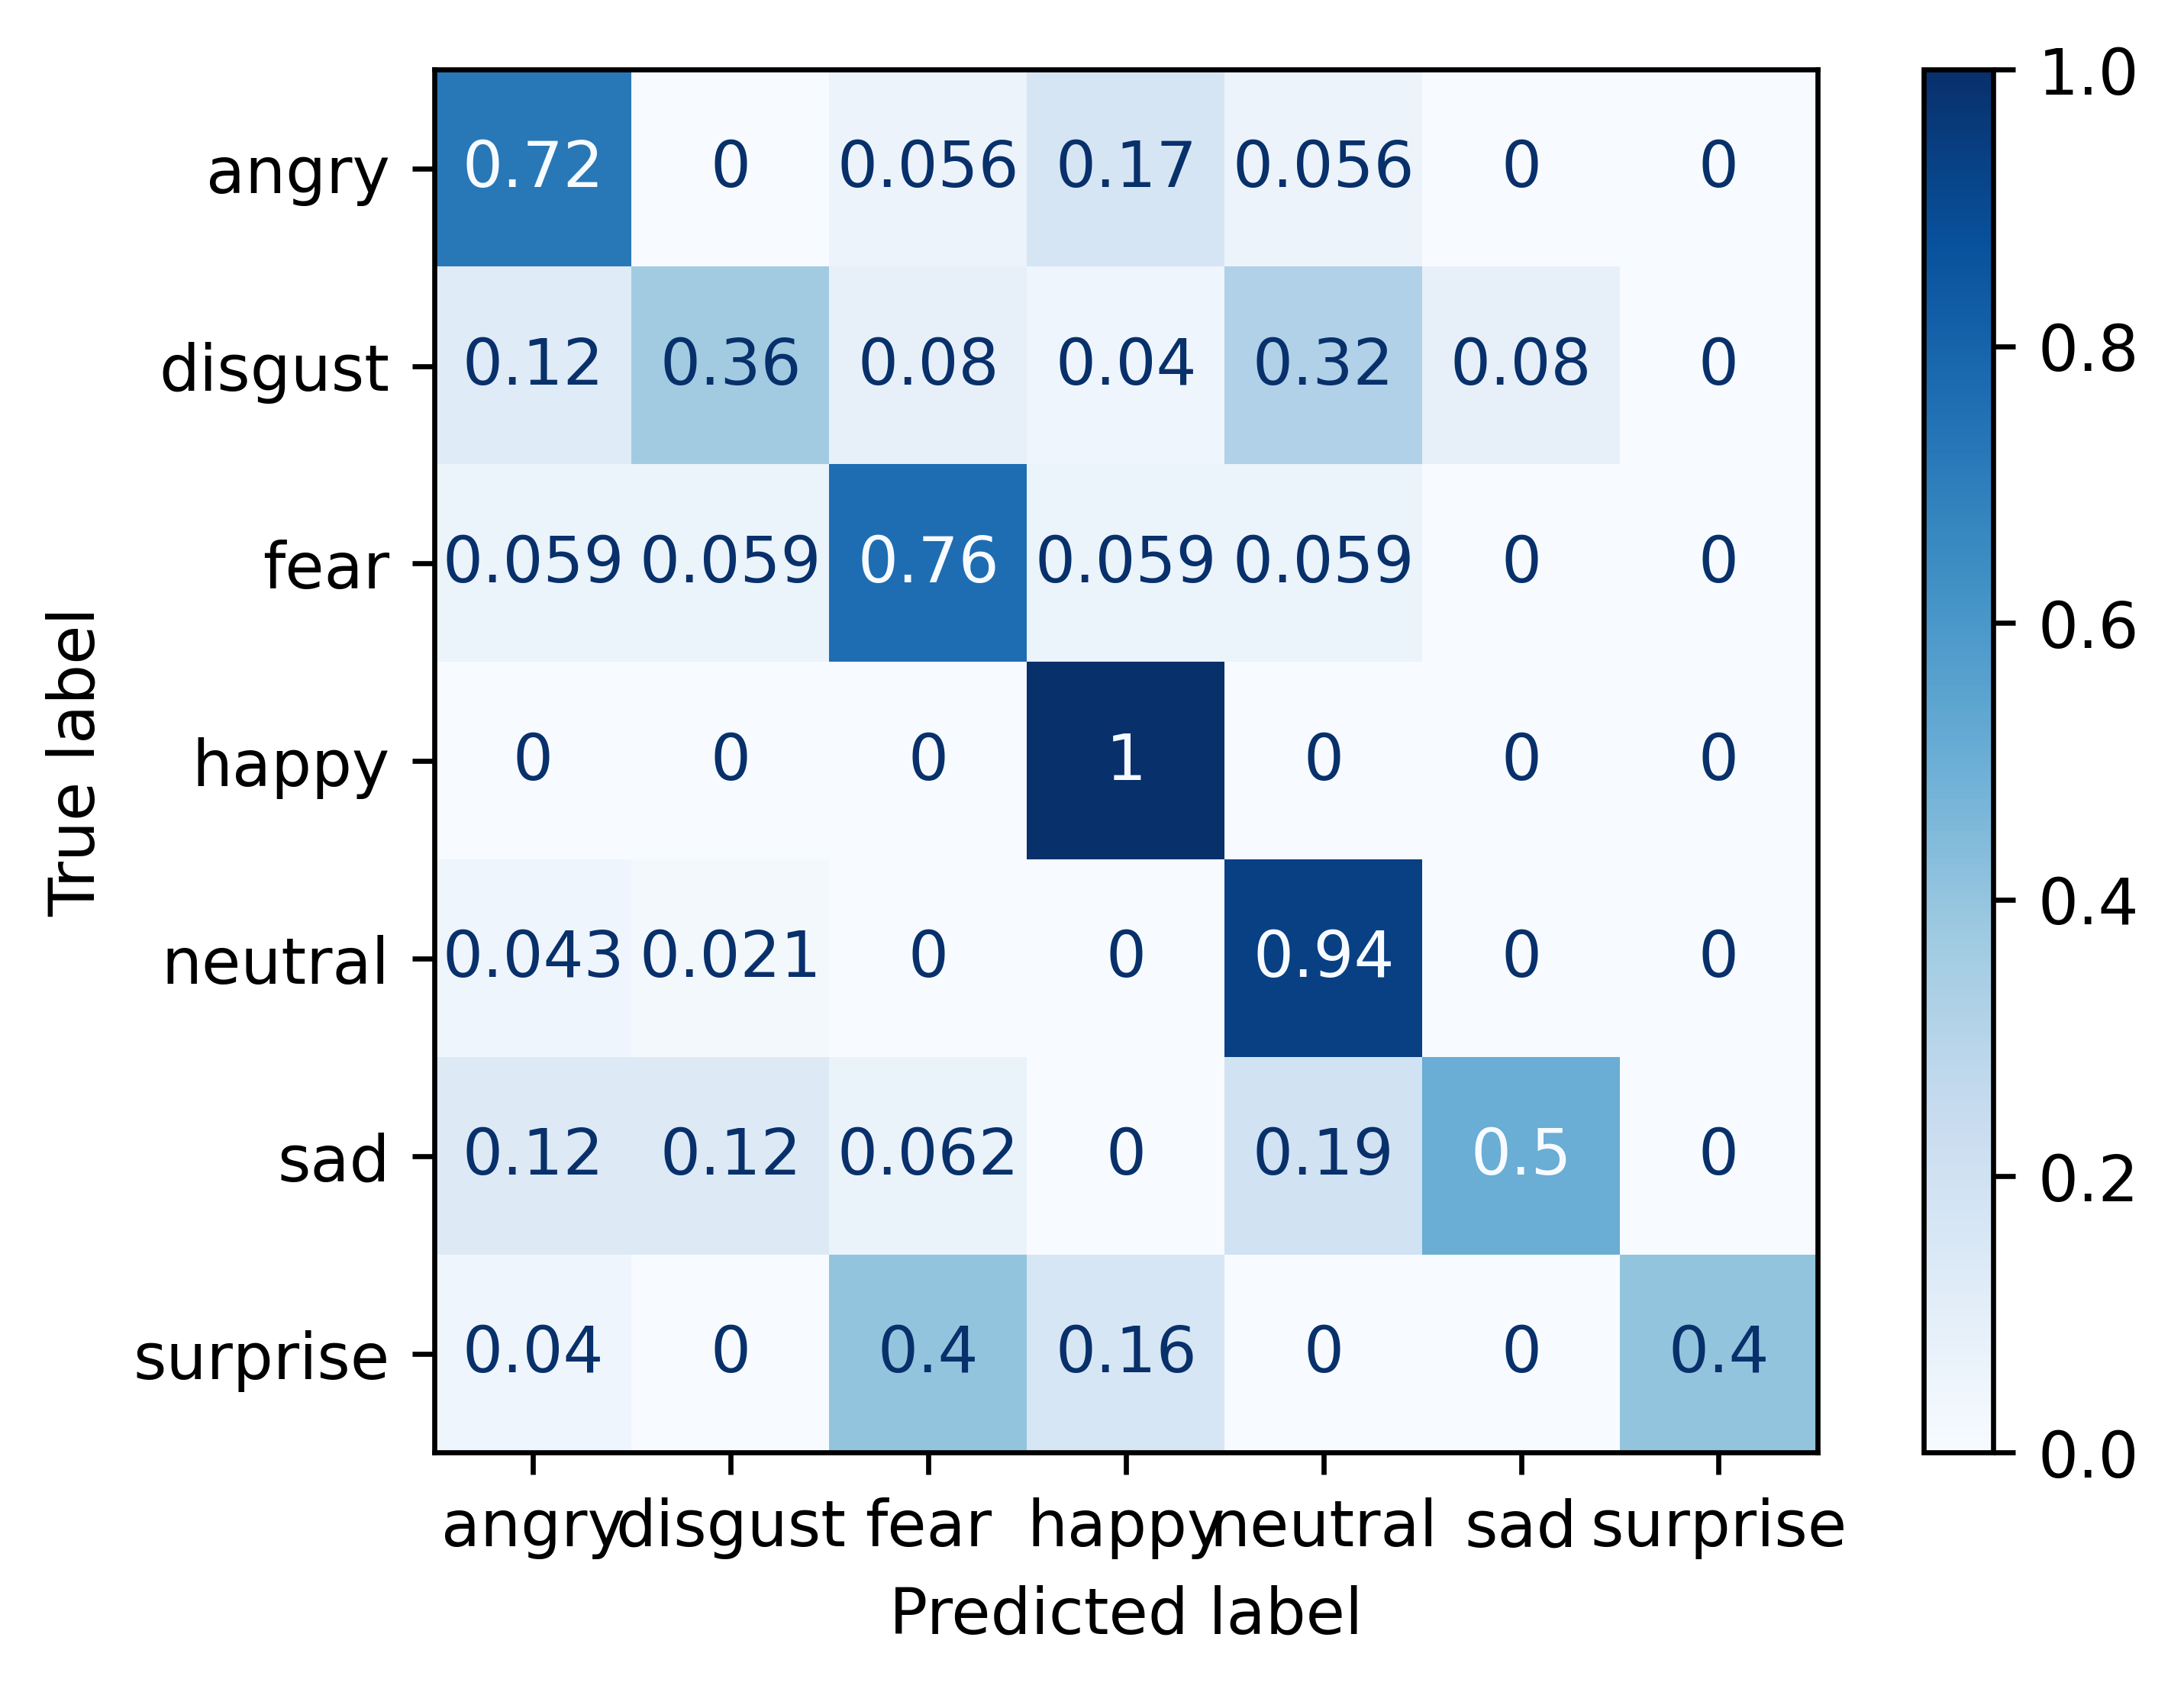

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    grid,
    X_test,
    y_test,
    display_labels=grid.classes_,
    cmap=plt.cm.Blues,
    normalize="true",
)


plt.show()

In [ ]:
confusion_matrix(y_test,y_test_hat)

array([[17,  0,  0,  3,  0,  0,  0],
       [ 2,  8,  1,  3,  4,  1,  1],
       [ 1,  4,  1,  2,  0,  2,  4],
       [ 1,  1,  0, 15,  0,  0,  3],
       [ 3,  1,  0,  1, 43,  1,  0],
       [ 0,  0,  1,  0,  6, 10,  1],
       [ 1,  0,  3,  5,  0,  0,  9]])

The results are much better than the paper - need to do statistical runs

We have run the SVC on one of the possible batches. We then selected the best parameters for the SVM. Now, we use these parameters for the statistical runs. We also store the confusion matrices for each of the run to see a more finer classification error!

In [ ]:
#selecting the best possible parameters
C = grid_search.best_params_["C"]
gamma = grid_search.best_params_["gamma"]
kernel = grid_search.best_params_["kernel"]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

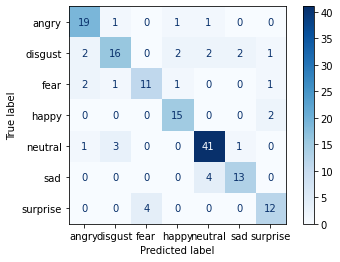

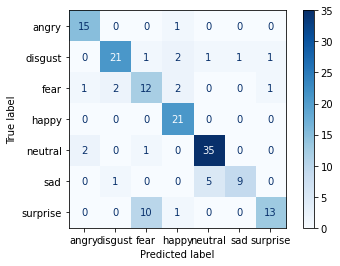

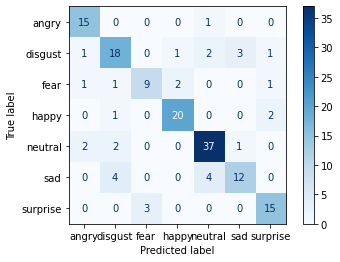

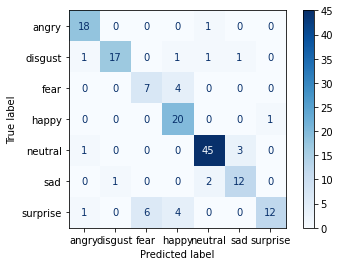

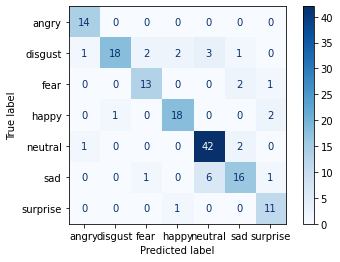

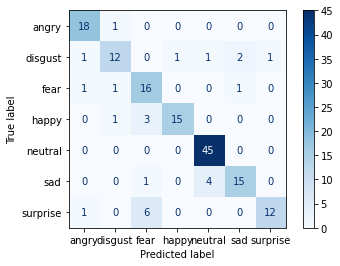

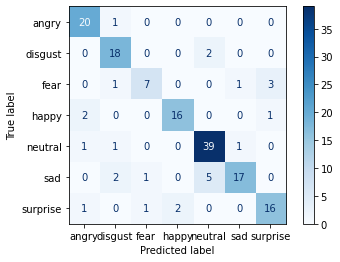

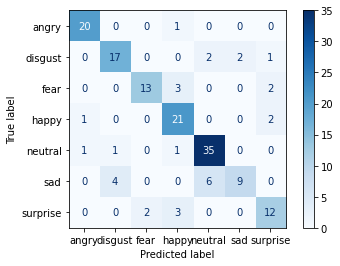

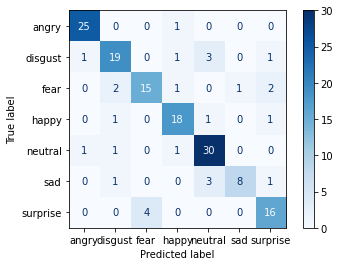

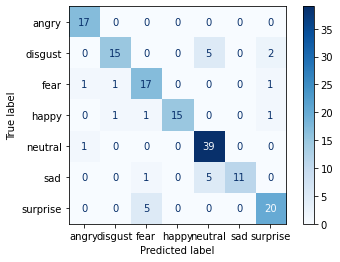

In [ ]:
from sklearn.svm import SVC
training_accuracy = []
testing_accuracy = []
confusion_matrices = []

for _ in range(10):
  X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y, speaker_identity, test_size=0.33)#setting random state to None => different training data
  X_train = (X_train - X_train.min(0)) / X_train.ptp(0)
  X_test = (X_test - X_test.min(0)) / X_test.ptp(0)
  model = SVC(C=C, gamma = gamma, kernel = kernel)
  model_fitted = model.fit(X_train, y_train)
  training_accuracy.append(model_fitted.score(X_train, y_train))
  testing_accuracy.append(model_fitted.score(X_test,y_test))
  y_test_hat = model_fitted.predict(X_test)
  confusion_matrices.append(confusion_matrix(y_test, y_test_hat))
  plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)

In [ ]:
testing_accuracy

[0.6163522012578616,
 0.6226415094339622,
 0.6415094339622641,
 0.7044025157232704,
 0.559748427672956,
 0.6540880503144654,
 0.6415094339622641,
 0.6289308176100629,
 0.6163522012578616,
 0.6226415094339622]

In [ ]:
training_accuracy

[0.881619937694704,
 0.8909657320872274,
 0.8909657320872274,
 0.881619937694704,
 0.8878504672897196,
 0.897196261682243,
 0.8785046728971962,
 0.8878504672897196,
 0.8940809968847352,
 0.8691588785046729]

In [ ]:
disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)

# Leave One Speaker Out (LOSO) method of training

Now, we need to do Leave One speaker out method to test the actual accuracy of the model to unseen data which included as unknown speaker.

Extracting the files same as before but we leave a speaker out

In [ ]:
ls = ['JK', 'DC', 'KL', 'JE']
dele = ls[np.random.randint(0, 3)]

ls.remove(dele)
ls

['DC', 'KL', 'JE']

In [124]:
set(y)

{'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'}

In [3]:
#https://www.kaggle.com/code/mihaibeuca1997/ser-cnn-v2
savee_directory_list = os.listdir(pathToData)
savee_directory_list = ['DC', 'JE', 'KL'] #removed speaker 'JK' from the training data

file_emotion = []
file_path = []
speaker_identity = []

for fileDir in savee_directory_list:
  for file in os.listdir(pathToData + fileDir):
    speaker_identity.append(fileDir)
    file_path.append(pathToData + fileDir+"/" + file)
    #part = file.split('_')[1]
    ele = file[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
Savee_df.Emotions.value_counts()

neutral     90
angry       45
disgust     45
fear        45
happy       45
sad         45
surprise    45
Name: Emotions, dtype: int64

In [4]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

X = df.to_numpy() #no_of_samples x 88

y = file_emotion



In [ ]:
X = (X - X.min(0)) / X.ptp(0)

In [ ]:
X.shape, len(y)

((360, 88), 360)

Thus, the above forms our training data. Notice, that we have left one speaker out. We will include this speaker in our test data we follow the same procedure as above!

In [ ]:
#https://www.kaggle.com/code/mihaibeuca1997/ser-cnn-v2
savee_directory_list = os.listdir(pathToData)
savee_directory_list = ['JK'] #removed speaker 'JK' from the training data

file_emotion = []
file_path = []
speaker_identity = []

for fileDir in savee_directory_list:
  for file in os.listdir(pathToData + fileDir):
    speaker_identity.append(fileDir)
    file_path.append(pathToData + fileDir+"/" + file)
    #part = file.split('_')[1]
    ele = file[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
Savee_df.Emotions.value_counts()

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

X_test = df.to_numpy() #no_of_samples x 88

y_test = file_emotion



X_test.shape, len(y_test)

((120, 88), 120)

In [ ]:
X_test = (X_test - X_test.min(0)) / X_test.ptp(0)

In [12]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
# https://machinelearningknowledge.ai/python-sklearn-support-vector-machine-svm-tutorial-with-example-gridsearchcv/
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['linear']} #'rbf'
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X, y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [ ]:
print(grid_search.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 70.83%


Accuracy for our testing dataset with tuning is : 50.00%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


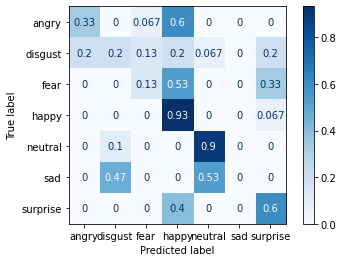

In [ ]:
y_test_hat=grid.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

#plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues, normalize = 'true')

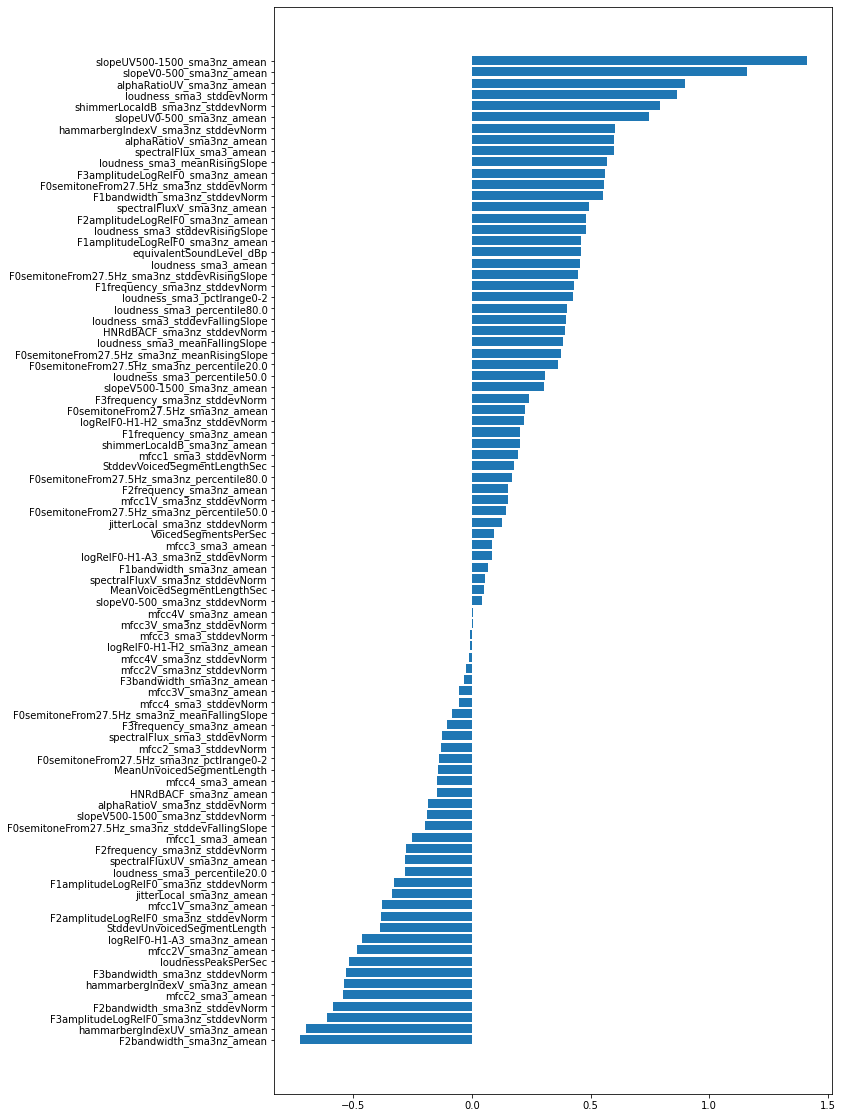

In [ ]:
from sklearn.svm import SVC

#https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize = (10, 20))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#selecting the best possible parameters
C = grid_search.best_params_["C"]
gamma = grid_search.best_params_["gamma"]
kernel = grid_search.best_params_["kernel"]

svmModel = SVC(C=C, gamma = gamma, kernel = kernel)
model_fitted = svmModel.fit(X, y)
f_importances(model_fitted.coef_[0], smile.feature_names)

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.00800154, 0.00785108, 0.00764875, 0.01017025, 0.01182489,
        0.01537721, 0.0148335 , 0.01495326, 0.01608455, 0.01498599,
        0.01631458, 0.01713023, 0.01701689, 0.01707747, 0.01651223,
        0.01656783, 0.01695859, 0.01686904, 0.01628959, 0.01769516,
        0.01683407, 0.01657166, 0.01641307, 0.01685901, 0.01653745]),
 'std_fit_time': array([0.0024384 , 0.00149899, 0.00103799, 0.00199216, 0.00125221,
        0.00263486, 0.00105831, 0.00139156, 0.00127109, 0.00106641,
        0.0013316 , 0.00148153, 0.00144789, 0.00145876, 0.00142588,
        0.00159459, 0.00205988, 0.00122229, 0.00129433, 0.00182312,
        0.0015073 , 0.00178335, 0.0014002 , 0.00196397, 0.00148855]),
 'mean_score_time': array([0.00106721, 0.00109584, 0.00114698, 0.00152652, 0.00164688,
        0.00151868, 0.00152369, 0.00149424, 0.00152593, 0.00159035,
        0.00150464, 0.00151594, 0.00154877, 0.00171916, 0.00153446,
        0.00148811, 0.00148351, 0.00147979, 0.0015038 , 0.00

In [ ]:
arr = np.zeros((25,))
for i in range(0, 10):
  string =f'split{i}_test_score'
  arrr = grid.cv_results_[string]
  arr+=arrr
arr*10#to get accuracy

array([70.83333333, 70.83333333, 70.83333333, 70.83333333, 70.83333333,
       68.05555556, 68.05555556, 68.05555556, 68.05555556, 68.05555556,
       66.38888889, 66.38888889, 66.38888889, 66.38888889, 66.38888889,
       66.38888889, 66.38888889, 66.38888889, 66.38888889, 66.38888889,
       66.38888889, 66.38888889, 66.38888889, 66.38888889, 66.38888889])

# Leave one Speaker out method
In a round robin fashion, we leave out one speaker at a time and then tune for maximum average accuracy in a way

In [16]:
class StandardScaleNormalizer():

    def fit(self, X, speaker):
        """Fits the normalization on input data wrt each of the speaker

        Args:
            X (_type_): _description_
            y_attitude (_type_): _description_
            speaker (_type_): _description_
        """
        speakerID = set(speaker) #generates the unique speaker IDs
        dictMean, dictStd = {}, {}
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        for id in speakerID:
            df_speaker = df.loc[df["speakerID"] == id]
            df_speaker = df_speaker.drop(["speakerID"], axis = 1)
            dictMean[id] = df_speaker.mean()
            dictStd[id] = df_speaker.std()
            
        self.mean = dictMean
        self.scale = dictStd
        
    def transform(self, X, speaker):
        speakerID = set(speaker) #generates the unique speaker IDs
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        df_copy = df.copy()
        for id in speakerID:
            df_copy.loc[df_copy["speakerID"] == id] = (df_copy.loc[df_copy["speakerID"] == id]-self.mean[id])/self.scale[id]
        return df_copy.drop(["speakerID"], axis=1)

    def fit_transform(self, X, speaker):
        self.fit(X, speaker)
        df_copy = self.transform(X, speaker)
        return df_copy


In [72]:
X.shape

(480, 88)

In [106]:
sn = StandardScaleNormalizer()
dataNorm = sn.fit_transform(X, speaker_identity)

In [121]:
from sklearn.model_selection import GridSearchCV

ml = svm.SVC(probability=True) 
    
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
            'gamma': [1,0.1,0.01,0.001,0.0001],
            'kernel': ['rbf']} #'rbf'

grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)

In [100]:
list(set(speaker_identity))

['DC', 'JE', 'KL', 'JK']

In [113]:
df_dataNorm = pd.DataFrame(dataNorm)
df_dataNorm["speakerID"] = speaker_identity
df_dataNorm["label"] = y
df_dataNorm

0         1         2         3         4         5         6  \
0    0.091447  1.753064 -0.241844 -0.099585  0.099900  0.754855 -0.643257   
1   -0.704718 -0.727372 -0.486730 -0.775077 -1.023883 -0.963867 -0.297865   
2    0.459736 -1.048914  0.461449  0.627352  0.389725 -0.263899 -0.940252   
3   -0.236889  0.423356 -0.234238 -0.041917 -0.011051  0.512576 -0.097934   
4    0.528267  3.225224 -0.163268 -0.054949  0.524551  1.436206  2.021588   
..        ...       ...       ...       ...       ...       ...       ...   
475  0.084238  0.446960 -0.586901  0.103005  0.805199  1.943830  0.682795   
476  1.140832  1.662240  0.341612  0.367450  1.368819  1.851833 -0.127887   
477  0.719979 -0.728029  1.132647  1.044354  0.608933 -0.239834 -0.924800   
478  1.229289  0.063224  1.150614  0.884953  1.071837  0.492227 -0.354545   
479  0.604401 -0.606872  0.954163  0.793425  0.747344  0.178466  0.503958   

            7         8         9  ...        80        81        82  \
0   -0.624335  2.385823  1.724117  ...  0.761939  0.640181  0.727492   
1   -0.289710 -0.518545 -0.413131  ... -0.111555 -0.037916 -1.736265   
2   -0.855621 -1.295376 -0.144887  ...  0.265780 -1.465790 -1.545071   
3   -0.313084 -0.301001 -0.559004  ... -0.578452  0.173697 -0.606750   
4    0.487474 -0.503419 -0.252109  ... -0.755516 -1.000116 -0.247315   
..        ...       ...       ...  ...       ...       ...       ...   
475  0.131027  0.704139  0.245979  ...  0.202262  0.000053 -0.380882   
476 -0.492598  0.781315  0.097655  ...  2.288022  1.488891  0.560625   
477 -0.849054  0.059638 -0.049115  ... -0.854075 -1.152241 -0.447296   
478 -0.059374  0.914973  0.589020  ...  1.378552 -0.142088  1.369722   
479 -0.008595  0.025403 -0.049347  ...  0.483588  1.328126  1.126805   

           83        84        85        86        87  speakerID     label  
0   -0.466950  0.226330 -1.109904 -0.239559  0.536828         DC     angry  
1    1.889944  2.265032  1.783079  1.697382  0.471872         DC     angry  
2    0.766397  0.247096  1.856838  0.092938  0.961746         DC     angry  
3    0.260801  1.405049 -0.178904 -0.298875  1.197376         DC     angry  
4    0.055499  1.645733 -0.577202 -0.226687  1.153672         DC     angry  
..        ...       ...       ...       ...       ...        ...       ...  
475 -0.171091 -1.079202  0.026507  0.253858  0.465927         KL  surprise  
476 -0.080255  1.272588 -1.227228 -0.952684  0.372842         KL  surprise  
477  0.257138  0.058559 -0.080956  0.072292  0.762039         KL  surprise  
478 -0.716110 -0.844484 -0.177397  0.330658  0.784207         KL  surprise  
479 -0.659471 -1.083216 -0.405584  0.232140  0.731727         KL  surprise  

[480 rows x 90 columns]

In [123]:
import joblib, os
modelsSVM = []
os.makedirs(r'D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\')
testing_accuracy = []
for i in range(0, 4):
  ls = ['JK', 'DC', 'KL', 'JE']
  test_list = [ls[i]]
  ls.remove(test_list[0])
  train_list = ls
  df_train = df_dataNorm.loc[df_dataNorm["speakerID"].isin(train_list)].drop(["speakerID"], axis = 1)
  y_train = df_train["label"]
  df_train = df_train.drop(["label"], axis = 1).to_numpy()
  df_test = df_dataNorm.loc[df_dataNorm["speakerID"].isin(test_list)].drop(["speakerID"], axis = 1)
  y_test = df_test["label"]
  df_test = df_test.drop(["label"], axis = 1).to_numpy()
  # fitting the model for grid search
  grid_search=grid.fit(df_train, y_train)
  joblib.dump(grid_search, 'D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\svc_model_{model_instance}.pkl'.format(model_instance=test_list[0]))
  y_test_hat=grid.predict(df_test)
  test_accuracy=accuracy_score(y_test,y_test_hat)*100
  testing_accuracy.append(test_accuracy)
  print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )


Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 60.83%
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 71.67%
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 51.67%
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 70.83%


In [13]:
modelsSVM = []
arr = np.zeros((25,))
X_test_RR = []
y_test_RR = []
testing_accuracy = []
for i in range(0, 4):
  ls = ['JK', 'DC', 'KL', 'JE']
  dele = ls[i]
  ls.remove(dele)
  savee_directory_list = ls

  file_emotion = []
  file_path = []
  speaker_identity = []
  
  for fileDir in savee_directory_list:
    for file in os.listdir(pathToData + fileDir):
      speaker_identity.append(fileDir)
      file_path.append(pathToData + fileDir+"/" + file)
      #part = file.split('_')[1]
      ele = file[:-6]
      if ele=='a':
          file_emotion.append('angry')
      elif ele=='d':
          file_emotion.append('disgust')
      elif ele=='f':
          file_emotion.append('fear')
      elif ele=='h':
          file_emotion.append('happy')
      elif ele=='n':
          file_emotion.append('neutral')
      elif ele=='sa':
          file_emotion.append('sad')
      else:
          file_emotion.append('surprise')
          

  emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


  path_df = pd.DataFrame(file_path, columns=['Path'])
  Savee_df = pd.concat([emotion_df, path_df], axis=1)
  Savee_df.head()
  Savee_df.Emotions.value_counts()

  smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,)


  data, sampling_rate = librosa.load(file_path[0])
  max_length = len(data)
  df = smile.process_signal(
      data,
      sampling_rate
  )
  for audioFile in file_path[1:]: 
    data, sampling_rate = librosa.load(audioFile)
    if len(data)>= max_length:#finding maximum length across all the utterances
      max_length = len(data)
    df = pd.concat([df, smile.process_signal(
      data,
      sampling_rate
  )])

  X = df.to_numpy() #no_of_samples x 88

  y = file_emotion

  X = (X - X.min(0)) / X.ptp(0)



  savee_directory_list = [dele] #removed speaker 'JK' from the training data

  file_emotion = []
  file_path = []
  speaker_identity = []

  for fileDir in savee_directory_list:
    for file in os.listdir(pathToData + fileDir):
      speaker_identity.append(fileDir)
      file_path.append(pathToData + fileDir+"/" + file)
      #part = file.split('_')[1]
      ele = file[:-6]
      if ele=='a':
          file_emotion.append('angry')
      elif ele=='d':
          file_emotion.append('disgust')
      elif ele=='f':
          file_emotion.append('fear')
      elif ele=='h':
          file_emotion.append('happy')
      elif ele=='n':
          file_emotion.append('neutral')
      elif ele=='sa':
          file_emotion.append('sad')
      else:
          file_emotion.append('surprise')
      

  emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


  path_df = pd.DataFrame(file_path, columns=['Path'])
  Savee_df = pd.concat([emotion_df, path_df], axis=1)
  Savee_df.head()
  Savee_df.Emotions.value_counts()

  smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  smile.feature_names

  data, sampling_rate = librosa.load(file_path[0])
  max_length = len(data)
  df = smile.process_signal(
      data,
      sampling_rate
  )
  for audioFile in file_path[1:]: 
    data, sampling_rate = librosa.load(audioFile)
    if len(data)>= max_length:#finding maximum length across all the utterances
      max_length = len(data)
    df = pd.concat([df, smile.process_signal(
      data,
      sampling_rate
  )])

  X_test = df.to_numpy() #no_of_samples x 88

  y_test = file_emotion

  X_test_RR.append(X_test)
  y_test_RR.append(y_test)

  X_test.shape, len(y_test)
  X_test = (X_test - X_test.min(0)) / X_test.ptp(0)


  



  

  ml = svm.SVC() 
    
  # defining parameter range
  param_grid = {'C': [ 1, 10, 100, 1000,10000], 
                'gamma': [1,0.1,0.01,0.001,0.0001],
                'kernel': ['linear']} #'rbf'
    
  grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
    
  # fitting the model for grid search
  grid_search=grid.fit(X, y)
  modelsSVM.append(ml)
  y_test_hat=grid.predict(X_test)
  test_accuracy=accuracy_score(y_test,y_test_hat)*100
  testing_accuracy.append(test_accuracy)
  print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )


  
  for i in range(0, 10):
    string =f'split{i}_test_score'
    arrr = grid.cv_results_[string]
    arr+=arrr


Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 50.00%
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Accuracy for our testing dataset with tuning is : 62.50%


Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x000001E257607520>
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\opensmile\core\SMILEapi.py", line 362, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):
KeyboardInterrupt: 
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\opensmile\core\smile.py:307: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


In [ ]:
arr*10.0/4

array([69.44444444, 69.44444444, 69.44444444, 69.44444444, 69.44444444,
       67.08333333, 67.08333333, 67.08333333, 67.08333333, 67.08333333,
       65.20833333, 65.20833333, 65.20833333, 65.20833333, 65.20833333,
       65.27777778, 65.27777778, 65.27777778, 65.27777778, 65.27777778,
       65.27777778, 65.27777778, 65.27777778, 65.27777778, 65.27777778])

In [ ]:
sum(testing_accuracy)/4

52.08333333333333

# t-SNE

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [ ]:
 # Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot()#aspect='equal'
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-85, 65)
    #plt.ylim(-85, 65)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=10)
pca_result = pca.fit_transform(X_train)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.047478437423706055 seconds


In [ ]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [8.4320897e-01 7.0980325e-02 4.0352017e-02 1.5788369e-02 8.2736602e-03
 7.9103550e-03 7.1664685e-03 2.1232832e-03 1.6360392e-03 7.5510389e-04]


<ipython-input-54-24cf5e591d10>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-75.70019, 16.886694, '0'),
  Text(-73.641716, -63.71615, '1'),
  Text(-72.72081, -113.76171, '2'),
  Text(-72.2303, -145.51915, '3'),
  Text(-74.59938, -76.27822, '4'),
  Text(-74.316734, -72.03392, '5'),
  Text(-72.27575, -88.680664, '6')])

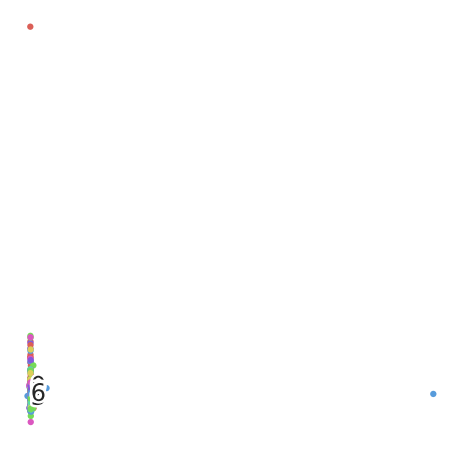

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
# i = 0
# oheThing = []
# for thing in np.sort(np.unique(y_train)):
#   oheThing.append([thing, i])
#   i+=1
# enc = OneHotEncoder.fit(oheThing)

le = preprocessing.LabelEncoder()
le.fit(y_train)


fashion_scatter(top_two_comp.values, le.transform(y_train)) # Visualizing the PCA output

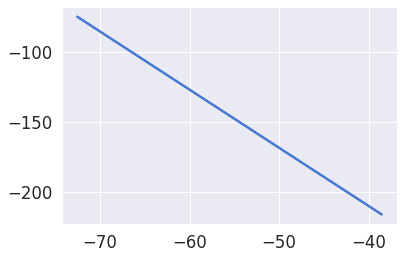

In [ ]:
plt.plot(top_two_comp.values[0], top_two_comp.values[1])

In [ ]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=RS).fit_transform(X_train)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 5.398142337799072 seconds


<ipython-input-54-24cf5e591d10>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-9.047304, 3.5974154, '0'),
  Text(-2.615198, 0.29533625, '1'),
  Text(1.1264498, -0.28143406, '2'),
  Text(4.133188, -0.58913594, '3'),
  Text(-0.7391378, -0.83992344, '4'),
  Text(-0.8371326, -5.8317633, '5'),
  Text(-0.34970218, 3.2195315, '6')])

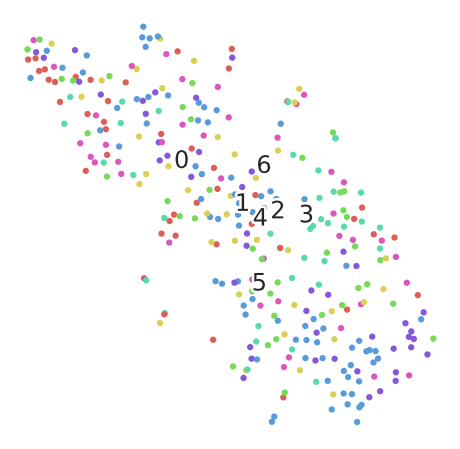

In [ ]:
fashion_scatter(fashion_tsne, le.transform(y_train))